In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from random import sample, seed
import copy
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=73, Om0=0.25)

In [3]:
Hubble_h = 0.73
#BoxSize = ((62.5**3) * (8/8))**(1/3)
BoxSize = ((500**3) * (512/512))**(1/3)
#BoxSize = ((1000**3) * (1000/1000))**(1/3)
#BoxSize = ((250**3) * (1/125))**(1/3)
#print(BoxSize)
dilute = 5000
sSFRcut = -11.0

In [4]:
directory = '../../output/test-bulge3/'
#directory = '../src/auxdata/trees/play2/'
#directory1 = '../../output/no-destruct/'
filename = 'model'
#redshift = [127.000, 79.998, 50.000, 30.000, 19.916, 18.244, 16.725, 15.343, 14.086, 12.941, 11.897, 10.944, 10.073, 9.278, 8.550, 7.883, 7.272, 6.712, 6.197, 5.724, 5.289, 4.888, 4.520, 4.179, 3.866, 3.576, 3.308, 3.060, 2.831, 2.619, 2.422, 2.239, 2.070, 1.913, 1.766, 1.630, 1.504, 1.386, 1.276, 1.173, 1.078, 0.989, 0.905, 0.828, 0.755, 0.687, 0.624, 0.564, 0.509, 0.457, 0.408, 0.362, 0.320, 0.280, 0.242, 0.208, 0.175, 0.144, 0.116, 0.089, 0.064, 0.041, 0.020, 0.000]
#redshift.reverse()
#age_list = cosmo.age(redshift).value
#lbtime = cosmo.lookback_time(redshift).value
redshift = [0.000, 1.386, 2.070, 3.060, 4.179, 5.289, 6.197, 7.272] #millennium 
#redshift = [0.024, 1.309, 2.051, 3.033, 4.088, 5.127, 6.044, 7.098] #genesis
#redshift = [0.000, 1.379, 2.028, 3.060, 4.043, 5.161, 6.231, 7.313] #bolshoi
#redshift = [0.000]
#redshift = [0.000, 1.321, 2.028, 3.037, 4.038, 5.150, 6.022, 7.026] #MDPL
firstfile = 0
lastfile = 511
MaxTreeFiles = lastfile - firstfile + 1
#print(lbtime)

In [5]:
def galdtype():
	# Define the data-type for the public version of SAGE
	Galdesc_full = [
        ('SnapNum'                      , np.int32),
        ('Type'                         , np.int32),
        ('GalaxyIndex'                  , np.int64),
        ('CentralGalaxyIndex'           , np.int64),
        ('SAGEHaloIndex'                , np.int32),
        ('SAGETreeIndex'                , np.int32),
        ('SimulationHaloIndex'          , np.int64),
        ('mergeType'                    , np.int32),
        ('mergeIntoID'                  , np.int32),
        ('mergeIntoSnapNum'             , np.int32),
        ('dT'                           , np.float32),
        ('Pos'                          , (np.float32, 3)),
        ('Vel'                          , (np.float32, 3)),
        ('Spin'                         , (np.float32, 3)),
        ('Len'                          , np.int32),
        ('Mvir'                         , np.float32),
        ('CentralMvir'                  , np.float32),
        ('Rvir'                         , np.float32),
        ('Vvir'                         , np.float32),
        ('Vmax'                         , np.float32),
        ('VelDisp'                      , np.float32),
        ('ColdGas'                      , np.float32),
        ('f_H2'                         , np.float32),
        ('f_HI'                         , np.float32),
        ('cf'                           , np.float32),
        ('Zp'                           , np.float32),
        ('Pressure'                     , np.float32),
        ('StellarMass'                  , np.float32),
        ('BulgeMass'                    , np.float32),
        ('BulgeInstability'             , np.float32),
        ('HotGas'                       , np.float32),
        ('EjectedMass'                  , np.float32),
        ('BlackHoleMass'                , np.float32),
        ('IntraClusterStars'            , np.float32),
        ('MetalsColdGas'                , np.float32),
        ('MetalsStellarMass'            , np.float32),
        ('MetalsBulgeMass'              , np.float32),
        ('MetalsHotGas'                 , np.float32),
        ('MetalsEjectedMass'            , np.float32),
        ('MetalsIntraClusterStars'      , np.float32),
        ('ColdDust'                     , np.float32),
        ('HotDust'                      , np.float32),
        ('EjectedDust'                     , np.float32),
        ('SfrDisk'                      , np.float32),
        ('SfrBulge'                     , np.float32),
        ('SfrDiskZ'                     , np.float32),
        ('SfrBulgeZ'                    , np.float32),
        ('dustdotform'                  , np.float32),
        ('dustdotgrowth'                    , np.float32),
        ('dustdotdestruct'                    , np.float32),
#        ('Sfr'                          , (np.float32, 64)),
        ('DiskRadius'                   , np.float32),
        ('Cooling'                      , np.float32),
        ('Heating'                      , np.float32),
        ('QuasarModeBHaccretionMass'    , np.float32),
        ('TimeOfLastMajorMerger'         , np.float32),
        ('TimeOfLastMinorMerger'         , np.float32),
        ('OutflowRate'                  , np.float32),
        ('infallMvir'                   , np.float32),
        ('infallVvir'                   , np.float32),
        ('infallVmax'                   , np.float32)
        ]
	names = [Galdesc_full[i][0] for i in range(len(Galdesc_full))]
	formats = [Galdesc_full[i][1] for i in range(len(Galdesc_full))]
	Galdesc = np.dtype({'names':names, 'formats':formats}, align=True)
	return Galdesc

In [6]:
def read_one_file(name, Galdesc):
    fin = open(name, 'rb')
    Ntrees = np.fromfile(fin,np.dtype(np.int32),1)[0]
    NtotGals = np.fromfile(fin,np.dtype(np.int32),1)[0]
    GalsPerTree = np.fromfile(fin, np.dtype((np.int32, Ntrees)),1)[0]
    G = np.fromfile(fin, Galdesc, NtotGals)
    G = G.view(recarray)
    return G

In [7]:
Galdesc = galdtype()

G_history = [0]*len(redshift)
#G_history1 = [0]*len(redshift)
for i in range(len(redshift)):
    G_snap = []
#    G_snap1 = []
#    G_snap2 = []
    GalsTree = []
    
    for k in range(firstfile, lastfile+1):
        
        name = (directory+filename+'_z'+f'{redshift[i]:.3f}'+'_'+f'{k}')
        G = read_one_file(name, Galdesc)
        G_snap.extend(G)
        '''
        name1 = (directory1+filename+'_z'+f'{redshift[i]:.3f}'+'_'+f'{k}')
        G1 = read_one_file(name1, Galdesc)
        G_snap1.extend(G)
        '''
    G_snap = np.array(G_snap)
    G_snap = G_snap.view(recarray)
    
    #G_snap1 = np.array(G_snap1)
    #G_snap1 = G_snap1.view(recarray)
    
    G_history[i] = G_snap
    #G_history1[i] = G_snap1

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update({'font.size': 12})
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Allresults

## Stellar Mass Function

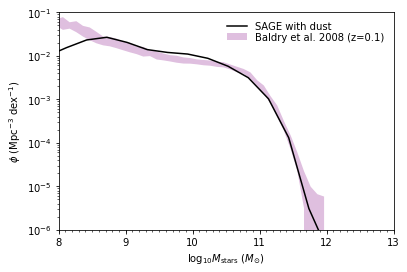

In [9]:
plt.figure()
ax = plt.subplot(111)

binwidth = 0.3

w = np.where(G_history[0].StellarMass > 0.0)[0]
mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)
#w1 = np.where(G_history1[0]1.StellarMass > 0.0)[0]
#mass1 = np.log10(G_history1[0]1.StellarMass[w1] * 1.e10 / Hubble_h)

mi = np.floor(min(mass)) - 2
#ma = np.floor(max(mass)) + 2
ma = 14
NB = int((ma - mi) / binwidth)

(counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)
#(counts1, binedges1) = np.histogram(mass1, range=(mi, ma), bins=NB)

# Set the x-axis values to be the centre of the bins
xaxeshisto = binedges[:-1] + 0.5 * binwidth
#xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth

plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k-', label='SAGE with dust')
#plt.plot(xaxeshisto1, counts1/ (BoxSize/Hubble_h)**3 / binwidth, 'k:', label='new metals & dust model')

# Baldry+ 2008 modified data used for the MCMC fitting
Baldry = np.array([
            [7.05, 1.3531e-01, 6.0741e-02],
            [7.15, 1.3474e-01, 6.0109e-02],
            [7.25, 2.0971e-01, 7.7965e-02],
            [7.35, 1.7161e-01, 3.1841e-02],
            [7.45, 2.1648e-01, 5.7832e-02],
            [7.55, 2.1645e-01, 3.9988e-02],
            [7.65, 2.0837e-01, 4.8713e-02],
            [7.75, 2.0402e-01, 7.0061e-02],
            [7.85, 1.5536e-01, 3.9182e-02],
            [7.95, 1.5232e-01, 2.6824e-02],
            [8.05, 1.5067e-01, 4.8824e-02],
            [8.15, 1.3032e-01, 2.1892e-02],
            [8.25, 1.2545e-01, 3.5526e-02],
            [8.35, 9.8472e-02, 2.7181e-02],
            [8.45, 8.7194e-02, 2.8345e-02],
            [8.55, 7.0758e-02, 2.0808e-02],
            [8.65, 5.8190e-02, 1.3359e-02],
            [8.75, 5.6057e-02, 1.3512e-02],
            [8.85, 5.1380e-02, 1.2815e-02],
            [8.95, 4.4206e-02, 9.6866e-03],
            [9.05, 4.1149e-02, 1.0169e-02],
            [9.15, 3.4959e-02, 6.7898e-03],
            [9.25, 3.3111e-02, 8.3704e-03],
            [9.35, 3.0138e-02, 4.7741e-03],
            [9.45, 2.6692e-02, 5.5029e-03],
            [9.55, 2.4656e-02, 4.4359e-03],
            [9.65, 2.2885e-02, 3.7915e-03],
            [9.75, 2.1849e-02, 3.9812e-03],
            [9.85, 2.0383e-02, 3.2930e-03],
            [9.95, 1.9929e-02, 2.9370e-03],
            [10.05, 1.8865e-02, 2.4624e-03],
            [10.15, 1.8136e-02, 2.5208e-03],
            [10.25, 1.7657e-02, 2.4217e-03],
            [10.35, 1.6616e-02, 2.2784e-03],
            [10.45, 1.6114e-02, 2.1783e-03],
            [10.55, 1.4366e-02, 1.8819e-03],
            [10.65, 1.2588e-02, 1.8249e-03],
            [10.75, 1.1372e-02, 1.4436e-03],
            [10.85, 9.1213e-03, 1.5816e-03],
            [10.95, 6.1125e-03, 9.6735e-04],
            [11.05, 4.3923e-03, 9.6254e-04],
            [11.15, 2.5463e-03, 5.0038e-04],
            [11.25, 1.4298e-03, 4.2816e-04],
            [11.35, 6.4867e-04, 1.6439e-04],
            [11.45, 2.8294e-04, 9.9799e-05],
            [11.55, 1.0617e-04, 4.9085e-05],
            [11.65, 3.2702e-05, 2.4546e-05],
            [11.75, 1.2571e-05, 1.2571e-05],
            [11.85, 8.4589e-06, 8.4589e-06],
            [11.95, 7.4764e-06, 7.4764e-06],
            ], dtype=np.float32)

Baldry_xval = np.log10(10 ** Baldry[:, 0]  /Hubble_h/Hubble_h)
Baldry_xval = Baldry_xval - 0.26  # convert back to Chabrier IMF
Baldry_yvalU = (Baldry[:, 1]+Baldry[:, 2]) * Hubble_h*Hubble_h*Hubble_h
Baldry_yvalL = (Baldry[:, 1]-Baldry[:, 2]) * Hubble_h*Hubble_h*Hubble_h

plt.fill_between(Baldry_xval, Baldry_yvalU, Baldry_yvalL, facecolor='purple', alpha=0.25, label='Baldry et al. 2008 (z=0.1)')

plt.yscale('log', nonposy='clip')
plt.axis([8.0, 13.0, 1.0e-6, 1.0e-1])

# Set the x-axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))

plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$')  # and the x-axis labels

leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')

#plt.savefig('plots/SMF-play2b.png')
plt.show()

In [ ]:
HI_rr, errHI_rr, Z_rr, H2_rr, atomic_rr, logdust_rr, logdust2_rr, dustpercent_rr, logstar_rr = np.loadtxt('remy-ruyers.txt', usecols=(1,2,3,5,6,9,7,8,10), unpack=True)

gas = atomic_rr* (HI_rr + H2_rr)
errHI = errHI_rr * HI_rr / 100
gas_err = atomic_rr * errHI
metal = (10 ** (Z_rr - 9)) * 0.02 * gas
metal_err = (10 ** (Z_rr - 9)) * 0.02 * gas_err

dust_rr = 10 ** logdust_rr
dust2_rr = 10 ** logdust2_rr
dusterr_rr = dustpercent_rr* dust_rr / 100
star_rr = 10 ** logstar_rr

logdustupper_rr = np.log10((dust_rr + dusterr_rr)/ dust_rr)
logdustlower_rr = np.log10((dust_rr - dusterr_rr)/ dust_rr)

w1 = np.where(gas > 0)[0]
logstar_rr = logstar_rr[w1]
logdust_rr = logdust_rr[w1]
logdustupper_rr = logdustupper_rr[w1]
logdustlower_rr = logdustlower_rr[w1]
Z_rr = Z_rr[w1]
gas_rr = gas[w1]
metal_rr = metal[w1]
DTG = dust_rr[w1] / gas[w1]
DTM = dust_rr[w1] / metal[w1]

dust_err = dustpercent_rr[w1]
gas_err = gas_err[w1]
metal_err = metal_err[w1]
DTG_err = np.zeros(len(dust_err))
DTM_err = np.zeros(len(dust_err))


for i in range(len(dust_err)):
    if (dust_err[i]>0):
        DTG_err[i] = DTG[i] * np.sqrt((dust_err[i]/100)**2 + (gas_err[i]/gas_rr[i])**2)
        DTM_err[i] = DTM[i] * np.sqrt((dust_err[i]/100)**2 + (metal_err[i]/metal_rr[i])**2)
    else:
        DTG_err[i] = DTG[i] * np.sqrt((gas_err[i]/gas_rr[i])**2)
        DTM_err[i] = DTM[i] * np.sqrt((metal_err[i]/metal_rr[i])**2)

DTG_rr = np.log10(DTG)
DTGerr_up = np.log10(DTG_err+DTG) - np.log10(DTG)
DTGerr_low = np.log10(DTG-DTG_err) - np.log10(DTG)
DTGerr = DTG_err / DTG / 2.303
DTM_rr = np.log10(DTM)
DTMerr_up = np.log10((DTM_err+DTM)/DTM)
DTMerr_low = np.log10((DTM-DTM_err)/DTM)
DTMerr = DTM_err / DTM / 2.303
#print(DTGerr_up, DTGerr)
'''
DTM = dust_rr[w1] / metal[w1]
DTMerr = DTM * np.sqrt((dustpercent_rr[w1]/100)**2 + (metal_err[w1]/metal[w1])**2)
DTM_rr = np.log10(DTM)
DTMerr_rr = np.log10((DTMerr+DTM)/DTM)
'''
#plt.errorbar(Z_rr, DTG_rr, yerr=[DTGerr_low, DTGerr_up], fmt='k.', alpha=0.7, label='Remy-Ruyer et al. 2014')
plt.errorbar(Z_rr, DTG_rr, yerr=DTGerr, fmt='k.')
#plt.yscale('log')
#plt.ylim(1e-6, 1e-1)
#plt.xlim(6, 10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, marker='.', s=1, **kwargs )
    return ax

## Dust Mass Function

In [ ]:
plt.figure()
ax = plt.subplot(111)

binwidth = 0.2

w = np.where(G_history[0].ColdDust > 0.0)[0]
mass = np.log10(G_history[0].ColdDust[w] * 1.e10 / Hubble_h)

mi = np.floor(min(mass)) - 2
ma = np.floor(max(mass)) + 2
#ma = 10
NB = int((ma - mi) / binwidth)

(counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)

# Set the x-axis values to be the centre of the bins
xaxeshisto = binedges[:-1] + 0.5 * binwidth

plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k-', label='SAGE with dust')

vlahakis_x = np.array([6.289, 6.543, 6.788, 7.034, 7.287, 7.542, 7.787, 8.038, 8.282, 8.536])
vlahakis_y = np.array([-1.928, -2.033, -2.122, -2.329, -2.554, -2.859, -3.344, -3.979, -4.844, -5.507])
vlahakis_yerr = np.array([(0.0, 0), (0.0, 0.0), (0.097, 0), (0.081, 0), (0.122, 0), (0.149, 0), (0.205, 0.177), (0.246, 0.138), (0.216, 0.448), (0.301, 0.163)]).T
vlahakis_yerr[0] = 10**vlahakis_y - 10**(vlahakis_y - vlahakis_yerr[0])
vlahakis_yerr[1] = 10**(vlahakis_y + vlahakis_yerr[1]) - 10**vlahakis_y
plt.errorbar(vlahakis_x, 10**vlahakis_y, vlahakis_yerr, fmt='r.', label='Vlahakis 2005')

clemens_x = np.array([6.405, 6.706, 7.003, 7.304, 7.605, 7.903, 8.196, 8.497, 8.798, 9.096])
clemens_y = np.array([-1.27, -1.696, -1.697, -1.829, -1.917, -2.212, -2.676, -3.454, -4.607, -5.749])
clemens_yerr = np.array([(0.719, 0.281), (0.322, 0.319), (0.273, 0.239), (0.186, 0.166), (0.112, 0.104), (0.094, 0.073), (0.0, 0.093), (0.126, 0.114), (0.361, 0.364), (0.0, 0.545)]).T
clemens_yerr[0] = 10**clemens_y - 10**(clemens_y - clemens_yerr[0])
clemens_yerr[1] = 10**(clemens_y + clemens_yerr[1]) - 10**clemens_y
plt.errorbar(clemens_x, 10**clemens_y, clemens_yerr, fmt='r^', label='Clemens 2013')

dunne_x = np.array([6.071, 6.318, 6.546, 6.784, 7.011, 7.243, 7.470, 7.711, 7.931, 8.178, 8.409])
dunne_y = np.array([-1.778, -2.391, -2.320, -1.991, -2.234, -2.517, -2.568, -2.675, -3.248, -4.048, -4.356])
dunne_yerr = np.array([(0.313, 0.313), (0.258, 0.234), (0.229, 0.188), (0.0, 0.117), (0.0, 0.0), (0.233, 0.083), (0.0, 0.0), (0.112, 0.082), (0.124, 0.118), (0.309, 0.301), (0.433, 0.431)]).T
dunne_yerr[0] = 10**dunne_y - 10**(dunne_y - dunne_yerr[0])
dunne_yerr[1] = 10**(dunne_y + dunne_yerr[1]) - 10**dunne_y
plt.errorbar(dunne_x, 10**dunne_y, dunne_yerr, fmt='r*', label='Dunne 2011')

plt.yscale('log', nonposy='clip')
plt.axis([6.0, 10.0, 1.0e-6, 1.0e-1])

plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
plt.xlabel(r'$\log_{10} M_{\mathrm{dust}}\ (M_{\odot})$')  # and the x-axis labels

leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
    
#plt.savefig('plots/DMF-play-2b.png')

## Gas Mass Function

In [ ]:
plt.figure ()
#ax = plt.subplot(111)

binwidth = 0.3

w = np.where(G_history[0].ColdGas > 0.0)[0]
mass = np.log10(G_history[0].ColdGas[w] * 1.0e10 / Hubble_h)
H2 = np.log10(G_history[0].f_H2[w] * G_history[0].ColdGas[w] * 1.0e10 / Hubble_h)
HI = np.log10(G_history[0].f_HI[w] * G_history[0].ColdGas[w] * 1.0e10 / Hubble_h)

mi = np.floor(min(mass)) - 2
ma = np.floor(max(mass)) + 2
NB = int((ma - mi) / binwidth)

(counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)
(counts2, binedges2) = np.histogram(H2, range=(mi, ma), bins=NB)
(counts3, binedges3) = np.histogram(HI, range=(mi, ma), bins=NB)

# Set the x-axis values to be the centre of the bins
xaxeshisto = binedges[:-1] + 0.5 * binwidth
xaxeshisto2 = binedges2[:-1] + 0.5 * binwidth
xaxeshisto3 = binedges3[:-1] + 0.5 * binwidth

plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k-', label='Cold gas')
plt.plot(xaxeshisto2, counts2/ (BoxSize/Hubble_h)**3 / binwidth, 'b-', label='H2')
plt.plot(xaxeshisto3, counts3/ (BoxSize/Hubble_h)**3 / binwidth, 'r-', label='HI')

Zwaan = np.array([[6.933,   -0.333],
            [7.057,   -0.490],
            [7.209,   -0.698],
            [7.365,   -0.667],
            [7.528,   -0.823],
            [7.647,   -0.958],
            [7.809,   -0.917],
            [7.971,   -0.948],
            [8.112,   -0.927],
            [8.263,   -0.917],
            [8.404,   -1.062],
            [8.566,   -1.177],
            [8.707,   -1.177],
            [8.853,   -1.312],
            [9.010,   -1.344],
                  
            [9.161,   -1.448],
            [9.302,   -1.604],
            [9.448,   -1.792],
            [9.599,   -2.021],
            [9.740,   -2.406],
            [9.897,   -2.615],
            [10.053,  -3.031],
            [10.178,  -3.677],
            [10.335,  -4.448],
            [10.492,  -5.083]        ], dtype=np.float32)
        
ObrRaw = np.array([
            [7.300,   -1.104],
            [7.576,   -1.302],
            [7.847,   -1.250],
            [8.133,   -1.240],
            [8.409,   -1.344],
            [8.691,   -1.479],
            [8.956,   -1.792],
            [9.231,   -2.271],
            [9.507,   -3.198],
            [9.788,   -5.062 ]        ], dtype=np.float32)

ObrCold = np.array([
            [8.009,   -1.042],
            [8.215,   -1.156],
            [8.409,   -0.990],
            [8.604,   -1.156],
            [8.799,   -1.208],
            [9.020,   -1.333],
            [9.194,   -1.385],
            [9.404,   -1.552],
            [9.599,   -1.677],
            [9.788,   -1.812],
            [9.999,   -2.312],
            [10.172,  -2.656],
            [10.362,  -3.500],
            [10.551,  -3.635],
            [10.740,  -5.010]        ], dtype=np.float32)

ObrCold_xval = np.log10(10**(ObrCold[:, 0])  /Hubble_h/Hubble_h)
ObrCold_yval = (10**(ObrCold[:, 1]) * Hubble_h*Hubble_h*Hubble_h)
Zwaan_xval = np.log10(10**(Zwaan[:, 0]) /Hubble_h/Hubble_h)
Zwaan_yval = (10**(Zwaan[:, 1]) * Hubble_h*Hubble_h*Hubble_h)
ObrRaw_xval = np.log10(10**(ObrRaw[:, 0])  /Hubble_h/Hubble_h)
ObrRaw_yval = (10**(ObrRaw[:, 1]) * Hubble_h*Hubble_h*Hubble_h)

plt.plot(ObrCold_xval, ObrCold_yval, color='black', lw = 7, alpha=0.25, label='Obr. \& Raw. 2009 (Cold Gas)')
plt.plot(Zwaan_xval, Zwaan_yval, color='red', lw = 7, alpha=0.25, label='Zwaan et al. 2005 (HI)')
plt.plot(ObrRaw_xval, ObrRaw_yval, color='blue', lw = 7, alpha=0.25, label='Obr. \& Raw. 2009 (H2)')

plt.yscale('log', nonposy='clip')
plt.axis([8.0, 11.5, 1.0e-6, 1.0e-1])

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))

plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')
plt.xlabel(r'$\log_{10} M_{\mathrm{X}}\ (M_{\odot})$')

leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
    
#plt.savefig('plots/GMF-play-2b.png')    
plt.show()

## Bulge fraction mass

In [ ]:
seed(2222)

fBulge = G_history[0].BulgeMass / G_history[0].StellarMass
fDisk = 1.0 - (G_history[0].BulgeMass) / G_history[0].StellarMass
mass = np.log10(G_history[0].StellarMass * 1.0e10 / Hubble_h)
sSFR = np.log10((G_history[0].SfrDisk + G_history[0].SfrBulge) / (G_history[0].StellarMass * 1.0e10 / Hubble_h))
        
binwidth = 0.2
shift = binwidth/2.0
mass_range = np.arange(8.5-shift, 12.0+shift, binwidth)
bins = len(mass_range)
        
fBulge_ave = np.zeros(bins)
fBulge_var = np.zeros(bins)
fDisk_ave = np.zeros(bins)
fDisk_var = np.zeros(bins)
        
for i in range(bins-1):
    w = np.where( (mass >= mass_range[i]) & (mass < mass_range[i+1]))[0]
    # w = np.where( (mass >= mass_range[i]) & (mass < mass_range[i+1]) & (sSFR < sSFRcut))[0]
    if(len(w) > 0):
        fBulge_ave[i] = np.mean(fBulge[w])
        fBulge_var[i] = np.var(fBulge[w])
        fDisk_ave[i] = np.mean(fDisk[w])
        fDisk_var[i] = np.var(fDisk[w])

w = np.where(fBulge_ave > 0.0)[0]
plt.plot(mass_range[w]+shift, fBulge_ave[w], 'r-', label='bulge')
plt.fill_between(mass_range[w]+shift, 
    fBulge_ave[w]+fBulge_var[w], 
    fBulge_ave[w]-fBulge_var[w], 
    facecolor='red', alpha=0.25)

w = np.where(fDisk_ave > 0.0)[0]
plt.plot(mass_range[w]+shift, fDisk_ave[w], 'k-', label='disk stars')
plt.fill_between(mass_range[w]+shift, 
    fDisk_ave[w]+fDisk_var[w], 
    fDisk_ave[w]-fDisk_var[w], 
    facecolor='black', alpha=0.25)

plt.axis([mass_range[0], mass_range[bins-1], 0.0, 1.05])

plt.ylabel(r'$\mathrm{Stellar\ Mass\ Fraction}$')  # Set the y...
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$')  # and the x-axis labels

leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
        t.set_fontsize('medium')
        
#plt.savefig('plots/BulgeMassFraction-play2b.png')

## Metallicity

In [ ]:
seed(2222)

w = np.where((G_history[0].Type == 0) & ( G_history[0].ColdGas / (G_history[0].StellarMass + G_history[0].ColdGas) > 0.0) &
            (G_history[0].StellarMass > 0.01))[0]
#if(len(w) > dilute): w = sample(list(w), dilute)
mass = np.log10(G_history[0].StellarMass[w]* 1.0e10 / Hubble_h)
Z = np.log10((G_history[0].MetalsColdGas[w] / G_history[0].ColdGas[w]) / 0.02) + 9.0
w = np.where(Z >6)[0]
print(min(Z), max(Z), min(mass), max(mass))
plt.hist2d(mass[w], Z[w], bins=(50, 100), norm=LogNorm())
#plt.scatter(mass, Z, marker='o', s=1, c='k', alpha=0.5, label='SAGE with dust')

# overplot Tremonti et al. 2003 (h=0.7)
w = np.arange(7.0, 13.0, 0.1)
Zobs = -1.492 + 1.847*w - 0.08026*w*w
plt.plot(np.log10((10**w *1.5 /1.8)), Zobs, 'b-', lw=2.0, label='Tremonti et al. 2003')

plt.ylabel(r'$12\ +\ \log_{10}[\mathrm{O/H}]$')
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$') 

# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))

plt.axis([8.0, 12.0, 8.0, 9.5])

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')

#plt.savefig('plots/MassMetallicity_vanilla.png')
#plt.show()

# History

## SFR density evolution

In [ ]:
plt.figure()  # New figure
ax = plt.subplot(111)  # 1 plot on the figure

ObsSFRdensity = np.array([
    [0, 0.0158489, 0, 0, 0.0251189, 0.01000000],
    [0.150000, 0.0173780, 0, 0.300000, 0.0181970, 0.0165959],
    [0.0425000, 0.0239883, 0.0425000, 0.0425000, 0.0269153, 0.0213796],
    [0.200000, 0.0295121, 0.100000, 0.300000, 0.0323594, 0.0269154],
    [0.350000, 0.0147911, 0.200000, 0.500000, 0.0173780, 0.0125893],
    [0.625000, 0.0275423, 0.500000, 0.750000, 0.0331131, 0.0229087],
    [0.825000, 0.0549541, 0.750000, 1.00000, 0.0776247, 0.0389045],
    [0.625000, 0.0794328, 0.500000, 0.750000, 0.0954993, 0.0660693],
    [0.700000, 0.0323594, 0.575000, 0.825000, 0.0371535, 0.0281838],
    [1.25000, 0.0467735, 1.50000, 1.00000, 0.0660693, 0.0331131],
    [0.750000, 0.0549541, 0.500000, 1.00000, 0.0389045, 0.0776247],
    [1.25000, 0.0741310, 1.00000, 1.50000, 0.0524807, 0.104713],
    [1.75000, 0.0562341, 1.50000, 2.00000, 0.0398107, 0.0794328],
    [2.75000, 0.0794328, 2.00000, 3.50000, 0.0562341, 0.112202],
    [4.00000, 0.0309030, 3.50000, 4.50000, 0.0489779, 0.0194984],
    [0.250000, 0.0398107, 0.00000, 0.500000, 0.0239883, 0.0812831],
    [0.750000, 0.0446684, 0.500000, 1.00000, 0.0323594, 0.0776247],
    [1.25000, 0.0630957, 1.00000, 1.50000, 0.0478630, 0.109648],
    [1.75000, 0.0645654, 1.50000, 2.00000, 0.0489779, 0.112202],
    [2.50000, 0.0831764, 2.00000, 3.00000, 0.0512861, 0.158489],
    [3.50000, 0.0776247, 3.00000, 4.00000, 0.0416869, 0.169824],
    [4.50000, 0.0977237, 4.00000, 5.00000, 0.0416869, 0.269153],
    [5.50000, 0.0426580, 5.00000, 6.00000, 0.0177828, 0.165959],
    [3.00000, 0.120226, 2.00000, 4.00000, 0.173780, 0.0831764],
    [3.04000, 0.128825, 2.69000, 3.39000, 0.151356, 0.109648],
    [4.13000, 0.114815, 3.78000, 4.48000, 0.144544, 0.0912011],
    [0.350000, 0.0346737, 0.200000, 0.500000, 0.0537032, 0.0165959],
    [0.750000, 0.0512861, 0.500000, 1.00000, 0.0575440, 0.0436516],
    [1.50000, 0.0691831, 1.00000, 2.00000, 0.0758578, 0.0630957],
    [2.50000, 0.147911, 2.00000, 3.00000, 0.169824, 0.128825],
    [3.50000, 0.0645654, 3.00000, 4.00000, 0.0776247, 0.0512861],
    ], dtype=np.float32)

ObsRedshift = ObsSFRdensity[:, 0]
xErrLo = ObsSFRdensity[:, 0]-ObsSFRdensity[:, 2]
xErrHi = ObsSFRdensity[:, 3]-ObsSFRdensity[:, 0]

ObsSFR = np.log10(ObsSFRdensity[:, 1])
yErrLo = np.log10(ObsSFRdensity[:, 1])-np.log10(ObsSFRdensity[:, 4])
yErrHi = np.log10(ObsSFRdensity[:, 5])-np.log10(ObsSFRdensity[:, 1])

# plot observational data (compilation used in Croton et al. 2006)
plt.errorbar(ObsRedshift, ObsSFR, yerr=[yErrLo, yErrHi], xerr=[xErrLo, xErrHi], color='g', lw=1.0, alpha=0.3, marker='o', ls='none', label='Observations')

SFR_density = np.zeros((len(redshift)))
for snap in range(len(redshift)):
    SFR_density[snap] = sum(G_history[snap].SfrDisk+G_history[snap].SfrBulge) / (BoxSize/Hubble_h)**3

z = np.array(redshift)
#nonzero = np.where(SFR_density > 0.0)[0]
plt.plot(z, np.log10(SFR_density), lw=3.0)
  
plt.ylabel(r'$\log_{10} \mathrm{SFR\ density}\ (M_{\odot}\ \mathrm{yr}^{-1}\ \mathrm{Mpc}^{-3})$')  # Set the y...
plt.xlabel(r'$\mathrm{redshift}$')  # and the x-axis labels

# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))

plt.axis([0.0, 8.0, -3.0, -0.4])

#plt.savefig('plots/SFRdensity_full.png')

## Stellar mass density evolution

In [ ]:
plt.figure()  # New figure
ax = plt.subplot(111)  # 1 plot on the figure

# SMD observations taken from Marchesini+ 2009, h=0.7
# Values are (minz, maxz, rho,-err,+err)
dickenson2003 = np.array(((0.6,1.4,8.26,0.08,0.08),
                (1.4,2.0,7.86,0.22,0.33),
                (2.0,2.5,7.58,0.29,0.54),
                (2.5,3.0,7.52,0.51,0.48)),float)
drory2005 = np.array(((0.25,0.75,8.3,0.15,0.15),
            (0.75,1.25,8.16,0.15,0.15),
            (1.25,1.75,8.0,0.16,0.16),
            (1.75,2.25,7.85,0.2,0.2),
            (2.25,3.0,7.75,0.2,0.2),
            (3.0,4.0,7.58,0.2,0.2)),float)
# Perez-Gonzalez (2008)
pg2008 = np.array(((0.2,0.4,8.41,0.06,0.06),
            (0.4,0.6,8.37,0.04,0.04),
            (0.6,0.8,8.32,0.05,0.05),
            (0.8,1.0,8.24,0.05,0.05),
            (1.0,1.3,8.15,0.05,0.05),
            (1.3,1.6,7.95,0.07,0.07),
            (1.6,2.0,7.82,0.07,0.07),
            (2.0,2.5,7.67,0.08,0.08),
            (2.5,3.0,7.56,0.18,0.18),
            (3.0,3.5,7.43,0.14,0.14),
            (3.5,4.0,7.29,0.13,0.13)),float)
glazebrook2004 = np.array(((0.8,1.1,7.98,0.14,0.1),
                    (1.1,1.3,7.62,0.14,0.11),
                    (1.3,1.6,7.9,0.14,0.14),
                    (1.6,2.0,7.49,0.14,0.12)),float)
fontana2006 = np.array(((0.4,0.6,8.26,0.03,0.03),
                (0.6,0.8,8.17,0.02,0.02),
                (0.8,1.0,8.09,0.03,0.03),
                (1.0,1.3,7.98,0.02,0.02),
                (1.3,1.6,7.87,0.05,0.05),
                (1.6,2.0,7.74,0.04,0.04),
                (2.0,3.0,7.48,0.04,0.04),
                (3.0,4.0,7.07,0.15,0.11)),float)
rudnick2006 = np.array(((0.0,1.0,8.17,0.27,0.05),
                (1.0,1.6,7.99,0.32,0.05),
                (1.6,2.4,7.88,0.34,0.09),
                (2.4,3.2,7.71,0.43,0.08)),float)
elsner2008 = np.array(((0.25,0.75,8.37,0.03,0.03),
                (0.75,1.25,8.17,0.02,0.02),
                (1.25,1.75,8.02,0.03,0.03),
                (1.75,2.25,7.9,0.04,0.04),
                (2.25,3.0,7.73,0.04,0.04),
                (3.0,4.0,7.39,0.05,0.05)),float)

obs = (dickenson2003,drory2005,pg2008,glazebrook2004,
               fontana2006,rudnick2006,elsner2008)

for o in obs:
    xval = ((o[:,1]-o[:,0])/2.)+o[:,0]
    if(whichimf == 0):
        ax.errorbar(xval, np.log10(10**o[:,2] *1.6), xerr=(xval-o[:,0], o[:,1]-xval), yerr=(o[:,3], o[:,4]), alpha=0.3, lw=1.0, marker='o', ls='none')
    elif(whichimf == 1):
        ax.errorbar(xval, np.log10(10**o[:,2] *1.6/1.8), xerr=(xval-o[:,0], o[:,1]-xval), yerr=(o[:,3], o[:,4]), alpha=0.3, lw=1.0, marker='o', ls='none')

smd = np.zeros((len(redshift)))

for snap in range(len(redshift)):
    w = np.where((G_history[snap].StellarMass/Hubble_h > 0.01) & (G_history[snap].StellarMass/Hubble_h < 1000.0))[0]
    if(len(w) > 0):
        smd[snap] = sum(G_history[snap].StellarMass[w]) *1.0e10/Hubble_h / (BoxSize/Hubble_h)**3
z = np.array(redshift)

plt.plot(z, np.log10(smd), 'k-', lw=3.0)
plt.ylabel(r'$\log_{10}\ \phi\ (M_{\odot}\ \mathrm{Mpc}^{-3})$')  # Set the y...
plt.xlabel(r'$\mathrm{redshift}$')  # and the x-axis labels

# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))

plt.axis([0.0, 4.2, 6.5, 9.0])

#plt.savefig('plots/StellarMassDensity_z-mini.png')

## Dust mass function Evolution

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))

for i in range(8):
    ax1 = plt.subplot(2,4,i+1)
    binwidth = 0.1  # mass function histogram bin width

    #PLOT COLD DUST ONLY
    #====================
    w = np.where(G_history[i].ColdDust > 0.0)[0]
    mass = np.log10(G_history[i].ColdDust[w] * 1.0e10 /Hubble_h)

    mi = np.int(np.floor(min(mass)) - 2)
    ma = np.int(np.floor(max(mass)) + 2)
    NB = np.int((ma - mi) / binwidth)

    (counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)

    # Set the x-axis values to be the centre of the bins
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
      
    # Overplot the model histograms
    plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k-', lw=1.5)
    
    #PLOT ALL DUST
    #====================
    w = np.where(G_history[i].ColdDust > 0.0)[0]
    mass = np.log10((G_history[i].ColdDust[w] + G_history[i].HotDust[w]
                    + G_history[i].EjectedDust[w]) * 1.0e10 /Hubble_h)

    mi = np.int(np.floor(min(mass)) - 2)
    ma = np.int(np.floor(max(mass)) + 2)
    NB = np.int((ma - mi) / binwidth)

    (counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)

    # Set the x-axis values to be the centre of the bins
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
      
    # Overplot the model histograms
    #plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k--')

    ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.xticks([6, 7, 8, 9, 10])
    plt.yscale('log', nonposy='clip')
    plt.axis([5.5, 10.1, 1.0e-6, 5e-1])


plt.subplot(241)
popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(0, 1), unpack=True)
plt.plot(popping_x, 10**popping_y, 'r-', label="Popping 2017")

mckinnon_x, mckinnon_y = np.loadtxt('previousmodels/DMFMcKinnon.txt', usecols=(4, 5), unpack=True)
plt.plot(mckinnon_x, 10**mckinnon_y, 'r-.', label="McKinnon 2017")

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DMFVijayan.txt', usecols=(0, 1), unpack=True)
plt.plot(vijayan_x, 10**vijayan_y, 'r--', label="Vijayan 2019")

vlahakis_x = np.array([6.289, 6.543, 6.788, 7.034, 7.287, 7.542, 7.787, 8.038, 8.282, 8.536])
vlahakis_y = np.array([-1.928, -2.033, -2.122, -2.329, -2.554, -2.859, -3.344, -3.979, -4.844, -5.507])
vlahakis_yerr = np.array([(0.0, 0), (0.0, 0.0), (0.097, 0), (0.081, 0), (0.122, 0), (0.149, 0), (0.205, 0.177), (0.246, 0.138), (0.216, 0.448), (0.301, 0.163)]).T
vlahakis_yerr[0] = 10**vlahakis_y - 10**(vlahakis_y - vlahakis_yerr[0])
vlahakis_yerr[1] = 10**(vlahakis_y + vlahakis_yerr[1]) - 10**vlahakis_y
plt.errorbar(vlahakis_x, 10**vlahakis_y, vlahakis_yerr, fmt='k.', mfc='white', label='Vlahakis 2005')

clemens_x = np.array([6.405, 6.706, 7.003, 7.304, 7.605, 7.903, 8.196, 8.497, 8.798, 9.096])
clemens_y = np.array([-1.27, -1.696, -1.697, -1.829, -1.917, -2.212, -2.676, -3.454, -4.607, -5.749])
clemens_yerr = np.array([(0.719, 0.281), (0.322, 0.319), (0.273, 0.239), (0.186, 0.166), (0.112, 0.104), (0.094, 0.073), (0.0, 0.093), (0.126, 0.114), (0.361, 0.364), (0.0, 0.545)]).T
clemens_yerr[0] = 10**clemens_y - 10**(clemens_y - clemens_yerr[0])
clemens_yerr[1] = 10**(clemens_y + clemens_yerr[1]) - 10**clemens_y
plt.errorbar(clemens_x, 10**clemens_y, clemens_yerr, fmt='k^', mfc='white', label='Clemens 2013')

dunne_x = np.array([6.071, 6.318, 6.546, 6.784, 7.011, 7.243, 7.470, 7.711, 7.931, 8.178, 8.409])
dunne_y = np.array([-1.778, -2.391, -2.320, -1.991, -2.234, -2.517, -2.568, -2.675, -3.248, -4.048, -4.356])
dunne_yerr = np.array([(0.313, 0.313), (0.258, 0.234), (0.229, 0.188), (0.0, 0.117), (0.0, 0.0), (0.233, 0.083), (0.0, 0.0), (0.112, 0.082), (0.124, 0.118), (0.309, 0.301), (0.433, 0.431)]).T
dunne_yerr[0] = 10**dunne_y - 10**(dunne_y - dunne_yerr[0])
dunne_yerr[1] = 10**(dunne_y + dunne_yerr[1]) - 10**dunne_y
plt.errorbar(dunne_x, 10**dunne_y, dunne_yerr, fmt='kD',mfc='white', label='Dunne 2011')

leg = plt.legend(loc='lower left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
    
plt.subplot(242).set_xticklabels([])
plt.subplot(242).set_yticklabels([])

popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(2, 3), unpack=True)
plt.plot(popping_x, 10**popping_y, 'r-')

mckinnon_x, mckinnon_y = np.loadtxt('previousmodels/DMFMcKinnon.txt', usecols=(2, 3), unpack=True)
plt.plot(mckinnon_x, 10**mckinnon_y, 'r-.')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DMFVijayan.txt', usecols=(2, 3), unpack=True)
plt.plot(vijayan_x, 10**vijayan_y, 'r--')

eales_x = np.array([9.600, 9.216, 9.546, 9.88])
eales_y = np.array([-4.102, -3.335, -5.080, -5.790])
eales_yerr = np.array([(0.377, 0.178), (0.365, 0.196), (1.909, 0.29), (1.194, 0.305)]).T
eales_yerr[0] = 10**eales_y - 10**(eales_y - eales_yerr[0])
eales_yerr[1] = 10**(eales_y + eales_yerr[1]) - 10**eales_y
plt.errorbar(eales_x, 10**eales_y, eales_yerr, fmt='kv',mfc='white', label='Eales 2009')

leg = plt.legend(loc='lower left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(243).set_xticklabels([])
plt.subplot(243).set_yticklabels([])

popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(4, 5), unpack=True)
plt.plot(popping_x, 10**popping_y, 'r')

mckinnon_x, mckinnon_y = np.loadtxt('previousmodels/DMFMcKinnon.txt', usecols=(0, 1), unpack=True)
plt.plot(mckinnon_x, 10**mckinnon_y, 'r-.')

dunne03_x = np.array([7.718, 8.259, 8.795, 8.616, 8.99, 9.179, 9.301, 8.852, 9.002, 8.435, 8.640, 8.313, 7.934])
dunne03_y = np.array([-2.675, -2.830, -3.305, -3.015, -3.629, -4.309, -4.494, -3.699, -3.893, -2.711, -2.955, -2.590, -2.256])
dunne03_yerr = np.array([(0.160, 0.121), (0.674, 0.248), (0.091, 0.106), (0.271, 0.169), (0.117, 0.118), (0.275, 0.148), (0.172, 0.156), (0.233, 0.15), (0.157, 0.089), (0.149, 0.094), (0.111, 0.085), (0.271, 0.145), (0.654, 0.256)]).T
dunne03_yerr[0] = 10**dunne03_y - 10**(dunne03_y - dunne03_yerr[0])
dunne03_yerr[1] = 10**(dunne03_y + dunne03_yerr[1]) - 10**dunne03_y
plt.errorbar(dunne03_x, 10**dunne03_y, dunne03_yerr, fmt='ks',mfc='white', label='Dunne 2003')
leg = plt.legend(loc='lower left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(244).set_xticklabels([])
plt.subplot(244).set_yticklabels([])

popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(6, 7), unpack=True)
plt.plot(popping_x, 10**popping_y, 'r-')

plt.subplot(245)
popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(8, 9), unpack=True)
plt.plot(popping_x, 10**popping_y, 'r-')

plt.subplot(246).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(10, 11), unpack=True)
order = np.argsort(popping_x)
plt.plot(np.array(popping_x)[order], 10**np.array(popping_y)[order], 'r-')

plt.subplot(247).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(12, 13), unpack=True)
plt.plot(popping_x, 10**popping_y, 'r-')

plt.subplot(248).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DMFPopping.txt', usecols=(14, 15), unpack=True)
order = np.argsort(popping_x)
plt.plot(np.array(popping_x)[order], 10**np.array(popping_y)[order], 'r-')

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.05, r'$\log_{10} M_{\mathrm{dust}}\ (M_{\odot})$', fontsize=24, ha='center')
fig.text(0.07, 0.5, r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1}$)', fontsize=24, va='center', rotation='vertical')
fig.text(0.15,0.85, 'z=0.000', fontsize=16)
fig.text(0.35,0.85, 'z=1.386', fontsize=16)
fig.text(0.53,0.85, 'z=2.070', fontsize=16)
fig.text(0.73,0.85, 'z=3.060', fontsize=16)
fig.text(0.15,0.47, 'z=4.179', fontsize=16)
fig.text(0.35,0.47, 'z=5.289', fontsize=16)
fig.text(0.53,0.47, 'z=6.197', fontsize=16)
fig.text(0.73,0.47, 'z=7.272', fontsize=16)
#plt.tight_layout()
#plt.savefig('plots/DMFEvolution_play2.png')

## Rate - Stellar Mass Evolution

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16, 8))

for i in range(8):
    ax = plt.subplot(2,4,i+1)
    w = np.where((G_history[i].StellarMass * 1.e10 / Hubble_h > 1.e8) & (G_history[i].ColdDust > 0) & (G_history[i].dustdotgrowth > 0))[0]
    #if(len(w) > 150000): w = sample(list(w), 150000)
    mass = np.log10(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
    form = np.log10(G_history[i].dustdotform[w])  
    growth = np.log10(G_history[i].dustdotgrowth[w])
    destruct = np.log10(G_history[i].dustdotdestruct[w])

    binwidth = 0.3
    total_bins = int((max(mass) - min(mass)) / binwidth)

    bins = np.linspace(mass.min(), mass.max(), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(mass, bins)
    medianf = [np.percentile(form[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(form[idx==k+1]) > 10]
    mediang = [np.percentile(growth[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(growth[idx==k+1]) > 10]
    mediand = [np.percentile(destruct[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(destruct[idx==k+1]) > 10]
    xf = [(bins[k]-delta/2) for k in range(total_bins) if len(form[idx==k+1]) > 10]
    xg = [(bins[k]-delta/2) for k in range(total_bins) if len(growth[idx==k+1]) > 10]
    xd = [(bins[k]-delta/2) for k in range(total_bins) if len(destruct[idx==k+1]) > 10]

    #plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
    plt.plot(xf, medianf, 'k--', label='condensation')
    plt.plot(xg, mediang, 'b-.', label='growth')
    plt.plot(xd, mediand, 'r:', label='destruction')
    plt.axis([7.5, 11.7, -5.8, 0.1])
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.xticks([8, 9, 10, 11, 12])
    
plt.subplot(241).set_xticklabels([])
leg = plt.legend(loc='lower right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')


plt.subplot(242).set_xticklabels([])
plt.subplot(242).set_yticklabels([])
plt.subplot(243).set_xticklabels([])
plt.subplot(243).set_yticklabels([])
plt.subplot(244).set_xticklabels([])
plt.subplot(244).set_yticklabels([])
plt.subplot(246).set_yticklabels([])
plt.subplot(247).set_yticklabels([])
plt.subplot(248).set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.04, r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=24, ha='center')
fig.text(0.05, 0.5, r'$\log_{10} \mathrm{Dust}\ \mathrm{rate}\ \mathrm{density}$' + '\n' 
         + r'$(M_{\odot}\ \mathrm{yr}^{-1}\ \mathrm{Mpc}^{-3})$', 
         fontsize=24,va='center', rotation='vertical')

fig.text(0.15,0.83, 'z=0.000', fontsize=16)
fig.text(0.35,0.83, 'z=1.386', fontsize=16)
fig.text(0.55,0.83, 'z=2.070', fontsize=16)
fig.text(0.75,0.83, 'z=3.060', fontsize=16)
fig.text(0.15,0.45, 'z=4.179', fontsize=16)
fig.text(0.35,0.45, 'z=5.289', fontsize=16)
fig.text(0.55,0.45, 'z=6.197', fontsize=16)
fig.text(0.75,0.45, 'z=7.272', fontsize=16)
#plt.savefig('plots/DustRate-mass_z_full.png')

## Mass - age distribution

In [ ]:
# For Milkyway like galaxy
mass = G_history[0].StellarMass * 1.e10 /Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 /Hubble_h
morph = bulge / mass
sfr = G_history[0].SfrDisk + G_history[0].SfrDisk
ws = np.where((mass > 5.7e10) & (mass < 5.9e10) & (morph < 0.4) & (sfr > 1))[0]
GalID1 = G_history[0].GalaxyIndex[ws[3]]
we = np.where((mass > 1e11) & (morph > 0.7) & (sfr == 0))[0]
GalID2 = G_history[0].GalaxyIndex[we[0]]

print(mass[ws[3]], morph[ws[3]], sfr[ws[3]])
print(mass[we[0]], morph[we[0]], sfr[we[0]])

dustmass1 = [0] * len(redshift)
dustmass2 = [0] * len(redshift)

for i in range(len(redshift)):
    ws = np.where(G_history[i].GalaxyIndex == GalID1)[0]
    if (len(ws) > 0):
        dustmass1[i] = np.log10(G_history[i].ColdDust[ws[0]] * 1.e10 / Hubble_h)
        if dustmass1[i] < 0:
            dustmass1[i] = 0
        we = np.where(G_history[i].GalaxyIndex == GalID2)[0]
    if (len(we) > 0):
        dustmass2[i] = np.log10(G_history[i].ColdDust[we[0]] * 1.e10 / Hubble_h)
        if dustmass2[i] < 0:
            dustmass2[i] = 0
    
plt.plot(redshift, dustmass1, label = "spiral")
plt.plot(redshift, dustmass2, label = "elliptical")

plt.ylabel(r'$\log_{10} \mathrm{Dust\ mass}\ (M_{\odot})$')  # Set the y...
plt.xlabel(r'$\mathrm{redshift}$')  # and the x-axis labels

#plt.axis([0.0, 8.0, -6, -3])

# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))

leg = plt.legend(loc=0, numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')

#plt.savefig('plots/mass-age-new-dust.png')

## Evolution of dust in reservoirs

In [ ]:
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(16, 8))

for i in range(8):
    ax1 = plt.subplot(2,4,i+1)
    w = np.where((G_history[i].StellarMass * 1.e10 / Hubble_h > 1.e6) & (G_history[i].EjectedDust > 0) & (G_history[i].HotDust > 0) & (G_history[i].ColdDust>0))[0]
    #if(len(w) > 500): w = sample(list(w), 500)
    mass = np.log10(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
    ISM = np.log10(G_history[i].ColdDust[w]*  1.e10 / Hubble_h)  
    hot = np.log10(G_history[i].HotDust[w]*  1.e10 / Hubble_h)
    ejected = np.log10(G_history[i].EjectedDust[w]*  1.e10 / Hubble_h)

    total_bins = 8
    bins = np.linspace(mass.min(), mass.max(), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(mass, bins)
    medianI = [np.percentile(ISM[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(ISM[idx==k+1]) > 3]
    medianh = [np.percentile(hot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(hot[idx==k+1]) > 3]
    mediane = [np.percentile(ejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(ejected[idx==k+1]) > 3]

    xI = [(bins[k]-delta/2) for k in range(total_bins) if len(ISM[idx==k+1]) > 3]
    xh  = [(bins[k]-delta/2) for k in range(total_bins) if len(hot[idx==k+1]) > 3]
    xe  = [(bins[k]-delta/2) for k in range(total_bins) if len(ejected[idx==k+1]) > 3]
    plt.plot(xI, medianI, 'k-', linewidth=2, label='ISM')
    plt.plot(xh, medianh, 'r--', linewidth=2, label='hot')
    plt.plot(xe, mediane, 'm:', linewidth=2, label='ejected')

#    plt.scatter(mass, ISM, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
#    plt.scatter(mass, ISM, marker='o', s=1, c='k', alpha=0.5, label='ISM')
#    plt.scatter(mass, ejected, marker='o', s=1, c='orange', alpha=0.5, label='Ejected')
#    plt.scatter(mass, hot, marker='o', s=1, c='r', alpha=0.5, label='Hot')
    plt.axis([5.5, 11.5, 0.2, 9.2])
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.xticks([6, 7, 8, 9, 10, 11])


plt.subplot(241).set_xticklabels([])
x = np.arange(6e9, 6e10, 1e9)
y = x ** 0.23 + 5e7
logx = np.log10(x)
logy = np.log10(y)
plt.plot(logx, logy, 'b-', linewidth=4, label='Peek+ 2015')
leg = plt.legend(loc='lower right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
        
plt.subplot(242).set_xticklabels([])
plt.subplot(242).set_yticklabels([])
plt.subplot(243).set_xticklabels([])
plt.subplot(243).set_yticklabels([])
plt.subplot(244).set_xticklabels([])
plt.subplot(244).set_yticklabels([])
plt.subplot(246).set_yticklabels([])
plt.subplot(247).set_yticklabels([])
plt.subplot(248).set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.04, r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=24, ha='center')
fig.text(0.08, 0.5, r'$\log_{10} M_{\mathrm{dust}}\ (M_{\odot})$', fontsize=24, va='center', rotation='vertical')
fig.text(0.15,0.83, 'z=0.000', fontsize=16)
fig.text(0.35,0.83, 'z=1.386', fontsize=16)
fig.text(0.55,0.83, 'z=2.070', fontsize=16)
fig.text(0.75,0.83, 'z=3.060', fontsize=16)
fig.text(0.15,0.45, 'z=4.179', fontsize=16)
fig.text(0.35,0.45, 'z=5.289', fontsize=16)
fig.text(0.55,0.45, 'z=6.197', fontsize=16)
fig.text(0.75,0.45, 'z=7.272', fontsize=16)
#plt.savefig('plots/DustMass-evol_full.png')

## Dust rate density evolution

In [ ]:
import astropy.units as u
ages = np.array([13, 8, 6, 4, 3, 2, 1.5, 1.2, 1, 0.8, 0.7])*u.Gyr

from astropy.cosmology import z_at_value
ageticks = [z_at_value(cosmo.age, age) for age in ages]

plt.figure()  # New figure
ax = plt.subplot(111)  # 1 plot on the figure

total_density = np.zeros((len(redshift)))
formation = np.zeros((len(redshift)))
accretion = np.zeros((len(redshift)))
destruction = np.zeros((len(redshift)))
sfh = np.zeros((len(redshift)))

for snap in range(len(redshift)):
    if len(G_history[snap]) == 0:
        formation[snap] = 1.0
        accretion[snap] = 1.0
        destruction[snap] = 1.0
        
        sfh[snap] = 1.0
    else:
        formation[snap] = sum(G_history[snap].dustdotform) / (BoxSize/Hubble_h)**3
        accretion[snap] = sum(G_history[snap].dustdotgrowth) / (BoxSize/Hubble_h)**3
        destruction[snap] = sum(G_history[snap].dustdotdestruct) / (BoxSize/Hubble_h)**3
        sfh[snap] = sum(G_history[snap].SfrDisk + G_history[snap].SfrBulge) / (BoxSize/Hubble_h)**3
    total_density[snap] = formation[snap]+accretion[snap]-destruction[snap]
    

z = np.array(redshift)
plt.plot(z, np.log10(total_density), 'k-', lw=3.0, label='Total dust')
plt.plot(z, np.log10(formation), 'g--', lw=2.0, label='Formation in stellar ejecta')
plt.plot(z, np.log10(accretion), 'b-.', lw=2.0, label='Growth in the ISM')
plt.plot(z, np.log10(destruction), 'r:', lw=2.0, label='Destruction by SN')

popping_x, popping_y = np.loadtxt('previousmodels/DustRatePopping.txt', unpack=True)
#plt.plot(popping_x, popping_y, lw=2.0, label="Popping 2016")

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustRateVijayan.txt', unpack=True)
#plt.plot(vijayan_x, vijayan_y, lw=2.0, label="Vijayan 2019")

plt.ylabel(r'$\log_{10} \mathrm{Rate}\ \mathrm{density}$' + '\n' 
           + r'$(M_{\odot}\ \mathrm{yr}^{-1}\ \mathrm{Mpc}^{-3})$', fontsize=13)  # Set the y...
plt.xlabel(r'$\mathrm{redshift}$', fontsize=13)  # and the x-axis labels


# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.tick_params(axis='both', which='major', labelsize=12)
leg = plt.legend(loc=0, numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
    

ax2 = ax.twiny()
ax2.set_xticks(ageticks);
ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value]);
zmin, zmax = 0.0, 7.272
ax.set_xlim(zmin, zmax)
ax.set_ylim(-7, -2)
ax2.set_xlim(zmin, zmax);
ax2.set_xlabel('Time since Big Bang (Gyr)', fontsize=13)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax3 = ax.twinx()
shift=0.08
ax3.fill_between(z, np.log10(sfh)+shift, 
                 np.log10(sfh)-shift, facecolor='m', alpha=0.3,
                 label='Star formation rate')
leg = plt.legend(loc='upper right', numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
ax3.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.set_ylim(-3.5, 0.5)
ax3.tick_params(axis='y', which='major', labelsize=12, labelcolor='k')
plt.ylabel(r'$\log_{10} \mathrm{SFR}\ \mathrm{Density}$' + 
           '\n' + r'$(\mathrm{M_{\odot}}\ \mathrm{yr}^{-1} \mathrm{Mpc}^{-3})$', fontsize=13, color='k')  # Set the y...

plt.tight_layout()
plt.savefig('plots/DustRateEvolution-test-bulge3.png')

## Dust Mass Density Evolution

In [ ]:
plt.figure()  # New figure
ax = plt.subplot(111)  # 1 plot on the figure

Cold = np.zeros((len(redshift)))
Hot = np.zeros((len(redshift)))
Ejected = np.zeros((len(redshift)))
Total = np.zeros((len(redshift)))

for snap in range(len(redshift)):
    Cold[snap] = sum(G_history[snap].ColdDust) *1.0e10/Hubble_h / (BoxSize/Hubble_h)**3
    Hot[snap] = sum(G_history[snap].HotDust) *1.0e10/Hubble_h / (BoxSize/Hubble_h)**3
    Ejected[snap] = sum(G_history[snap].EjectedDust) *1.0e10/Hubble_h / (BoxSize/Hubble_h)**3
    Total[snap] = Cold[snap] + Hot[snap] + Ejected[snap]
z = np.array(redshift)

plt.plot(z, np.log10(Cold), 'k-', lw=3.0, label='ISM')
plt.plot(z, np.log10(Hot), 'r--', lw=3.0, label='Hot')
plt.plot(z, np.log10(Ejected), 'm:', lw=3.0, label='Ejected')
#plt.plot(z, np.log10(Total), 'k-', lw=4.0, label='Total dust')

#Dunne 2011
x = [0.052, 0.155, 0.251, 0.36, 0.45]
y = [4.986, 5.186, 5.316, 5.488, 5.353]
y_low = [0.054, 0, 0.062, 0.107, 0.074]
y_up = [0.072, 0, 0.064, 0.102, 0.088]
plt.errorbar(x, y, yerr=[y_low, y_up], fmt='kd', mfc='white', label='Dunne 2011')

#Menard 2012
x = [0.661, 0.976, 1.3, 1.618, 1.937]
y = [5.749, 5.767, 5.743, 5.631, 5.613]
y_low =[0.057, 0.04, 0.048, 0.029, 0.084]
y_up = [0.065, 0.051, 0.056, 0.081, 0.103]
plt.errorbar(x, y, yerr=[y_low, y_up], fmt='ro', mfc='white', label='Menard 2012')
plt.ylabel(r'$\log_{10}\ \phi\ (M_{\odot}\ \mathrm{Mpc}^{-3})$', fontsize=16)  # Set the y...
plt.xlabel(r'$\mathrm{redshift}$', fontsize=16)  # and the x-axis labels

# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

leg = plt.legend(loc='lower left', numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
plt.tight_layout()
#plt.savefig('plots/DustMassDensity_z-full.png')

## DTG evolution

In [ ]:
plt.figure()  # New figure
ax = plt.subplot(111)  # 1 plot on the figure

Cold = np.zeros((len(redshift)))
Hot = np.zeros((len(redshift)))
Ejected = np.zeros((len(redshift)))
Total = np.zeros((len(redshift)))

for snap in range(len(redshift)):
    w = np.where((G_history[snap].ColdGas > 0) & (G_history[snap].HotGas > 0) & (G_history[snap].EjectedMass > 0))[0]
    Cold[snap] = sum(G_history[snap].ColdDust[w]) / sum(G_history[snap].ColdGas[w])
    Hot[snap] = sum(G_history[snap].HotDust[w]) / sum(G_history[snap].HotGas[w])
    Ejected[snap] = sum(G_history[snap].EjectedDust[w]) / sum(G_history[snap].EjectedMass[w])
    Total[snap] = Cold[snap] + Hot[snap] + Ejected[snap]
z = np.array(redshift)

plt.plot(z, np.log10(Cold), 'k--', lw=3.0, label='Cold')
plt.plot(z, np.log10(Hot), 'r-', lw=3.0, label='Hot')
plt.plot(z, np.log10(Ejected), 'm:', lw=3.0, label='Ejected')
plt.plot(z, np.log10(Total), 'b-.', lw=3.0, label='Total')

# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))

leg = plt.legend(loc='lower left', numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.ylabel(r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{gas}})$')
plt.xlabel(r'$\mathrm{redshift}$')  # and the x-axis labels
plt.tight_layout()
#plt.savefig('plots/AllDTG_z-final.png')

## Dust Mass - Stellar Mass Evolution

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))

#dilute=500000
for i in range(8):
    ax1 = plt.subplot(2,4,i+1)
    
    w = np.where((G_history[i].StellarMass * 1.e10 / Hubble_h > 1.e8) & (G_history[i].ColdDust * 1.e10 / Hubble_h > 1.e4))[0]
    dust = np.log10(G_history[i].ColdDust[w] * 1.e10 / Hubble_h)
    alldust = np.log10((G_history[i].ColdDust[w] + 
                        G_history[i].HotDust[w] + G_history[i].EjectedDust[w])* 1.e10 / Hubble_h)
    mass = np.log10(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
    #print(i, max(dust), max(mass), len(w))
    
    binwidth = 0.3
    total_bins = int((max(mass) - min(mass)) / binwidth)
    bins = np.linspace(mass.min(), mass.max(), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(mass, bins)

    #PLOT COLD DUST MEDIAN
    #=====================
    median = [np.percentile(dust[idx==k+1], 50) for k in range(total_bins) if len(dust[idx==k+1]) > 3]
    x = [(bins[k]-delta/2) for k in range(total_bins) if len(dust[idx==k+1]) > 3]
    h = ax1.hist2d(mass, dust, bins=100, norm=LogNorm())
    plt.plot(x, median, 'k-', linewidth=1.2)

    #PLOT ALL DUST MEDIAN
    #=====================
    '''
    median_all = [np.percentile(alldust[idx==k+1], 50) for k in range(total_bins) if len(alldust[idx==k+1]) > 3]
    x_all = [(bins[k]-delta/2) for k in range(total_bins) if len(alldust[idx==k+1]) > 3]
    plt.plot(x_all, median_all, 'k--', linewidth=1.2)
    '''          
    plt.axis([8.2, 12.2, 4.2, 10.7])
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.yticks([5, 6, 7, 8, 9, 10])
    
plt.subplot(241).set_xticklabels([])
plt.errorbar(np.log10(star_rr), np.log10(dust_rr), 
             yerr=dusterr_rr/dust_rr/2.303, fmt='ko', markersize=5, mfc='white', label="RR+ 2014 (ac)")
plt.errorbar(np.log10(star_rr), np.log10(dust2_rr), 
             yerr=dusterr_rr/dust2_rr/2.303, fmt='k^', markersize=5, mfc='white', label="RR+ 2014 (gr)")


popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(0, 1), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(0, 1), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--')

#Data from Santini et al. 2014
logmass = (10, 10, 10, 10.25, 10.25, 10.25, 10.5, 10.5, 10.5, 10.75, 11)
logdust = (7.11, 7.06, 6.95, 6.83, 7.05, 7.44, 7.42, 7.55, 7.64, 7.71, 7.31)
low_err = (0.15, 0.13, 0.19, 0.13, 0.08, 0.07, 0.43, 0.14, 0.06, 0.1, 0.23)
upp_err = (0.26, 0.31, 0.3, 0.13, 0.12, 0.05, 0.07, 0.3, 0.04, 0.05, 0.26)
plt.errorbar(logmass, logdust, yerr=np.array([low_err, upp_err]), fmt='rv', markersize=5, mfc='white', label='Santini+ 2014')

#Data from Dustpedia (Nersesian et al. 2019)
logmass = (10.92, 10.94, 10.35, 10.48, 10.46, 10.74, 10.65, 10.48, 10.55, 10.40, 10.28, 9.83, 9.62, 9.27, 9.24, 9.08)
xerr = (0.05, 0.05, 0.09, 0.07, 0.06, 0.04, 0.08, 0.08, 0.08, 0.10, 0.09, 0.11, 0.11, 0.11, 0.12, 0.14)
logdust = (6.15, 6.6, 5.95, 6.12, 6.46, 6.74, 7.00, 7.01, 7.23, 7.31, 7.29, 6.94, 6.81, 6.46, 6.25, 5.93)
yerr = (0.38, 0.27, 0.28, 0.22, 0.13, 0.16, 0.09, 0.07, 0.07, 0.06, 0.07, 0.09, 0.11, 0.14, 0.17, 0.25)
plt.errorbar(logmass, logdust, yerr=yerr, xerr=xerr, fmt='bs', markersize=5, mfc='white', label='Nersesian+ 2019')
leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')

plt.subplot(242).set_yticklabels([])
plt.subplot(242).set_xticklabels([])
x = [10.25, 10.25, 10.5, 10.5, 10.5, 10.5, 10.75, 10.75, 10.75, 10.75, 10.75, 10.75, 11, 11, 11, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 12, 12, 12]
y = [7.89, 7.64, 7.97, 7.93, 8.34, 8.61, 7.51, 8.01, 7.85, 8.02, 8.17, 8.39, 8.16, 8.03, 8.21, 7.85, 8.23, 8.44, 8.53, 8.76, 9.11, 8.31, 8.82, 8.89]
low_err = [0.4, 0.07, 0.28, 0.17, 0.22, 0.4, 0.18, 0.24, 0.04, 0.04, 0.06, 0.06, 0.38, 0.1, 0.1, 0.14, 0.09, 0.07, 0.09, 0.13, 0.17, 0.14, 0.13, 0.21]
upp_err = [0.52, 0.42, 0.27, 0.2, 0.23, 0.36, 0.69, 0.16, 0.17, 0.2, 0.18, 0.26, 0.39, 0.17, 0.13, 0.37, 0.21, 0.15, 0.17, 0.11, 0.1, 0.2, 0.18, 0.21]
plt.errorbar(x, y, yerr=np.array([low_err, upp_err]), fmt='rv', markersize=5, mfc='white', label="Santini 2014")

popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(2, 3), unpack=True)
plt.plot(popping_x, popping_y, 'r', label="Popping 2017")

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(2, 3), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--', label="Vijayan 2019")

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(243).set_yticklabels([])
plt.subplot(243).set_xticklabels([])
x = [10.5, 10.5, 10.75, 10.75, 10.75, 10.75, 11, 11, 11, 11, 11.5, 11.5, 11.5, 11.5, 12, 12, 12]
y = [7.92, 8.32, 7.85, 8.07, 8.34, 8.75, 7.94, 8.14, 8.37, 8.71, 8.1, 8.28, 8.6, 8.94, 8.46, 8.78, 9.18]
err = [[0.08, 0.05, 0.1, 0.11, 0.02, 0.04, 0.14, 0.07, 0.02, 0.04, 0.07, 0.01, 0.04, 0.03, 0.05, 0.16, 0.12], 
       [0.42, 0.27, 0.26, 0.13, 0.15, 0.21, 0.42, 0.2, 0.14, 0.16, 0.26, 0.12, 0.18, 0.14, 0.29, 0.2, 0.14]]
plt.errorbar(x, y, yerr=err, fmt='rv', markersize=5, mfc='white', label="Santini 2014")
x = [11.36, 11.37, 11.89, 10.4, 11.6, 10.65, 11.35, 11.31, 9.97, 10.15, 9.92, 10.07, 11.38, 10.63, 11.39, 9.64, 11.01, 10.92, 10.76]
xerr = [[0.24, 0.55, 1.29, 0.49, 0.26, 0.19, 0.52, 0.2, 0.21, 0.88, 0.13, 0.27, 0.84, 0.22, 0.35, 0.42, 0.31, 0.44, 0.33],
        [0.06, 0.01, 0.03, 0.17, 0.09, 0.09, 0.2, 0.09, 0.27, 0.04, 0.27, 0.35, 0.3, 0.0, 0.18, 0.13, 0.15, 0.17, 0.15]]
y = [9.16, 9.33, 8.99, 8.64, 8.85, 9.03, 9.06, 8.72, 9.05, 6.38, 9.0, 8.71, 8.87, 8.84, 8.71, 8.27, 9.28, 8.55, 8.53]
yerr = [[0.19, 0.2, 0.25, 0.56, 0.23, 0.13, 0.26, 0.3, 0.14, 0.38, 0.42, 0.27, 0.13, 0.0, 0.07, 1.87, 0.19, 0.18, 0.22],
        [0.12, 0.14, 0.15, 0.29, 0.25, 0.13, 0.26, 0.26, 0.15, 2.11, 0.12, 0.12, 0.19, 0.33, 0.19, 0.45, 0.2, 0.39, 0.37]]
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='ks', markersize=5, mfc='white', label="da Cunha 2015")

popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(4, 5), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(4, 5), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')

plt.subplot(244).set_yticklabels([])
plt.subplot(244).set_xticklabels([])
x = [10.41, 10.72, 10.83, 11.46, 10.92, 10.96, 11.49, 10.43, 10.28, 10.53, 11.3, 9.86, 11.71, 10.58, 11.02, 11.43, 10.98, 10.75, 11.87, 11.0,  10.76, 10.41, 10.43]
xerr = [[0.88, 0.62, 0.01, 0.85, 0.28, 0.32, 0.39, 0.63, 0.62, 0.09, 0.3, 0.79, 0.26, 0.22, 0.36, 0.29, 0.46, 0.55, 0.21, 0.39, 0.33, 0.21, 0.77],
        [0.41, 0.01, 0.01, 0.1, 0.11, 0.13, 0.15, 0.17, 0.22, 0.73, 0.07, 0.51, 0.11, 0.12, 0.15, 0.11, 0.17, 0.19, 0.12, 0.09, 0.15, 0.1, 0.27]]
y = [8.39, 8.68, 9.17, 9.22, 9.39, 8.98, 9.39, 8.51, 8.47, 8.96, 8.49, 8.42, 8.93, 9.04, 8.28, 8.99, 8.36, 8.34, 8.72, 8.28, 8.53, 9.34, 8.45]
yerr = [[0.24, 0.18, 0.2, 0.24, 0.22, 0.15, 0.2, 1, 0.93, 0.16, 0.15, 2.42, 0.22, 0.12, 0.21, 0.36, 0.35, 0.54, 0.03, 0.21, 0.22, 0.26, 0.35],
        [0.44, 0.2, 0.02, 0.07, 0.19, 0.21, 0.18, 0.54, 0.47, 0.21, 0.25, 0.73, 0.22, 0.04, 0.21, 0.33, 0.54, 0.43, 0.32, 0.32, 0.37, 0.25, 0.41]]
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='ks', markersize=5, mfc='white', label="da Cunha 2015")

popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(6, 7), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(6, 7), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(245)
x = [11, 11.37, 11.46, 11.23, 11.18, 11.48, 11.45, 11.24, 10.55, 10.97, 10.38, 11.01, 11.56, 10.64, 11.05, 10.55, 11.34, 10.92, 11.19]
xerr = [[0.51, 0.51, 0.14, 0.66, 0.54, 0.5, 0.51, 0.56, 0.27, 0.57, 0.52,  0.49, 0.3, 0.4, 0.51, 0.65, 0.56, 0.44, 0.5],
        [0.19, 0.16, 0.03, 0.21, 0.2, 0.15, 0.12, 0.20, 0.1, 0.19, 0.22, 0.2, 0.12, 0.14, 0.24, 0.16, 0.2, 0.17, 0.16]]
y = [8.64, 8.99, 9.08, 8.68, 8.9, 8.76, 8.98, 8.64, 8.34, 8.67, 8.64, 8.9, 8.66, 8.58, 8.71, 8.61, 8.82, 8.52, 8.6]
yerr = [[0.22, 0.2, 0.17, 0.12, 0.25, 0.14, 0.23, 0.12, 0.47, 0.34, 0.44, 0.25, 0.18, 0.4, 0.26, 0.95, 0.14, 0.17, 0.16],
        [0.35, 0.24, 0.24, 0.23, 0.35, 0.17, 0.37, 0.24, 0.52, 0.4, 0.52, 0.4, 0.28, 0.53, 0.35, 0.55, 0.3, 0.27, 0.3]]
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='ks', markersize=5, mfc='white', label="da Cunha 2015")

popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(8, 9), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(8, 9), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(246).set_yticklabels([])
x = [10.97, 10.9, 11.75, 10.21, 10.42, 10.36, 10.64, 10.43, 10.21]
xerr = [[0.42, 0.39, 0.28, 0.55, 0.55, 0.55, 0.22, 0.54, 0.57],
        [0.15, 0.13, 0.09, 0.23, 0.22, 0.22, 0.05, 0.22, 0.22]]
y = [9.12, 8.69, 8.85, 8.4, 8.61, 8.55, 8.97, 8.63, 8.4]
yerr = [[0.46, 0.37, 0.13, 0.42, 0.42, 0.41, 0.32, 0.42, 0.42],
        [0.49, 0.61, 0.4, 0.55, 0.56, 0.56, 0.34, 0.56, 0.56]]
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='ks', markersize=5, mfc='white', label="da Cunha 2015")

popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(10, 11), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(10, 11), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(247).set_yticklabels([])
x = [9.2, 9.7, 9.5, 9.7, 9.9, 9.3, 9.3, 9.8, 9.0]
y = [7.36, 8.28, 7.61, 7.43, 7.3, 7.02, 7.36, 7.38, 7.51]
xerr = 0.3
yerr = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.2]
uplims = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=bool)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, uplims=uplims, fmt='bs', markersize=5, mfc='white', label="Mancini 2015")

popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(12, 13), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(12, 13), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(248).set_yticklabels([])
x = [9.2, 9.7, 9.5, 9.7, 9.9, 9.3, 9.3, 9.8, 9.0]
y = [7.36, 8.28, 7.61, 7.43, 7.3, 7.02, 7.36, 7.38, 7.51]
xerr = 0.3
yerr = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.2]
uplims = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=bool)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, uplims=uplims, fmt='bs', markersize=5, mfc='white', label="Mancini 2015")

popping_x, popping_y = np.loadtxt('previousmodels/DustStellarMassPopping.txt', usecols=(14, 15), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DustStellarMassVijayan.txt', usecols=(14, 15), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.04, r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=24, ha='center')
fig.text(0.07, 0.5, r'$\log_{10} M_{\mathrm{dust}}\ (M_{\odot})$', fontsize=24, va='center', rotation='vertical')
fig.text(0.265,0.53, 'z=0.000', fontsize=16)
fig.text(0.46,0.53, 'z=1.386', fontsize=16)
fig.text(0.65,0.53, 'z=2.070', fontsize=16)
fig.text(0.85,0.53, 'z=3.060', fontsize=16)
fig.text(0.265,0.15, 'z=4.179', fontsize=16)
fig.text(0.46,0.15, 'z=5.289', fontsize=16)
fig.text(0.65,0.15, 'z=6.197', fontsize=16)
fig.text(0.85,0.15, 'z=7.272', fontsize=16)

#added errorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
fig.colorbar(h[3], cax=cbar_ax)

#plt.savefig('plots/duststar_z-play-full.png')

## DTG - Z Evolution

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))

for i in range(8):
    ax = plt.subplot(2,4,i+1)
    
    metallicity= np.log10((G_history[i].MetalsColdGas / G_history[i].ColdGas) / 0.02) + 9
    DTG = np.log10(G_history[i].ColdDust /G_history[i].ColdGas)
    w = np.where((DTG > -8.0) & (metallicity < 9.89) & (metallicity > 6.5) & (G_history[i].StellarMass * 1.e10 / Hubble_h > 1.e8))[0]
    DTG = np.log10(G_history[i].ColdDust[w] /G_history[i].ColdGas[w])
    Z= np.log10((G_history[i].MetalsColdGas[w] / G_history[i].ColdGas[w]) / 0.02) + 9

    binwidth = 0.15
    total_bins = int((max(Z) - min(Z)) / binwidth)
    bins = np.linspace(min(Z), max(Z), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(Z, bins)
    
    median = [np.percentile(DTG[idx==k+1], 50) for k in range(total_bins) if len(DTG[idx==k+1]) > 4]
    #perc1 = [np.percentile(DTG[idx==k+1], 16) for k in range(total_bins) if len(DTG[idx==k+1]) > 4]
    #perc2 = [np.percentile(DTG[idx==k+1], 84) for k in range(total_bins) if len(DTG[idx==k+1]) > 4]
    x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTG[idx==k+1]) > 4]
    
    plt.plot(x, median, 'k-', linewidth=1.2)
    #plt.plot(x, perc1, 'k--', linewidth=1.2)
    #plt.plot(x, perc2, 'k--', linewidth=1.2)
    '''
    if(len(w) > dilute): w = sample(list(w), dilute)
    Z = np.log10((G_history[i].MetalsColdGas[w] / G_history[i].ColdGas[w]) / 0.02) + 9
    DTG = np.log10(G_history[i].ColdDust[w]/G_history[i].ColdGas[w]) 
    #plt.scatter(Z, DTG, marker='o', s=1, c='grey', alpha=0.2)
    density_scatter(Z, DTG, ax=ax1, bins=[30,30])
    '''
    h = plt.hist2d(Z, DTG, bins=100, norm=LogNorm())
    plt.axis([6.8, 9.8, -6.5, 0.7])
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.yticks([-6, -5, -4, -3, -2, -1, 0])    

plt.subplot(241).set_xticklabels([])

popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(0, 1), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTG-ZVijayan.txt', usecols=(0, 1), unpack=True)
plt.plot(vijayan_x, vijayan_y, color='red', ls='--', label="Vijayan 2019")

mckinnon_x, mckinnon_y = np.loadtxt('previousmodels/DTG-ZMcKinnon.txt', usecols=(0, 1), unpack=True)
plt.scatter(mckinnon_x, mckinnon_y, color='orange', edgecolor='k')

plt.errorbar(Z_rr, DTG_rr, yerr=DTGerr, fmt='ko', 
             markersize=5, mfc='white', label='Remy-Ruyer+ 2014')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(242).set_xticklabels([])
plt.subplot(242).set_yticklabels([])

popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(2, 3), unpack=True)
plt.plot(popping_x, popping_y, 'r', label="Popping 2017")

mckinnon_x, mckinnon_y = np.loadtxt('previousmodels/DTG-ZMcKinnon.txt', usecols=(2, 3), unpack=True)
plt.scatter(mckinnon_x, mckinnon_y, color='orange', edgecolor='k', label='McKinnon 2016')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(243).set_xticklabels([])
plt.subplot(243).set_yticklabels([])

popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(4, 5), unpack=True)
plt.plot(popping_x, popping_y, 'r')

mckinnon_x, mckinnon_y = np.loadtxt('previousmodels/DTG-ZMcKinnon.txt', usecols=(4, 5), unpack=True)
plt.scatter(mckinnon_x, mckinnon_y, color='orange', edgecolor='k')


plt.subplot(244).set_xticklabels([])
plt.subplot(244).set_yticklabels([])

popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(6, 7), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(245)
popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(8, 9), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(246).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(10, 11), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(247).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(12, 13), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(248).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-ZPopping.txt', usecols=(14, 15), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.04, r'$12\ +\ \log_{10}[\mathrm{O/H}]$', fontsize=24, ha='center')
fig.text(0.07, 0.5, r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{gas}})$', fontsize=24, va='center', rotation='vertical')
fig.text(0.27,0.82, 'z=0.000', fontsize=16)
fig.text(0.463,0.82, 'z=1.386', fontsize=16)
fig.text(0.657,0.82, 'z=2.070', fontsize=16)
fig.text(0.849,0.82, 'z=3.060', fontsize=16)
fig.text(0.27,0.44, 'z=4.179', fontsize=16)
fig.text(0.463,0.44, 'z=5.289', fontsize=16)
fig.text(0.657,0.44, 'z=6.197', fontsize=16)
fig.text(0.849,0.44, 'z=7.272', fontsize=16)

#added colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
fig.colorbar(h[3], cax=cbar_ax)

#plt.savefig('plots/DTG-Z_z-no-SNIa.png')


## DTG - Mass Evolution

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))

for i in range(8):
    ax1 = plt.subplot(2,4,i+1)
    
    DTG = np.log10(G_history[i].ColdDust/G_history[i].ColdGas)
    w = np.where((G_history[i].StellarMass * 1.e10 / Hubble_h > 1.e8) & (DTG > -8) & (G_history[i].ColdDust > 0))[0]
    mass = np.log10(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
    DTG = np.log10(G_history[i].ColdDust[w]/G_history[i].ColdGas[w])

    binwidth = 0.25
    total_bins = int((max(mass) - min(mass)) / binwidth)
    bins = np.linspace(mass.min(), mass.max(), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(mass, bins)
    
    median = [np.percentile(DTG[idx==k+1], 50) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
#    perc1 = [np.percentile(DTG[idx==k+1], 16) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
#    perc2 = [np.percentile(DTG[idx==k+1], 84) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
    x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
    
    plt.plot(x, median, 'k-', linewidth=1.2)
#    plt.plot(x, perc1, 'k--', linewidth=1.2)
#    plt.plot(x, perc2, 'k--', linewidth=1.2)
    '''    
    if(len(w) > dilute): w = sample(list(w), dilute)
    mass = np.log10(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
    DTG = np.log10(G_history[i].ColdDust[w]/G_history[i].ColdGas[w])
    '''    
#    plt.scatter(mass, DTG, marker='o', s=1, c='grey', alpha=0.3)
#    density_scatter(mass, DTG, ax=ax1, bins=[30,30])
    plt.hist2d(mass, DTG, bins=100, norm=LogNorm())
    plt.axis([8.2, 12.3, -6.5, 0.6])
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.xticks([9, 10, 11, 12])
    plt.yticks([-6, -5, -4, -3, -2, -1, 0])
    
plt.subplot(241).set_xticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(0, 1), unpack=True)
plt.plot(popping_x, popping_y, 'r')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTGStellarMassVijayan.txt', usecols=(0, 1), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r--', label="Vijayan 2019")

plt.errorbar(logstar_rr, DTG_rr, yerr=DTGerr, fmt='ko', markersize=5, mfc='white', label='Remy-Ruyer+ 2014')

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(242).set_xticklabels([])
plt.subplot(242).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(2, 3), unpack=True)
plt.plot(popping_x, popping_y, 'r', label="Popping 2017")

leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(243).set_xticklabels([])
plt.subplot(243).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(4, 5), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(244).set_xticklabels([])
plt.subplot(244).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(6, 7), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(245)
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(8, 9), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(246).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(10, 11), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(247).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(12, 13), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplot(248).set_yticklabels([])
popping_x, popping_y = np.loadtxt('previousmodels/DTG-MstarPopping.txt', usecols=(14, 15), unpack=True)
plt.plot(popping_x, popping_y, 'r')

plt.subplots_adjust(wspace=0, hspace=0)

fig.text(0.5, 0.04, r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=24, ha='center')
fig.text(0.07, 0.5, r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{gas}})$',fontsize=24, va='center', rotation='vertical')
fig.text(0.269,0.53, 'z=0.000', fontsize=16)
fig.text(0.462,0.53, 'z=1.386', fontsize=16)
fig.text(0.656,0.53, 'z=2.070', fontsize=16)
fig.text(0.848,0.53, 'z=3.060', fontsize=16)
fig.text(0.269,0.15, 'z=4.179', fontsize=16)
fig.text(0.463,0.15, 'z=5.289', fontsize=16)
fig.text(0.656,0.15, 'z=6.197', fontsize=16)
fig.text(0.848,0.15, 'z=7.272', fontsize=16)

#added errorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
fig.colorbar(h[3], cax=cbar_ax)

#plt.savefig('plots/DTG-mass_z-no-SNIa.png')

## DTM - Z evolution

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))

for i in range(8):
    ax1 = plt.subplot(2,4,i+1)
    DTM = np.log10(G_history[i].ColdDust/G_history[i].MetalsColdGas)
    metallicity= np.log10((G_history[i].MetalsColdGas / G_history[i].ColdGas) / 0.02) + 9
    w = np.where((DTM > -4) & (metallicity < 9.89) & (metallicity > 6.5) & (G_history[i].StellarMass * 1.e10 / Hubble_h > 1.e8))[0]
    Z = np.log10((G_history[i].MetalsColdGas[w] / G_history[i].ColdGas[w]) / 0.02) + 9.0
    DTM = np.log10(G_history[i].ColdDust[w]/G_history[i].MetalsColdGas[w])

    binwidth = 0.15
    total_bins = int((max(Z) - min(Z)) / binwidth)
    bins = np.linspace(Z.min(), Z.max(), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(Z, bins)
    median = [np.percentile(DTM[idx==k+1], 50) for k in range(total_bins) if len(DTM[idx==k+1]) > 20]
#    perc1 = [np.percentile(DTM[idx==k+1], 16) for k in range(total_bins) if len(DTM[idx==k+1]) > 20]
#    perc2 = [np.percentile(DTM[idx==k+1], 84) for k in range(total_bins) if len(DTM[idx==k+1]) > 20]
    x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTM[idx==k+1]) > 20]

    plt.plot(x, median, 'k-', linewidth=1.2)
#    plt.plot(x, perc1, 'k--', linewidth=1.2)
#    plt.plot(x, perc2, 'k--', linewidth=1.2)
    
    '''
    if(len(w) > dilute): w = sample(list(w), dilute)
    Z = np.log10((G_history[i].MetalsColdGas[w] / G_history[i].ColdGas[w]) / 0.02) + 9.0
    DTM = np.log10(G_history[i].ColdDust[w]/G_history[i].MetalsColdGas[w])
    
    #plt.scatter(Z, DTM, marker='o', s=1, c='grey', alpha=0.3)
    #plt.scatter(Z, DTM, marker='o', s=1, c='k', alpha=0.5, label='SAGE with dust')
    density_scatter(Z, DTM, ax=ax1, bins=[30,30])
    '''
    plt.hist2d(Z, DTM, bins=100, norm=LogNorm())
    plt.axis([6.8, 10.2, -2.5, 2.3])
    
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.xticks([7, 8, 9, 10])

plt.subplot(241).set_xticklabels([])
plt.errorbar(Z_rr, DTM_rr, yerr=DTMerr, fmt='ko', markersize=5, mfc='white', label='Remy-Ruyer+ 2014')

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(0, 1), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(242).set_xticklabels([])
plt.subplot(242).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(2, 3), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-', label="Vijayan 2019")

leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(243).set_xticklabels([])
plt.subplot(243).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(4, 5), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

#De Cia+ 16
oh = np.array([1.26, 0.21, 0.31, -0.01, -1.37, -0.09, -0.34, 0.61, -1.88,0.76, 0.5, 1.61]) + 9
oh_err = np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.08, 0.2, 0.2, 0.2])
oh_uplim = np.array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,  1])
dtm = np.array([0.92, 0.39, 0.54, 0.38, 0.34, 0.68, 0.89, 0.27, 1.01, 0.76, 0.56, 1.43])
dtm_err = np.array([0.03, 0.14, 0.11, 0.15, 0.16, 0.2, 0.03, 0.17, 0.01, 0.06, 0.11, 0.2])
dtm_uplim = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
y = np.log10(dtm)
uppy = np.log10((dtm + dtm_err) / dtm)
lowy = np.log10((dtm - dtm_err) / dtm)
plt.errorbar(oh, y, xerr=oh_err, yerr=[lowy, uppy], xuplims=oh_uplim, uplims=dtm_uplim, fmt='kv', markersize=5, mfc='white', label="De Cia 2016")
#Wiseman+ 17
Z = np.array([0.17, -0.24, -0.51, -0.79, -0.23, -0.98, -0.54, -0.5]) + 9
Z_err = [0.34, 0.8, 0.17, 0.42, 0.55, 0.22, 0.18, 0.38]
dtm = np.array([0.76, 0.59, 0.59, 0.8, 0.88, 0.78, 0.73, 0.79])
dtm_err = np.array([0.07, 0.06, 0.06, 0.06, 0.08, 0.06,  0.05, 0.07])
y = np.log10(dtm)
uppy = np.log10((dtm + dtm_err) / dtm)
lowy = np.log10((dtm - dtm_err) / dtm)
plt.errorbar(Z, y, xerr=Z_err, yerr=[lowy, uppy], fmt='rs', markersize=5, mfc='white', label="Wiseman 2017")
leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(244).set_xticklabels([])
plt.subplot(244).set_yticklabels([])

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(6, 7), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

#De Cia+ 16
oh = np.array([-1.67, -1.55, -0.97, -0.18, -0.67, -2.46, -0.24, -1.09, -1.87, -1.89, -1.21, -0.63, -1.57, -0.75, -1.31]) + 9
oh_err = [0.13, 0.10, 0.12, 0.2, 0.2, 0.10, 0.2, 0.2, 0.09, 0.11, 0.08, 0.2, 0.09, 0.2, 0.07]
oh_uplim = [0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, ]
dtm = np.array([0.59, 1.03, 0.87, 0.37, 0.69, 1.02,  0.78, 0.54, 1.02, 0.84, 0.83, 1.03, 0.73, 0.07, 0.97])
dtm_err = np.array([0.2, 0.00, 0.04, 0.15, 0.08, 0.00, 0.06, 0.11, 0.00, 0.04, 0.05, 0.00, 0.07, 0.21, 0.02])
dtm_uplim = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y = np.log10(dtm)
uppy = np.log10((dtm + dtm_err) / dtm)
lowy = np.log10((dtm + dtm_err) / dtm)
plt.errorbar(oh, y, xerr=oh_err, yerr=[lowy, uppy], xuplims=oh_uplim, uplims=dtm_uplim, fmt='kv', markersize=5, mfc='white', label="De Cia 2016")
#Wiseman+ 17
Z = np.array([-0.92, 0.49, -0.34, -1.23]) + 9
Z_err = [0.68, 0.1, 0.25, 0.08]
dtm = np.array([0.76, 0.76, 0.68, 0.44])
dtm_err = np.array([0.09, 0.06, 0.05, 0.03])
y = np.log10(dtm)
uppy = np.log10((dtm + dtm_err) / dtm)
lowy = np.log10((dtm - dtm_err) / dtm)
plt.errorbar(Z, y, xerr=Z_err, yerr=[lowy, uppy], fmt='rs', markersize=5, mfc='white', label="Wiseman 2017")
leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')

plt.subplot(245)

vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(8, 9), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

Z = np.array([-2.31, 0.41, -0.46, -1.3]) + 9
Z_err = [0.18, 0.11, 0.36, 0.19]
dtm = np.array([0.19, 0.95, 0.85, 0.48])
dtm_err = np.array([0.02, 0.07, 0.07, 0.04])
y = np.log10(dtm)
uppy = np.log10((dtm + dtm_err) / dtm)
lowy = np.log10((dtm - dtm_err) / dtm)
plt.errorbar(Z, y, xerr=Z_err, yerr=[lowy, uppy], fmt='rs', markersize=5, mfc='white', label="Wiseman 2017")
leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(246).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(10, 11), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

Z = np.array([-0.88, -1.83]) + 9
Z_err = [0.33, 0.16]
dtm = np.array([0.74, 0.05])
dtm_err = np.array([0.07, 0.01])
y = np.log10(dtm)
uppy = np.log10((dtm + dtm_err) / dtm)
lowy = np.log10((dtm - dtm_err) / dtm)
plt.errorbar(Z, y, xerr=Z_err, yerr=[lowy, uppy], fmt='rs', markersize=5, mfc='white', label="Wiseman 2017")
leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(247).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(12, 13), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.subplot(248).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTM-ZVijayan.txt', usecols=(14, 15), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.04, r'$12\ +\ \log_{10}[\mathrm{O/H}]$', fontsize=24, ha='center')
fig.text(0.07, 0.5, r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{metal}})$', fontsize=24, va='center', rotation='vertical')
fig.text(0.264,0.79, 'z=0.000', fontsize=16)
fig.text(0.46,0.79, 'z=1.386', fontsize=16)
fig.text(0.656,0.79, 'z=2.070', fontsize=16)
fig.text(0.85,0.79, 'z=3.060', fontsize=16)
fig.text(0.264,0.41, 'z=4.179', fontsize=16)
fig.text(0.46,0.41, 'z=5.289', fontsize=16)
fig.text(0.656,0.41, 'z=6.197', fontsize=16)
fig.text(0.85,0.41, 'z=7.272', fontsize=16)

#added errorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
fig.colorbar(h[3], cax=cbar_ax)

#plt.savefig('plots/DTM-Z_z-no-SNIa.png')

## DTM - Mass evolution

In [ ]:
from random import sample, seed
dilute=500000
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))

for i in range(8):
    ax1 = plt.subplot(2,4,i+1)
    DTM = np.log10(G_history[i].ColdDust/G_history[i].MetalsColdGas)
    w = np.where((G_history[i].StellarMass * 1.e10 / Hubble_h > 1.e8) & (DTM > -4) & (G_history[i].MetalsColdGas > 0) & (G_history[i].ColdDust > 0))[0]
    #if(len(w) > dilute): w = sample(list(w), dilute)
    mass = np.log10(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
    DTM = np.log10(G_history[i].ColdDust[w]/G_history[i].MetalsColdGas[w])

    binwidth = 0.25
    total_bins = int((max(mass) - min(mass)) / binwidth)
    bins = np.linspace(mass.min(), mass.max(), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(mass, bins)
    median = [np.percentile(DTM[idx==k+1], 50) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]
#    perc1 = [np.percentile(DTM[idx==k+1], 16) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]
#    perc2 = [np.percentile(DTM[idx==k+1], 84) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]
    x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]

    plt.plot(x, median, 'k-', linewidth=1.2)
#    plt.plot(x, perc1, 'k--', linewidth=1.2)
#    plt.plot(x, perc2, 'k--', linewidth=1.2)

    '''    
    if(len(w) > dilute): w = sample(list(w), dilute)
    mass = np.log10(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
    DTM = np.log10(G_history[i].ColdDust[w]/G_history[i].MetalsColdGas[w])
    '''    
#    plt.scatter(mass, DTM, marker='o', s=1, c='grey', alpha=0.3)
#    density_scatter(mass, DTM, ax=ax1, bins=[30,30])
    plt.hist2d(mass, DTM, bins=[100,200], norm=LogNorm())
    plt.axis([8.2, 11.7, -2.49, 3.9])
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.xticks([9, 10, 11])
    plt.yticks([-2, -1, 0, 1, 2, 3])
    
plt.subplot(241).set_xticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(0, 1), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.errorbar(logstar_rr, DTM_rr, yerr=DTMerr, fmt='ko', markersize=5, mfc='white', label='Remy-Ruyer+ 2014')
leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(242).set_xticklabels([])
plt.subplot(242).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(2, 3), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-', label="Vijayan 2019")

leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(243).set_xticklabels([])
plt.subplot(243).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(4, 5), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.subplot(244).set_xticklabels([])
plt.subplot(244).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(6, 7), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.subplot(245)
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(8, 9), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.subplot(246).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(10, 11), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.subplot(247).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(12, 13), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')

plt.subplot(248).set_yticklabels([])
vijayan_x, vijayan_y = np.loadtxt('previousmodels/DTMStellarMassVijayan.txt', usecols=(14, 15), unpack=True)
plt.plot(vijayan_x, vijayan_y, 'r-')
         
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.04, r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=24, ha='center')
fig.text(0.07, 0.5, r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{metal}})$', fontsize=24, va='center', rotation='vertical')
fig.text(0.265,0.81, 'z=0.000', fontsize=16)
fig.text(0.46,0.81, 'z=1.386', fontsize=16)
fig.text(0.656,0.81, 'z=2.070', fontsize=16)
fig.text(0.849,0.81, 'z=3.060', fontsize=16)
fig.text(0.264,0.43, 'z=4.179', fontsize=16)
fig.text(0.46,0.43, 'z=5.289', fontsize=16)
fig.text(0.656,0.43, 'z=6.197', fontsize=16)
fig.text(0.849,0.43, 'z=7.272', fontsize=16)

#added errorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
fig.colorbar(h[3], cax=cbar_ax)
#plt.savefig('plots/DTM-Mass_z-no-SNIa.png')

## All vs M

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6,9))

plt.subplot(311).set_xticklabels([])
w = np.where((G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8) & (G_history[0].dustdotgrowth > 0))[0]

mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)
form = np.log10(G_history[0].dustdotform[w])  
growth = np.log10(G_history[0].dustdotgrowth[w])
destruct = np.log10(G_history[0].dustdotdestruct[w])

binwidth = 0.3
total_bins = int((max(mass) - min(mass)) / binwidth)

bins = np.linspace(mass.min(), mass.max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(mass, bins)
medianf = [np.percentile(form[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(form[idx==k+1]) > 3]
xf = [(bins[k]-delta/2) for k in range(total_bins) if len(form[idx==k+1]) > 3]
mediang = [np.percentile(growth[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(growth[idx==k+1]) > 3]
xg = [(bins[k]-delta/2) for k in range(total_bins) if len(growth[idx==k+1]) > 3]
mediand = [np.percentile(destruct[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(destruct[idx==k+1]) > 3]
xd = [(bins[k]-delta/2) for k in range(total_bins) if len(destruct[idx==k+1]) > 3]

plt.plot(xf, medianf, 'k--', label='condensation')
plt.plot(xg, mediang, 'b-.', label='growth')
plt.plot(xd, mediand, 'r:', label='destruction')
plt.ylabel(r'$\log_{10} \mathrm{Dust}\ \mathrm{rate}\ \mathrm{density}$'
        + '\n' + r'$(M_{\odot}\ \mathrm{yr}^{-1}\ \mathrm{Mpc}^{-3})$', fontsize=20)  # Set the y...
plt.axvspan(9.2, 9.4, color='grey',alpha=0.6)

plt.axis([8.2, 11.7, -5.2, 0.2])

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([-5, -4, -3, -2, -1, 0])
    
leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(312).set_xticklabels([])
DTM = np.log10(G_history[0].ColdDust/G_history[0].MetalsColdGas)
w = np.where((G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8) & (DTM > -4) & (G_history[0].MetalsColdGas > 0) & (G_history[0].ColdDust > 0))[0]
#if(len(w) > 500000): w = sample(list(w), 500000)
mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)
DTM = np.log10(G_history[0].ColdDust[w]/G_history[0].MetalsColdGas[w])

binwidth = 0.25
total_bins = int((max(mass) - min(mass)) / binwidth)
bins = np.linspace(mass.min(), mass.max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(mass, bins)

median = [np.percentile(DTM[idx==k+1], 50) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]
#perc1 = [np.percentile(DTM[idx==k+1], 16) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]
#perc2 = [np.percentile(DTM[idx==k+1], 84) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]

plt.plot(x, median, 'k-', linewidth=1.2)
#plt.plot(x, perc1, 'k--', linewidth=1.2)
#plt.plot(x, perc2, 'k--', linewidth=1.2)
plt.hist2d(mass, DTM, bins=[100,200], norm=LogNorm())
plt.axvspan(9.2, 9.4, color='grey',alpha=0.6)
plt.ylabel( r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{metal}})$', fontsize=20)
plt.axis([8.2, 11.7, -1.7, 0.7])
leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(313)

DTG = np.log10(G_history[0].ColdDust/G_history[0].ColdGas)    
w = np.where((G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8) & (DTG > -8) & (G_history[0].ColdDust > 0))[0]
#if(len(w) > 150000): w = sample(list(w), 150000)
mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)
DTG = np.log10(G_history[0].ColdDust[w]/G_history[0].ColdGas[w])

binwidth = 0.25
total_bins = int((max(mass) - min(mass)) / binwidth)
bins = np.linspace(mass.min(), mass.max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(mass, bins)

median = [np.percentile(DTG[idx==k+1], 50) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
#perc1 = [np.percentile(DTG[idx==k+1], 16) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
#perc2 = [np.percentile(DTG[idx==k+1], 84) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]

plt.plot(x, median, 'k-', linewidth=1.2)
#plt.plot(x, perc1, 'k--', linewidth=1.2)
#plt.plot(x, perc2, 'k--', linewidth=1.2)
plt.hist2d(mass, DTG, bins=100, norm=LogNorm())
plt.axvspan(9.2, 9.4,color='grey', alpha=0.6)

plt.axis([8.2, 11.7, -5, -0.5])
plt.ylabel(r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{gas}})$', fontsize=20)
leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')

fig.text(0.5, 0.05, r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=20, ha='center')
fig.text(0.78, 0.65, 'z=0', fontsize=16)

plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('plots/all-vs-mass_no-SNIa.png', bbox_inches = "tight")

## All vs Z

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6,9))

plt.subplot(311).set_xticklabels([])
metallicity= np.log10((G_history[0].MetalsColdGas / G_history[0].ColdGas) / 0.02) + 9
w = np.where((G_history[0].ColdDust > 0.0) & (metallicity < 9.49) & (metallicity > 6.5) & (G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8))[0]
Z = np.log10((G_history[0].MetalsColdGas[w] / G_history[0].ColdGas[w]) / 0.02) + 9.0
form = np.log10(G_history[0].dustdotform[w])  
growth = np.log10(G_history[0].dustdotgrowth[w])
destruct = np.log10(G_history[0].dustdotdestruct[w])

binwidth = 0.15
total_bins = int((max(Z) - min(Z)) / binwidth)
bins = np.linspace(Z.min(), Z.max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(Z, bins)

medianf = [np.percentile(form[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(form[idx==k+1]) > 3]
xf = [(bins[k]-delta/2) for k in range(total_bins) if len(form[idx==k+1]) > 3]
mediang = [np.percentile(growth[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(growth[idx==k+1]) > 3]
xg = [(bins[k]-delta/2) for k in range(total_bins) if len(growth[idx==k+1]) > 3]
mediand = [np.percentile(destruct[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(destruct[idx==k+1]) > 3]
xd = [(bins[k]-delta/2) for k in range(total_bins) if len(destruct[idx==k+1]) > 3]

plt.plot(xf, medianf, 'k--', label='condensation')
plt.plot(xg, mediang, 'b-.', label='growth')
plt.plot(xd, mediand, 'r:', label='destruction')
plt.ylabel(r'$\log_{10}$' + 'Dust rate density \n' + r'$(M_{\odot}\ \mathrm{yr}^{-1}\ \mathrm{Mpc}^{-3})$', fontsize=20)  # Set the y...
plt.axvspan(8.4, 8.6, color='grey', alpha=0.6)

plt.axis([6.51, 9.49, -7.5, -0.8])
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
#plt.xticks([9, 10, 11, 12])
plt.yticks([-6, -5, -4, -3, -2, -1])
    
leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(312).set_xticklabels([])
DTM = np.log10(G_history[0].ColdDust/G_history[0].MetalsColdGas)
metallicity= np.log10((G_history[0].MetalsColdGas / G_history[0].ColdGas) / 0.02) + 9
w = np.where((DTM > -4) & (metallicity < 9.89) & (metallicity > 6.5) & (G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8))[0]

Z = np.log10((G_history[0].MetalsColdGas[w] / G_history[0].ColdGas[w]) / 0.02) + 9.0
DTM = np.log10(G_history[0].ColdDust[w]/G_history[0].MetalsColdGas[w])
plt.hist2d(Z, DTM, bins=100, norm=LogNorm())

binwidth = 0.15
total_bins = int((max(Z) - min(Z)) / binwidth)
bins = np.linspace(Z.min(), Z.max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(Z, bins)
median = [np.percentile(DTM[idx==k+1], 50) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTM[idx==k+1]) > 3]

plt.plot(x, median, 'k-', linewidth=1.2)

plt.axvspan(8.4, 8.6, color='grey', alpha=0.6)

#plt.errorbar(Z_rr, DTM_rr, yerr=[DTMerr_low, DTMerr_up], fmt='k.', mfc='white', label='Remy-Ruyer+ 2014')

plt.axis([6.51, 9.49, -1.8, 1.2])
plt.ylabel( r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{metal}})$', fontsize=20)

leg = plt.legend(loc='upper right', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
    
plt.subplot(313)
metallicity= np.log10((G_history[0].MetalsColdGas / G_history[0].ColdGas) / 0.02) + 9
DTG = np.log10(G_history[0].ColdDust /G_history[0].ColdGas)
w = np.where((DTG > -8.0) & (metallicity < 9.89) & (metallicity > 6.5) & (G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8))[0]

DTG = np.log10(G_history[0].ColdDust[w] /G_history[0].ColdGas[w])
Z= np.log10((G_history[0].MetalsColdGas[w] / G_history[0].ColdGas[w]) / 0.02) + 9
plt.hist2d(Z, DTG, bins=100, norm=LogNorm())

binwidth = 0.15
total_bins = int((max(Z) - min(Z)) / binwidth)
bins = np.linspace(min(Z), max(Z), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(Z, bins)
median = [np.percentile(DTG[idx==k+1], 50) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(DTG[idx==k+1]) > 3]

plt.plot(x, median, 'k-', linewidth=1.2)
plt.axvspan(8.4, 8.6, color='grey', alpha=0.6)
#plt.errorbar(Z_rr, DTG_rr, yerr=[DTGerr_low, DTGerr_up], fmt='k.', markersize=5, mfc='white', label='Remy-Ruyer+ 2014')

plt.ylabel(r'$\log_{10} (M_{\mathrm{dust}} / M_{\mathrm{gas}})$', fontsize=16)
plt.axis([6.51, 9.49, -5.0, -0.5])
leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('large')
        
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.05, r'$12\ +\ \log_{10}[\mathrm{O/H}]$', fontsize=20, ha='center')
fig.text(0.78, 0.65, 'z=0', fontsize=16)
#plt.savefig('plots/all-vs-Z-no-SNIa.png', bbox_inches = "tight")

## Individual galaxy history

In [ ]:
import astropy.units as u
from astropy.cosmology import z_at_value
#ages = np.array([13, 8, 6, 4, 3, 2, 1.5, 1.2, 1, 0.8, 0.7])*u.Gyr
#ageticks = [z_at_value(cosmo.age, age) for age in ages]

#ages = np.array([12, 10, 8, 6, 4, 2, 0])*u.Gyr
#ageticks = [z_at_value(cosmo.age, age) for age in ages]
zticks = [0, 0.17, 0.38, 0.67, 1.1, 1.89, 4.03]

#selection 
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
sfr = G_history[0].SfrDisk + G_history[0].SfrBulge
dustmass = G_history[0].ColdDust * 1.e10 / Hubble_h
w = np.where((stellarmass > 5.8e10) & (stellarmass < 1e11) & (bulge/stellarmass > 0.35) & (bulge/stellarmass < 0.4) & (sfr > 0))[0]
#w = np.where((stellarmass > 5.8e10) & (stellarmass < 1e11) & (bulge/stellarmass > 0.35) & (bulge/stellarmass < 0.4) & (dustmass < 10**6))[0]

#w = np.where(G_history[0].GalaxyIndex == 178000000000)[0]
ID = G_history[0].GalaxyIndex[w]
print(len(ID))
a = 2
print(len(ID), "ID=", ID[a], "M*=", stellarmass[w[a]], "SFR=", sfr[w[a]], 
      "B/M=", bulge[w[a]]/stellarmass[w[a]], "Md=", dustmass[w[a]])

mass = []
sfh = []
dustmass = []
coldgas = []
metals = []
dustdotform = []
dustdotgrowth = []
dustdotdestruct = []
dfh = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        mass.append(0.0)
        sfh.append(0.0)
        dustmass.append(0.0)
        coldgas.append(0.0)
        metals.append(0.0)
        dustdotform.append(0.0)
        dustdotgrowth.append(0.0)
        dustdotdestruct.append(0.0)
        dfh.append(10**-5)
    else:
        w = np.where(G_history[i].GalaxyIndex == ID[a])[0]
        if len(w) == 0:
            mass.append(0.0)
            sfh.append(0.0)
            dustmass.append(0.0)
            coldgas.append(0.0)
            metals.append(0.0)
            dustdotform.append(0.0)
            dustdotgrowth.append(0.0)
            dustdotdestruct.append(0.0)
            dfh.append(10**-5)
        else:
            mass.extend(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
            sfh.extend(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w])
            dustmass.extend(G_history[i].ColdDust[w] * 1.e10 /Hubble_h)
            coldgas.extend(G_history[i].ColdGas[w] * 1.e10 /Hubble_h)
            metals.extend(G_history[i].MetalsColdGas[w] * 1.e10 /Hubble_h)
            dustdotform.extend(G_history[i].dustdotform[w])
            dustdotgrowth.extend(G_history[i].dustdotgrowth[w])
            dustdotdestruct.extend(G_history[i].dustdotdestruct[w])
            totalrate = G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]
            if (totalrate > 0):
                dfh.extend(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w])
            else: 
                dfh.append(10**-5)
                
plt.figure()  # New figure
ax = plt.subplot(111)  # 1 plot on the figure

ax.plot(lbtime, np.log10(np.array(dfh)), 'k-', lw=1.5, label='Total dust formation')
plt.plot(lbtime, np.log10(np.array(dustdotform)), 'g--', lw=1.0, label='Formation in stellar ejecta')
plt.plot(lbtime, np.log10(np.array(dustdotgrowth)), 'b-.', lw=1.0, label='Growth in the ISM')
plt.plot(lbtime, np.log10(np.array(dustdotdestruct)), 'r:', lw=1.0, label='Destruction by SN')
#print(dustdotdestruct)
leg = plt.legend(loc='lower left', numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
    
plt.ylabel(r'$\log_{10} \mathrm{Dust}\ \mathrm{rate}\ (\mathrm{M_{\odot}}\ \mathrm{yr}^{-1})$', fontsize=13)  # Set the y...
plt.xlabel(r'$\mathrm{Lookback}\ \mathrm{time} \ \mathrm{(Gyr)}$', fontsize=13)  # and the x-axis labels

# Set the x and y axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(0, 13.99)
lbticks = ax.get_xticks()
ax2 = ax.twiny()
ax2.set_xticks(lbticks)
ax2.set_xticklabels(zticks)
ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize=13)

ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.tick_params(axis='both', which='major', labelsize=12)


ax.set_ylim(-4, 0.5)
#yticklabels = (-3, -2, -1, 0)
sf_rate = ax.get_yticks()
ax3 = ax.twinx()
#ax3.plot(lbtime, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation')
shift=0.08
ax3.fill_between(lbtime, np.log10(np.array(sfh))+shift, 
                 np.log10(np.array(sfh))-shift, facecolor='m', alpha=0.3,
                 label='Star formation rate')
leg = plt.legend(loc='upper right', numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
#ax3.set_yticklabels(yticklabels)
ax3.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.set_ylim(-1.5, 2.9)
ax3.tick_params(axis='y', which='major', labelsize=12, labelcolor='k')
plt.ylabel(r'$\log_{10} \mathrm{SFR}\ (\mathrm{M_{\odot}}\ \mathrm{yr}^{-1})$', fontsize=13, color='k')  # Set the y...


plt.tight_layout()
#plt.savefig('plots/histories-2.png')

## SFH and DFH

In [ ]:
import astropy.units as u
from astropy.cosmology import z_at_value
#ages = np.array([13, 8, 6, 4, 3, 2, 1.5, 1.2, 1, 0.8, 0.7])*u.Gyr
#ageticks = [z_at_value(cosmo.age, age) for age in ages]

#ages = np.array([12, 10, 8, 6, 4, 2, 0])*u.Gyr
#ageticks = [z_at_value(cosmo.age, age) for age in ages]
zticks = [0, 0.17, 0.38, 0.67, 1.1, 1.89, 4.03]
#style = ['-', '--','-.', ':']

#selection 
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
sfr = G_history[0].SfrDisk + G_history[0].SfrBulge
dustmass = G_history[0].ColdDust * 1.e10 / Hubble_h
w = np.where((stellarmass > 5.8e10) & (stellarmass < 1e11) & (bulge/stellarmass > 0.35) & (bulge/stellarmass < 0.4) & 
             (sfr > 0.0))[0]
#w = np.where(G_history[0].GalaxyIndex == 178000000000)[0]
ID = G_history[0].GalaxyIndex[w]
#print(w, ID)

fig, axes = plt.subplots(2, 1, sharex=True)
ax = plt.subplot(211)
ax.set_xticklabels([])
offs = 0.0
#for j,a in enumerate([1, 2, 11, 15]):
for a in ID:
    sfh = []
    for i in range(len(G_history)):
        if len(G_history[i]) == 0:
            sfh.append(1e-5)
        else:
            #w = np.where(G_history[i].GalaxyIndex == ID[a])[0]
            w = np.where(G_history[i].GalaxyIndex == a)[0]
            if len(w) == 0:
                sfh.append(1e-5)
            else:
                sfr = G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]
                if sfr > 0.0:
                    sfh.extend(sfr)
                else:
                    sfh.append(1e-5)
               
    ax.plot(lbtime, np.log10(np.array(sfh))+offs, c='k', lw=0.5, alpha=0.5)
    #offs -= 1.2

plt.ylabel(r'$\log_{10} \mathrm{SFR}$' + '\n' 
           + r'$(\mathrm{M_{\odot}}\ \mathrm{yr}^{-1})$', fontsize=13)


ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(0.0, 13.99)
ax.set_ylim(-4.9, 2)
lbticks = ax.get_xticks()
ax2 = ax.twiny()
ax2.set_xticks(lbticks)
ax2.set_xticklabels(zticks)
ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize=13)

ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1 = plt.subplot(212)
#ax1.set_xticklabels([])
#a = 2
#print(len(ID), "ID=", ID[a], "M*=", stellarmass[w[a]], "SFR=", sfr[w[a]], 
#      "B/M=", bulge[w[a]]/stellarmass[w[a]], "Md=", dustmass[w[a]])
offs = 0.0
#for j,a in enumerate([1, 2, 11, 15]):
for a in ID:
    dfh = []

    for i in range(len(G_history)):
        if len(G_history[i]) == 0:
            dfh.append(1e-5)
        else:
            #w = np.where(G_history[i].GalaxyIndex == ID[a])[0]
            w = np.where(G_history[i].GalaxyIndex == a)[0]
            if len(w) == 0:
                dfh.append(1e-5)
            else:
                #sfh.extend(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w])
                dfr = G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]
                if dfr > 1e-5:
                    dfh.extend(dfr)
                else:
                    dfh.append(1e-5)
    #ax.plot(lbtime, np.log10(np.array(dfh))+offs, ls=style[j])
    ax1.plot(lbtime, np.log10(np.array(dfh))+offs, c='k', lw=0.5, alpha=0.5)
    #offs -= 1.5
ax1.set_xlim(0.0, 13.99)
ax1.set_ylim(-4.9, -0.1)
ax1.set_ylabel(r'$\log_{10} \mathrm{DFR}$' + '\n' 
           + r'$(\mathrm{M_{\odot}}\ \mathrm{yr}^{-1})$', fontsize=13)
ax1.set_xlabel(r'$\mathrm{Lookback}\ \mathrm{time} \ \mathrm{(Gyr)}$', fontsize=13)  # and the x-axis labels

ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax1.tick_params(axis='both', which='major', labelsize=12)

print(len(ID))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/SFH_DFH-v2.png')

## Dust & star formation history

In [ ]:
import astropy.units as u
ages = np.array([13, 8, 6, 4, 3, 2, 1.5, 1.2, 1, 0.8, 0.7])*u.Gyr

from astropy.cosmology import z_at_value
ageticks = [z_at_value(cosmo.age, age) for age in ages]

#selection 
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
sfr = G_history[0].SfrDisk + G_history[0].SfrBulge
dustmass = G_history[0].ColdDust * 1.e10 / Hubble_h
hotdust = G_history[0].HotDust * 1.e10 / Hubble_h
dustfrac = dustmass / stellarmass
hotfrac = hotdust / stellarmass

w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac > 1.e-4) & (sfr > 0.1))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dustdotforms = []
dustdotgrowths = []
dustdotdestructs = []
dfh = []

sfh_l = []
dustdotforms_l = []
dustdotgrowths_l = []
dustdotdestructs_l = []
dfh_l = []

sfh_u = []
dustdotforms_u = []
dustdotgrowths_u = []
dustdotdestructs_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dustdotforms.append(0.0)
        dustdotgrowths.append(0.0)
        dustdotdestructs.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dustdotforms_l.append(0.0)
        dustdotgrowths_l.append(0.0)
        dustdotdestructs_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dustdotforms_u.append(0.0)
        dustdotgrowths_u.append(0.0)
        dustdotdestructs_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dustdotforms.append(np.median(G_history[i].dustdotform[w]))
            dustdotgrowths.append(np.median(G_history[i].dustdotgrowth[w]))
            dustdotdestructs.append(np.median(G_history[i].dustdotdestruct[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dustdotforms_l.append(np.percentile(G_history[i].dustdotform[w], 16))
            dustdotgrowths_l.append(np.percentile(G_history[i].dustdotgrowth[w], 16))
            dustdotdestructs_l.append(np.percentile(G_history[i].dustdotdestruct[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dustdotforms_u.append(np.percentile(G_history[i].dustdotform[w], 84))
            dustdotgrowths_u.append(np.percentile(G_history[i].dustdotgrowth[w], 84))
            dustdotdestructs_u.append(np.percentile(G_history[i].dustdotdestruct[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dustdotforms.append(0.0)
            dustdotgrowths.append(0.0)
            dustdotdestructs.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dustdotforms_l.append(0.0)
            dustdotgrowths_l.append(0.0)
            dustdotdestructs_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dustdotforms_u.append(0.0)
            dustdotgrowths_u.append(0.0)
            dustdotdestructs_u.append(0.0)
            dfh_u.append(0.0)
            
fig, axes = plt.subplots(4, 1, sharex=True)
ax = plt.subplot(411)
ax.set_xticklabels([])

z = np.array(redshift)
ax.plot(z, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')
    
zmin, zmax = 0.0, 7.272
ax.set_xlim(zmin, zmax)
ax.set_ylim(-4.1, -0.4)

ax1 = ax.twiny()
ax1.set_xticks(ageticks)
ax1.set_xticklabels(['{:g}'.format(age) for age in ages.value])
ax1.set_xlim(zmin, zmax)
ax1.set_xlabel('Time since Big Bang (Gyr)', fontsize=13)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax3 = ax.twinx()
ax3.plot(z, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')

ax3.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.set_ylim(-2.8, 2.2)
ax3.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')

#--------------------------------------------------------------------------------------------------

ax2 = plt.subplot(412)
plt.subplot(412).set_xticklabels([])
w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac > 1.e-4) & (sfr < 0.1))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dustdotforms = []
dustdotgrowths = []
dustdotdestructs = []
dfh = []

sfh_l = []
dustdotforms_l = []
dustdotgrowths_l = []
dustdotdestructs_l = []
dfh_l = []

sfh_u = []
dustdotforms_u = []
dustdotgrowths_u = []
dustdotdestructs_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dustdotforms.append(0.0)
        dustdotgrowths.append(0.0)
        dustdotdestructs.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dustdotforms_l.append(0.0)
        dustdotgrowths_l.append(0.0)
        dustdotdestructs_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dustdotforms_u.append(0.0)
        dustdotgrowths_u.append(0.0)
        dustdotdestructs_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dustdotforms.append(np.median(G_history[i].dustdotform[w]))
            dustdotgrowths.append(np.median(G_history[i].dustdotgrowth[w]))
            dustdotdestructs.append(np.median(G_history[i].dustdotdestruct[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dustdotforms_l.append(np.percentile(G_history[i].dustdotform[w], 16))
            dustdotgrowths_l.append(np.percentile(G_history[i].dustdotgrowth[w], 16))
            dustdotdestructs_l.append(np.percentile(G_history[i].dustdotdestruct[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dustdotforms_u.append(np.percentile(G_history[i].dustdotform[w], 84))
            dustdotgrowths_u.append(np.percentile(G_history[i].dustdotgrowth[w], 84))
            dustdotdestructs_u.append(np.percentile(G_history[i].dustdotdestruct[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dustdotforms.append(0.0)
            dustdotgrowths.append(0.0)
            dustdotdestructs.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dustdotforms_l.append(0.0)
            dustdotgrowths_l.append(0.0)
            dustdotdestructs_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dustdotforms_u.append(0.0)
            dustdotgrowths_u.append(0.0)
            dustdotdestructs_u.append(0.0)
            dfh_u.append(0.0)
        
z = np.array(redshift)
ax2.plot(z, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')

#ax2.plot(z, np.log10(np.array(dustdotforms)), 'g--', lw=1.0, label='Formation in stellar ejecta')
#ax2.plot(z, np.log10(np.array(dustdotgrowths)), 'b-.', lw=1.0, label='Growth in the ISM')
#ax2.plot(z, np.log10(np.array(dustdotdestructs)), 'r:', lw=1.0, label='Destruction by SN')
ax.set_ylim(-5.1, -1.1)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=12)

ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.tick_params(axis='both', which='major', labelsize=12)
'''
leg = plt.legend(loc=0, numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
'''
zmin, zmax = 0.0, 7.272
ax2.set_xlim(zmin, zmax)
ax2.set_ylim(-5.1, -1.1)
plt.subplots_adjust(wspace=0, hspace=0)
ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize=13)  # and the x-axis labels

ax4 = ax2.twinx()
ax4.plot(z, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')

ax4.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax4.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax4.set_ylim(-2.8, 2.2)
ax4.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')

#---------------------------------------------------------------------------------------------------
ax2 = plt.subplot(413)
plt.subplot(413).set_xticklabels([])
w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac < 1.e-4) & (hotfrac > 1e-4))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dustdotforms = []
dustdotgrowths = []
dustdotdestructs = []
dfh = []

sfh_l = []
dustdotforms_l = []
dustdotgrowths_l = []
dustdotdestructs_l = []
dfh_l = []

sfh_u = []
dustdotforms_u = []
dustdotgrowths_u = []
dustdotdestructs_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dustdotforms.append(0.0)
        dustdotgrowths.append(0.0)
        dustdotdestructs.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dustdotforms_l.append(0.0)
        dustdotgrowths_l.append(0.0)
        dustdotdestructs_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dustdotforms_u.append(0.0)
        dustdotgrowths_u.append(0.0)
        dustdotdestructs_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dustdotforms.append(np.median(G_history[i].dustdotform[w]))
            dustdotgrowths.append(np.median(G_history[i].dustdotgrowth[w]))
            dustdotdestructs.append(np.median(G_history[i].dustdotdestruct[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dustdotforms_l.append(np.percentile(G_history[i].dustdotform[w], 16))
            dustdotgrowths_l.append(np.percentile(G_history[i].dustdotgrowth[w], 16))
            dustdotdestructs_l.append(np.percentile(G_history[i].dustdotdestruct[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dustdotforms_u.append(np.percentile(G_history[i].dustdotform[w], 84))
            dustdotgrowths_u.append(np.percentile(G_history[i].dustdotgrowth[w], 84))
            dustdotdestructs_u.append(np.percentile(G_history[i].dustdotdestruct[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dustdotforms.append(0.0)
            dustdotgrowths.append(0.0)
            dustdotdestructs.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dustdotforms_l.append(0.0)
            dustdotgrowths_l.append(0.0)
            dustdotdestructs_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dustdotforms_u.append(0.0)
            dustdotgrowths_u.append(0.0)
            dustdotdestructs_u.append(0.0)
            dfh_u.append(0.0)
        
z = np.array(redshift)
ax2.plot(z, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')

#ax2.plot(z, np.log10(np.array(dustdotforms)), 'g--', lw=1.0, label='Formation in stellar ejecta')
#ax2.plot(z, np.log10(np.array(dustdotgrowths)), 'b-.', lw=1.0, label='Growth in the ISM')
#ax2.plot(z, np.log10(np.array(dustdotdestructs)), 'r:', lw=1.0, label='Destruction by SN')
ax.set_ylim(-5.1, -1.1)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=12)

ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.tick_params(axis='both', which='major', labelsize=12)
'''
leg = plt.legend(loc=0, numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
'''
zmin, zmax = 0.0, 7.272
ax2.set_xlim(zmin, zmax)
ax2.set_ylim(-5.1, -1.1)
plt.subplots_adjust(wspace=0, hspace=0)
ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize=13)  # and the x-axis labels

ax4 = ax2.twinx()
ax4.plot(z, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')

ax4.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax4.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax4.set_ylim(-2.8, 2.2)
ax4.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')

#---------------------------------------------------------------------------------------------------
ax2 = plt.subplot(414)
w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac < 1.e-4) & (hotfrac < 1e-4))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dustdotforms = []
dustdotgrowths = []
dustdotdestructs = []
dfh = []

sfh_l = []
dustdotforms_l = []
dustdotgrowths_l = []
dustdotdestructs_l = []
dfh_l = []

sfh_u = []
dustdotforms_u = []
dustdotgrowths_u = []
dustdotdestructs_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dustdotforms.append(0.0)
        dustdotgrowths.append(0.0)
        dustdotdestructs.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dustdotforms_l.append(0.0)
        dustdotgrowths_l.append(0.0)
        dustdotdestructs_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dustdotforms_u.append(0.0)
        dustdotgrowths_u.append(0.0)
        dustdotdestructs_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dustdotforms.append(np.median(G_history[i].dustdotform[w]))
            dustdotgrowths.append(np.median(G_history[i].dustdotgrowth[w]))
            dustdotdestructs.append(np.median(G_history[i].dustdotdestruct[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dustdotforms_l.append(np.percentile(G_history[i].dustdotform[w], 16))
            dustdotgrowths_l.append(np.percentile(G_history[i].dustdotgrowth[w], 16))
            dustdotdestructs_l.append(np.percentile(G_history[i].dustdotdestruct[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dustdotforms_u.append(np.percentile(G_history[i].dustdotform[w], 84))
            dustdotgrowths_u.append(np.percentile(G_history[i].dustdotgrowth[w], 84))
            dustdotdestructs_u.append(np.percentile(G_history[i].dustdotdestruct[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dustdotforms.append(0.0)
            dustdotgrowths.append(0.0)
            dustdotdestructs.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dustdotforms_l.append(0.0)
            dustdotgrowths_l.append(0.0)
            dustdotdestructs_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dustdotforms_u.append(0.0)
            dustdotgrowths_u.append(0.0)
            dustdotdestructs_u.append(0.0)
            dfh_u.append(0.0)
        
z = np.array(redshift)
ax2.plot(z, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')

#ax2.plot(z, np.log10(np.array(dustdotforms)), 'g--', lw=1.0, label='Formation in stellar ejecta')
#ax2.plot(z, np.log10(np.array(dustdotgrowths)), 'b-.', lw=1.0, label='Growth in the ISM')
#ax2.plot(z, np.log10(np.array(dustdotdestructs)), 'r:', lw=1.0, label='Destruction by SN')
ax.set_ylim(-5.1, -1.1)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=12)

ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.tick_params(axis='both', which='major', labelsize=12)
'''
leg = plt.legend(loc=0, numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
'''
zmin, zmax = 0.0, 7.272
ax2.set_xlim(zmin, zmax)
ax2.set_ylim(-5.1, -1.1)
plt.subplots_adjust(wspace=0, hspace=0)
ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize=13)  # and the x-axis labels

ax4 = ax2.twinx()
ax4.plot(z, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')

ax4.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax4.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax4.set_ylim(-2.8, 2.2)
ax4.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')


'''
leg = plt.legend(loc=0, numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
'''
fig.text(0.04, 0.5, r'$\log_{10}$' + 'Dust formation rate ' + r'$(M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=13, va='center', rotation='vertical')

fig.text(0.98, 0.5, r'$\log_{10}$' + 'Star formation rate ' + r'$(M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=13, va='center', rotation='vertical', color='m')

fig.text(0.2, 0.15, r'$ M_{*} = 10^{10} - 1.0 \times 10^{11} (M_{\odot})$', fontsize=10)

fig.text(0.65, 0.82, 'Star-forming dust-rich')
fig.text(0.65, 0.64, 'Quenched dust-rich')
fig.text(0.65, 0.45, 'Hot dust-rich')
fig.text(0.65, 0.26, 'Dust-poor')
plt.tight_layout()
#plt.savefig('plots/dust-rate-evolution.png')

## Dust rich & dust poor mass history

In [ ]:
import astropy.units as u
ages = np.array([13, 8, 6, 4, 3, 2, 1.5, 1.2, 1, 0.8, 0.7])*u.Gyr

from astropy.cosmology import z_at_value
zticks = [0, 0.17, 0.38, 0.67, 1.1, 1.89, 4.03]


#selection 
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
sfr = G_history[0].SfrDisk + G_history[0].SfrBulge
dustmass = G_history[0].ColdDust * 1.e10 / Hubble_h
hotdust = G_history[0].HotDust * 1.e10 / Hubble_h
totaldust = (G_history[0].ColdDust + G_history[0].HotDust + G_history[0].EjectedDust) * 1.e10 / Hubble_h
bm = bulge/stellarmass
w = np.where((stellarmass > 5.8e10) & (stellarmass < 1e11) & (dustmass < 1e7) & (hotdust < 1e7) & (bm > 0.4) & (bm < 0.8))[0]

ID = G_history[0].GalaxyIndex[w]

#(len(ID))
a = 0
print(len(ID), "ID=", ID[a], "M*=", stellarmass[w[a]], "log SFR=", np.log10(sfr[w[a]]), 
      "B/M=", bulge[w[a]]/stellarmass[w[a]], "Md=", dustmass[w[a]], 
      "Md_hot", hotdust[w[a]], "Mdtot=", totaldust[w[a]])
dmh = []
smh = []
dustdotform = []
dustdotgrowth = []
dustdotdestruct = []
dfh = []
sfh = []
hotdust = []
ejecteddust = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        dmh.append(1e-7)
        smh.append(1e-7)
        dustdotform.append(1e-7)
        dustdotgrowth.append(1e-7)
        dustdotdestruct.append(1e-7)
        dfh.append(1e-7)
        sfh.append(1e-7)
        hotdust.append(1e-7)
        ejecteddust.append(1e-7)
    else:
        w = np.where(G_history[i].GalaxyIndex == ID[a])[0]
        if len(w) == 0:
            dmh.append(1e-7)
            smh.append(1e-7)
            dustdotform.append(1e-7)
            dustdotgrowth.append(1e-7)
            dustdotdestruct.append(1e-7)
            dfh.append(1e-7)
            sfh.append(1e-7)
            hotdust.append(1e-7)
            ejecteddust.append(1e-7)
        else:
            smh.extend(G_history[i].StellarMass[w] * 1.e10 / Hubble_h)
            sfh.extend(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w])
            dust = G_history[i].ColdDust[w] * 1.e10 /Hubble_h
            totalrate = G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]
            if G_history[i].dustdotform[w] > 0:
                dustdotform.extend(G_history[i].dustdotform[w])
            else:
                dustdotform.append(1e-7)
            if G_history[i].dustdotgrowth[w] > 0:
                dustdotgrowth.extend(G_history[i].dustdotgrowth[w])
            else:
                dustdotgrowth.append(1e-7)
            if G_history[i].dustdotdestruct[w] > 0:
                dustdotdestruct.extend(G_history[i].dustdotdestruct[w])
            else:
                dustdotdestruct.append(1e-7)
            if (totalrate > 0) :
                dfh.extend(totalrate)
            else:
                dfh.append(1e-7)
            if (dust > 0):
                dmh.extend(dust)
            else: 
                dmh.append(1e-7) 
            if (G_history[i].HotDust[w] * 1.e10 /Hubble_h > 0):
                hotdust.extend(G_history[i].HotDust[w] * 1.e10 /Hubble_h)
            else:
                hotdust.append(1e-7)
            if (G_history[i].EjectedDust[w] * 1.e10 /Hubble_h > 0):
                ejecteddust.extend(G_history[i].EjectedDust[w] * 1.e10 /Hubble_h)
            else:
                ejecteddust.append(1e-7)
                
fig, axes = plt.subplots(2, 1, sharex=True)
ax = plt.subplot(211)
ax.set_xticklabels([])

z = np.array(redshift)
ax.plot(lbtime, np.log10(np.array(dmh)), 'b--', lw=1.0,  label='Cold dust')
ax.plot(lbtime, np.log10(np.array(hotdust)), 'r:', lw=1.0,  label='Hot dust')
ax.plot(lbtime, np.log10(np.array(ejecteddust)), 'g-.', lw=1.0,  label='Ejected dust')
ax.plot(lbtime, np.log10(np.array(dmh)+np.array(hotdust)+np.array(ejecteddust)), 'k-', label='Total dust')
plt.ylim(3, 9)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=12)
leg = plt.legend(loc='lower center', numpoints=1,
                         labelspacing=0.1)
#leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize(8)
    
plt.ylabel(r'$\log_{10} M_{\mathrm{dust}}\ (M_{\odot})$')
ax.set_xlim(0, 13.99)
lbticks = ax.get_xticks()
ax1 = ax.twiny()
ax1.set_xticks(lbticks)
ax1.set_xticklabels(zticks)
ax1.set_xlabel(r'$\mathrm{redshift}$', fontsize=13)

ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax1.tick_params(axis='both', which='major', labelsize=12)


ax2 = ax.twinx()
shift=0.2
ax2.fill_between(lbtime, np.log10(np.array(smh))+shift, 
                 np.log10(np.array(smh))-shift, facecolor='m', alpha=0.3,
                 label='Stellar mass')

leg = plt.legend(loc='upper right', numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize(8)
plt.ylabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', color='m')
ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.set_ylim(5, 12)
ax2.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')

ax3 = plt.subplot(212)
ax3.plot(lbtime, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')
ax3.plot(lbtime, np.log10(np.array(dustdotform)), 'g--', lw=1.0, label='Formation in stellar ejecta')
ax3.plot(lbtime, np.log10(np.array(dustdotgrowth)), 'b-.', lw=1.0, label='Growth in the ISM')
ax3.plot(lbtime, np.log10(np.array(dustdotdestruct)), 'r:', lw=1.0, label='Destruction by SN')
ax3.set_ylim(-4.9, 0.1)

leg = plt.legend(loc='lower center', numpoints=1,
                         labelspacing=0.1)
#leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize(8)
   
plt.ylabel(r'$\log_{10} \mathrm{Dust}\ \mathrm{rate}$' + '\n' + r'$(\mathrm{M_{\odot}}\ \mathrm{yr}^{-1})$', fontsize=13)  # Set the y...
plt.xlabel(r'$\mathrm{Lookback}\ \mathrm{time} \ \mathrm{(Gyr)}$', fontsize=13)  # and the x-axis labels


ax3.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.tick_params(axis='both', which='major', labelsize=12)

ax3.set_xlim(0, 13.99)
ax4 = ax3.twinx()
shift=0.2
ax4.fill_between(lbtime, np.log10(np.array(sfh))+shift, 
                 np.log10(np.array(sfh))-shift, facecolor='m', alpha=0.3,
                 label='SFR')
leg = plt.legend(loc='upper right', numpoints=1,
                         labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize(8)
plt.ylabel(r'$\log_{10} \mathrm{SFR}$' + '\n'+ r'$(\mathrm{M_{\odot}}\ \mathrm{yr}^{-1})$', fontsize=12, color='m')  # Set the y...

ax4.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax4.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax4.set_ylim(-3, 3)
ax4.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('plots/hot-dust-poor-play2b.png')
#(dustdotgrowth)

## Histogram for dust-rich

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
ax = plt.subplot(211)

w = np.where (G_history[0].StellarMass > 0)[0]
stellarmass = G_history[0].StellarMass[w] * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass[w] * 1.e10 / Hubble_h
sfr = G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w]
dustmass = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
dustfrac = dustmass / stellarmass

w = np.where(sfr<1e-8)[0]
sfr[w]=1e-8

w = np.where((stellarmass > 1e9) & (stellarmass < 1e12) & (dustfrac > 1e-4))[0]
sfr_rich = np.log10(sfr[w])

sfr_max = 2.0
sfr_min = -8.0
binwidth = 0.5
nbins = np.arange(sfr_min, sfr_max + binwidth, binwidth)
hist, bins = np.histogram(sfr_rich, bins=nbins)
plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0])
plt.axvline(x=-1.0, color='grey')

w = np.where((sfr_rich<-1.0) | (sfr_rich==-1.0))[0]
print(len(w)/len(sfr_rich))

plt.yticks([0, 0.25, 0.5])
plt.ylim(0, 0.6)
ax.text(-8.5, 0.45, r'$\mathrm{Cold}\ \mathrm{dust-rich}\ \mathrm{galaxies}$', fontsize=15)
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))


#---------------------------------------------------------------------------------------------
ax = plt.subplot(212)

w = np.where((stellarmass > 1e9) & (stellarmass < 1e12) & (dustfrac < 1e-4))[0]
sfr_rich = np.log10(sfr[w])

nbins = np.arange(sfr_min, sfr_max + binwidth, binwidth)
#plt.hist(sfr_rich, bins=nbins, normed=1)

hist, bins = np.histogram(sfr_rich, bins=nbins)
plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0])
plt.axvline(x=-1.0, color='grey')

plt.ylim(0, 0.6)

w = np.where(sfr_rich>-1.0)[0]
print(len(w)/len(sfr_rich))

plt.xlabel(r'$\log_{10} \mathrm{SFR}\ (\mathrm{M_{\odot}}\ \mathrm{yr}^{-1})$', fontsize=15)

fig.text(0.13, 0.78, r'$ M_{*} = 10^{9} - 10^{12} (M_{\odot})$', fontsize=15)
#fig.text(0.15, 0.53, r'$M_\mathrm{dust} > 1.0 \times 10^{7} (M_{\odot})$', fontsize=10)

ax.text(-8.5, 0.45, r'$\mathrm{Cold}\ \mathrm{dust-poor}\ \mathrm{galaxies}$', fontsize=15)
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
plt.xticks([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
plt.yticks([0, 0.25, 0.5])

ax.text(-8.5, 0.15, r'$< -8$', fontsize=15, va='center')
fig.text(0.0, 0.5, r'$\mathrm{Fraction}$', fontsize=15, va='center', rotation='vertical')
fig.text(0.68, 0.43, r'$\mathrm{Quenched}$', fontsize=15, color='k', va='center', rotation='vertical')
fig.text(0.72, 0.43, r'$\mathrm{Star-forming}$', fontsize=15, color='k', va='center', rotation='vertical')


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('plots/SFR-hist-test-bulge3.png')


## BTT and Dust Fraction

In [ ]:
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h

w = np.where((stellarmass>1e9) & (stellarmass<1e12))[0]
btt = bulge[w] /stellarmass[w]

hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

fhot = np.zeros(len(w))
fcold = np.zeros(len(w))
fejected = np.zeros(len(w))

w = np.where(total_dust > 0)[0]

fhot[w] = hot[w]/total_dust[w]
fcold[w] = cold[w]/total_dust[w]
fejected[w] = ejected[w]/total_dust[w]

binwidth = 0.05
total_bins = int((max(btt) - min(btt)) / binwidth)

bins = np.linspace(min(btt), max(btt), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(btt, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='cold dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
hist, bins = np.histogram(btt)
plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4)
plt.legend(loc=0)
plt.xlabel('Bulge-to-total ratio', fontsize = 15)
plt.ylabel('Dust mass fraction', fontsize = 15)

#plt.text(0.5, 0.5, r'$\mathrm{M_*} > 10^{11}\ \mathrm{Msun/yr})$')
plt.text(0.7, 0.9, 'all galaxies')
#plt.savefig('plots/btt-fraction-all-play2.png')

## BTT and dust fraction based on mass

In [ ]:
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h

fig, axes = plt.subplots(3, 1, sharex=True)

ax = plt.subplot(311)
ax.set_xticklabels([])

w = np.where((np.log10(stellarmass)>11) & (np.log10(stellarmass)<12))[0]
btt = bulge[w] /stellarmass[w]

hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

fhot = np.zeros(len(w))
fcold = np.zeros(len(w))
fejected = np.zeros(len(w))

w = np.where(total_dust > 0)[0]

fhot[w] = hot[w]/total_dust[w]
fcold[w] = cold[w]/total_dust[w]
fejected[w] = ejected[w]/total_dust[w]

binwidth = 0.05
total_bins = int((max(btt) - min(btt)) / binwidth)

bins = np.linspace(min(btt), max(btt), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(btt, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='cold dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
hist, bins = np.histogram(btt)
plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4)

plt.ylim(-0.1, 1.1)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=12)

ax1 = plt.subplot(312)
ax1.set_xticklabels([])

w = np.where((np.log10(stellarmass)>10) & (np.log10(stellarmass)<11))[0]
btt = bulge[w] /stellarmass[w]

hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

fhot = np.zeros(len(w))
fcold = np.zeros(len(w))
fejected = np.zeros(len(w))

w = np.where(total_dust > 0)[0]
fhot[w] = hot[w]/total_dust[w]
fcold[w] = cold[w]/total_dust[w]
fejected[w] = ejected[w]/total_dust[w]

binwidth = 0.05
total_bins = int((max(btt) - min(btt)) / binwidth)

bins = np.linspace(min(btt), max(btt), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(btt, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='cold dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
plt.ylim(-0.1, 1.1)
hist, bins = np.histogram(btt)
plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4)

ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2 = plt.subplot(313)

w = np.where((np.log10(stellarmass)>9) & (np.log10(stellarmass)<10))[0]
btt = bulge[w] /stellarmass[w]

hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

fhot = np.zeros(len(w))
fcold = np.zeros(len(w))
fejected = np.zeros(len(w))

w = np.where(total_dust > 0)[0]
fhot[w] = hot[w]/total_dust[w]
fcold[w] = cold[w]/total_dust[w]
fejected[w] = ejected[w]/total_dust[w]



binwidth = 0.05
total_bins = int((max(btt) - min(btt)) / binwidth)

bins = np.linspace(min(btt), max(btt), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(btt, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='ISM dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
plt.ylim(-0.1, 1.1)
hist, bins = np.histogram(btt)
plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4)
plt.legend(loc='upper right')
ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$\mathrm{BTT}\ \mathrm{ratio}$', fontsize = 15)
fig.text(0.03, 0.5, r'$\mathrm{Dust}\ \mathrm{mass}\ \mathrm{fraction}$', fontsize=15, va='center', rotation='vertical')
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.15, 0.3, r'$9 <\log \mathrm{M_*}<10\ (\mathrm{M_\odot})$')
fig.text(0.15, 0.55, r'$10 <\log \mathrm{M_*}<11\ (\mathrm{M_\odot})$')
fig.text(0.15, 0.75, r'$11 <\log \mathrm{M_*}<12\ (\mathrm{M_\odot})$')
plt.savefig('plots/btt-fraction-mass-test-bulge3.png')

## SFR and Dust Fraction

In [ ]:
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h

hot = G_history[0].HotDust * 1.e10 / Hubble_h
cold = G_history[0].ColdDust * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

#w = np.where((total_dust > 0) & (stellarmass > 1e11))[0]
w = np.where((total_dust>0) & (stellarmass>1e9) & (stellarmass<1e12))[0]
btt = bulge[w] /stellarmass[w]
sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
fhot = hot[w] / total_dust[w]
fcold = cold[w] / total_dust[w]
fejected = ejected[w] / total_dust[w]

binwidth = 0.3
#total_bins = int((max(sfr) - min(sfr)) / binwidth)
total_bins = int((max(sfr) - (-5)) / binwidth)

#bins = np.linspace(min(sfr), max(sfr), total_bins)
bins = np.linspace(-5, max(sfr), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(sfr, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='cold dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
#hist, bins = np.histogram(sfr)
#plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4)
plt.legend(loc=0)
plt.xlabel(r'$\log_{10} \mathrm{SFR}\ (M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=15)
plt.ylabel('Dust mass fraction', fontsize = 15)

plt.text(0.3, 0.9, 'all galaxies')
plt.savefig('plots/sfr-fraction-all.png')


## SFR - Dust fraction based on mass

In [ ]:
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h

hot = G_history[0].HotDust * 1.e10 / Hubble_h
cold = G_history[0].ColdDust * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

fig, axes = plt.subplots(3, 1, sharex=True)

ax = plt.subplot(311)
ax.set_xticklabels([])

w = np.where((total_dust>0) & (stellarmass>1e11) & (stellarmass<1e12))[0]
btt = bulge[w] /stellarmass[w]
sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
fhot = hot[w] / total_dust[w]
fcold = cold[w] / total_dust[w]
fejected = ejected[w] / total_dust[w]

binwidth = 0.3
#total_bins = int((max(sfr) - min(sfr)) / binwidth)
total_bins = int((max(sfr) - (-5)) / binwidth)

#bins = np.linspace(min(sfr), max(sfr), total_bins)
bins = np.linspace(-5, max(sfr), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(sfr, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='ISM dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
#hist, bins = np.histogram(btt)
#plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4)

plt.ylim(-0.1, 1.1)
plt.legend(loc='upper right')

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=12)

ax1 = plt.subplot(312)
ax1.set_xticklabels([])

w = np.where((total_dust>0) & (stellarmass>1e10) & (stellarmass<1e11))[0]
w = np.where((total_dust>0) & (stellarmass>1e9) & (stellarmass<1e12))[0]
btt = bulge[w] /stellarmass[w]
sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
fhot = hot[w] / total_dust[w]
fcold = cold[w] / total_dust[w]
fejected = ejected[w] / total_dust[w]

binwidth = 0.3
#total_bins = int((max(sfr) - min(sfr)) / binwidth)
total_bins = int((max(sfr) - (-5)) / binwidth)

#bins = np.linspace(min(sfr), max(sfr), total_bins)
bins = np.linspace(-5, max(sfr), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(sfr, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='ISM dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
plt.ylim(-0.1, 1.1)
#hist, bins = np.histogram(btt)
#plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4)

ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2 = plt.subplot(313)

w = np.where((total_dust>0) & (stellarmass>1e9) & (stellarmass<1e10))[0]
#w = np.where((total_dust>0) & (stellarmass>1e9) & (stellarmass<1e12))[0]
btt = bulge[w] /stellarmass[w]
sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
fhot = hot[w] / total_dust[w]
fcold = cold[w] / total_dust[w]
fejected = ejected[w] / total_dust[w]

binwidth = 0.3
#total_bins = int((max(sfr) - min(sfr)) / binwidth)
total_bins = int((max(sfr) - (-5)) / binwidth)

#bins = np.linspace(min(sfr), max(sfr), total_bins)
bins = np.linspace(-5, max(sfr), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(sfr, bins)
median_hot = [np.percentile(fhot[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
median_cold = [np.percentile(fcold[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
median_ejected = [np.percentile(fejected[idx==k+1], 50, interpolation='linear') for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

xh = [(bins[k]-delta/2) for k in range(total_bins) if len(fhot[idx==k+1]) > 0]
xc = [(bins[k]-delta/2) for k in range(total_bins) if len(fcold[idx==k+1]) > 0]
xe = [(bins[k]-delta/2) for k in range(total_bins) if len(fejected[idx==k+1]) > 0]

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(xh, median_hot, 'r-', label='hot dust')
plt.plot(xc, median_cold, 'b-', label='ISM dust')
plt.plot(xe, median_ejected, 'g-', label='ejected dust')
plt.ylim(-0.1, 1.1)
#hist, bins = np.histogram(btt)
#plt.bar(bins[:-1], hist/sum(hist), width=bins[1]-bins[0], color='grey', alpha=0.4, label='galaxy distribution')

ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$\log_{10} \mathrm{SFR}\ (M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=15)
fig.text(0.03, 0.5, 'Dust mass fractiom', fontsize=15, va='center', rotation='vertical')
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.3, r'$9 <\log \mathrm{M_*}<10\ (\mathrm{M_\odot})$')
fig.text(0.5, 0.55, r'$10 <\log \mathrm{M_*}<11\ (\mathrm{M_\odot})$')
fig.text(0.15, 0.75, r'$11 <\log \mathrm{M_*}<12\ (\mathrm{M_\odot})$')
plt.savefig('plots/sfr-fraction-mass.png')

## BTT - Dust Mass 

In [ ]:
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h


#w = np.where((total_dust > 0) & (stellarmass > 1e11))[0]
w = np.where((stellarmass>1e9) & (stellarmass<1e12))[0]
btt = bulge[w] /stellarmass[w]
hot = np.log10(G_history[0].HotDust[w] * 1.e10 / Hubble_h)
cold = np.log10(G_history[0].ColdDust[w] * 1.e10 / Hubble_h)
ejected = np.log10(G_history[0].EjectedDust[w] * 1.e10 / Hubble_h)
total_dust = hot + cold + ejected

#plt.scatter(mass, form, marker='o', s=1, c='white', alpha=0.5, label='z = '+ f'{redshift[i]:.3f}')
plt.plot(btt, hot, 'r.', label='hot dust')
plt.plot(btt, cold, 'b.', label='cold dust')
plt.plot(btt, ejected, 'g.', label='ejected dust')

plt.ylim(2, 10)
plt.legend(loc=0)
plt.xlabel('Bulge-to-total ratio', fontsize = 15)
plt.ylabel('log Dust mass', fontsize = 15)

print(median_hot)
#plt.text(0.5, 0.5, r'$\mathrm{M_*} > 10^{11}\ \mathrm{Msun/yr})$')
plt.text(0.7, 0.9, 'all galaxies')
#plt.savefig('plots/btt-fraction-all.png')

## BTT - SFR

In [ ]:
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h

w = np.where((stellarmass>1e10) & (stellarmass<1e11))[0]
btt = bulge[w] /stellarmass[w]
hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4))[0]
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)
'''
#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))[0]
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)
'''

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))[0]
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
#NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
#B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100


plt.errorbar((med_sfr_a), (med_btt_a), yerr=([(yerr[0])], [(yerr[1])]),
         xerr=([(xerr[0])], [(xerr[1])]), color='k', marker='o',
            label="Dust-rich (%.1f" % A + '$\%$)')
'''
plt.errorbar((med_sfr_b),(med_btt_b), yerr=([(yerr[2])], [(yerr[3])]),
         xerr=([(xerr[2])], [(xerr[3])]), color='b', marker='o',
            label="Quenched dust-rich (%.1f" % B + '$\%$)')
'''
plt.errorbar((med_sfr_c), (med_btt_c), yerr=([(yerr[2])], [(yerr[3])]),
         xerr=([(xerr[2])], [(xerr[3])]), color='r', marker='o',
            label="Hot dust-rich (%.1f" % C + '$\%$)')

plt.errorbar(med_sfr_d, (med_btt_d), yerr=([(yerr[4])], [(yerr[5])]),
         xerr=([xerr[4]], [(xerr[5])]), xuplims=0, color='g', marker='o',
            label="Dust-poor (%.1f" % D + '$\%$)')

x = [0.38, 0.25, -0.5, -1.2]
y = [10**(-0.7), 10**(-0.4), 10**(-0.54), 10**(-0.5)]
plt.errorbar(x, y, fmt='kd', markersize=5, mfc='white', label='Nersesian+19')
plt.errorbar(-1.2, 10**(-0.5), fmt='kd', markersize=5, mfc='white')

plt.xlim(-6, 1.5)
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.xlabel(r'$\log_{10} \mathrm{SFR}\ (M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=15)
plt.ylabel('Bulge-to-total ratio', fontsize = 15)
plt.tight_layout()

#plt.text(-5.8, 0.05, 'z=0.000')
plt.text(-5.8, -0.05, r'$\mathrm{M_*} = 10^{10}\ - 10^{11}\ (\mathrm{M_\odot})$')
#plt.savefig("plots/btt-sfr-MW-play2b-v2.png")


## BTT - SFR based on mass

In [ ]:
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h

#============================================================
#DustPedia Dataset
SFR_obs = np.array([-1.2, -0.5, 0.25, 0.38, -0.14, -0.44])
Mstar_obs = np.array([10.92, 10.52, 10.58, 10.42, 9.7, 9.14])
Mdust_obs = np.array([6.33, 6.38, 7, 7.28, 6.84, 6.07])
T_obs = [-4.25, -2, 1.5, 4, 7, 9.25]
logBD_obs = np.array([-0.54, -0.54, -0.34, -0.82, -1.06, -1.57])
BD_obs = 10**logBD_obs
BT_obs = BD_obs/(BD_obs+1)
'''
SFR_obs = np.array([-1.27, -1.05, -0.59, -0.61, -0.36, -0.4, 0.03, 0.42, 0.36, 0.47, 0.31, -0.05, -0.14, -0.56, -0.14, -0.77])
Mstar_obs = np.array([10.92, 10.94, 10.35, 10.48, 10.46, 10.74, 10.65, 10.48, 10.55, 10.4, 10.28, 9.83, 9.62, 9.27, 9.24, 9.08])
Mdust_obs = np.array([6.15, 6.6, 5.95, 6.12, 6.46, 6.74, 7, 7.01, 7.23, 7.31, 7.29, 6.94, 6.81, 6.46, 6.25, 5.93])
T_obs = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]
logBD_obs = np.array([-0.54, -0.54, -0.54, -0.54, -0.54, -0.31, -0.34, -0.54, -0.6, -0.82, -1.06, -1.23, -1.06, -1.49, -1.57, -1.39])
BD_obs = 10**logBD_obs
BT_obs = BD_obs/(BD_obs+1)
'''

#============================================================

fig, axes = plt.subplots(3, 1, sharex=True)

ax = plt.subplot(311)
ax.set_xticklabels([])

w = np.where((stellarmass>1e11) & (stellarmass<1e12))[0]
btt = bulge[w] /stellarmass[w]
hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1.0))
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))[0]
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)

print(med_sfr_d, low_sfr_d, up_sfr_d)
for i in range(len(xerr)):
    if xerr[i] > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 1.0
        
for i in range(len(yerr)):
    if yerr[i] > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 1.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color='k', marker='o',
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color='b', marker='o',
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color='r', marker='o',
            label="%.1f" % C + '$\%$')
plt.errorbar(up_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([1], [xerr[7]]), xuplims=1, color='g', marker='o',
            label="%.1f" % D + '$\%$')

plt.legend(loc='upper left', prop={'size': 8})
plt.xlim(-6, 1.5)
plt.ylim(-0.1, 1.1)

#---------------------------------------------------------------------------

ax = plt.subplot(312)
ax.set_xticklabels([])

w = np.where((stellarmass>1e10) & (stellarmass<1e11))[0]
btt = bulge[w] /stellarmass[w]
hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]
sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
xerr = []
yerr = []

#Class A:

w = np.where((dustfrac > 1e-4) & (sfr > -1.0))[0]
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))[0]
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))[0]
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)

print('new line', med_sfr_d, up_sfr_d, low_sfr_d)

for i in range(len(xerr)):
    if xerr[i] > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if yerr[i] > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color='k', marker='o',
            label="Star forming dust-rich (%.1f" % A + '$\%$)')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color='b', marker='o',
            label="Quenched dust-rich (%.1f" % B + '$\%$)')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color='r', marker='o',
            label="Hot dust-rich (%.1f" % C + '$\%$)')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color='g', marker='o',
            label="Dust-poor (%.1f" % D + '$\%$)')


w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs > -1))[0]
print(len(w))
SFR_obs_a = SFR_obs[w]
BT_obs_a = BT_obs[w]
plt.errorbar(SFR_obs_a, BT_obs_a, fmt='kd', markersize=5, mfc='white', label='Nersesian+19')

w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs < -1))[0]
print(len(w))
SFR_obs_b = SFR_obs[w]
BT_obs_b = BT_obs[w]
plt.errorbar(SFR_obs_b, BT_obs_b, fmt='bd', markersize=5, mfc='white')

w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs > 4))[0]
print(len(w))
SFR_obs_c = SFR_obs[w]
BT_obs_c = BT_obs[w]
plt.errorbar(SFR_obs_c, BT_obs_c, fmt='gd', markersize=5, mfc='white')

plt.xlim(-6, 1.5)
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left', prop={'size': 8})

#------------------------------------------------------------------------------

ax = plt.subplot(313)

w = np.where((stellarmass>1e9) & (stellarmass<1e10))[0]
btt = bulge[w] /stellarmass[w]
hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]
sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1.0))[0]
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))[0]
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)


#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))[0]
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)

print(low_sfr_d, med_sfr_d, up_sfr_d)
for i in range(len(xerr)):
    if xerr[i] > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if yerr[i] > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)

ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color='k', marker='o',
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color='b', marker='o',
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color='r', marker='o',
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color='g', marker='o',
            label="%.1f" % D + '$\%$')
'''

plt.errorbar(up_sfr_d, med_btt_d, yerr=([yerr[0]], [yerr[1]]),
         xerr=([1], [xerr[1]]), xuplims=1, color='g', marker='o',
            label="%.1f" % D + '$\%$')
'''
w = np.where((Mstar_obs > 9) & (Mstar_obs < 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs > -1))[0]
print(len(w))
SFR_obs_a = SFR_obs[w]
BT_obs_a = BT_obs[w]
plt.errorbar(SFR_obs_a, BT_obs_a, fmt='kd', markersize=5, mfc='white', label='Nersesian+19')

w = np.where((Mstar_obs > 9)& (Mstar_obs < 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs < -1))[0]
print(len(w))
SFR_obs_b = SFR_obs[w]
BT_obs_b = BT_obs[w]
plt.errorbar(SFR_obs_b, BT_obs_b, fmt='bd', markersize=5, mfc='white', label='Nersesian+19')

w = np.where((Mstar_obs > 9) & (Mstar_obs < 10)& (Mstar_obs - Mdust_obs > 4))[0]
print(len(w))
SFR_obs_c = SFR_obs[w]
BT_obs_c = BT_obs[w]
plt.errorbar(SFR_obs_c, BT_obs_c, fmt='gd', markersize=5, mfc='white', label='Nersesian+19')

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel(r'$\log_{10} \mathrm{SFR}\ (M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=15)
fig.text(0.05, 0.5, r'$\mathrm{BTT}\ \mathrm{ratio}$', fontsize=15, va='center', rotation='vertical')
fig.text(0.6, 0.28, r'$9 <\log \mathrm{M_*}<10\ (\mathrm{M_\odot})$')
fig.text(0.6, 0.55, r'$10 <\log \mathrm{M_*}<11\ (\mathrm{M_\odot})$')
fig.text(0.6, 0.75, r'$11 <\log \mathrm{M_*}<12\ (\mathrm{M_\odot})$')
plt.savefig('plots/btt-sfr-mass-play2.png', bbox_inches='tight')

## Stellar mass - dust mass at z=0

In [ ]:
plt.figure()
ax1 = plt.subplot(111)

w = np.where((G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8) & (G_history[0].ColdDust * 1.e10 / Hubble_h > 1.e4))[0]
dust = np.log10(G_history[0].ColdDust[w] * 1.e10 / Hubble_h)
alldust = np.log10((G_history[0].ColdDust[w] + 
                    G_history[0].HotDust[w] + G_history[0].EjectedDust[w])* 1.e10 / Hubble_h)
mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)
#print(i, max(dust), max(mass), len(w))
    
binwidth = 0.3
total_bins = int((max(mass) - min(mass)) / binwidth)
bins = np.linspace(mass.min(), mass.max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(mass, bins)

#PLOT COLD DUST MEDIAN
#=====================
median = [np.percentile(dust[idx==k+1], 50) for k in range(total_bins) if len(dust[idx==k+1]) > 3]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(dust[idx==k+1]) > 3]
h = ax1.hist2d(mass, dust, bins=100, norm=LogNorm())
plt.colorbar(h[3])
plt.plot(x, median, 'k-', linewidth=1.2)

plt.axis([8.2, 12.2, 4.2, 9])
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([5, 6, 7, 8, 9])

plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=20)
plt.ylabel(r'$\log_{10} M_{\mathrm{dust}}\ (M_{\odot})$', fontsize=20)

#plt.axvspan(np.log10(5.8e10), 11,color='pink', alpha=0.8)
#plt.axhline(y=7, color='magenta')
x = np.arange(min(mass), max(mass), 0.2)
y = x-4
plt.plot(x, y, 'r-')

plt.tight_layout()
plt.text(9.5, 5, r'$\mathrm{dust-poor}$', color='red', fontsize=25)
plt.text(9.5, 7, r'$\mathrm{dust-rich}$', color='red', fontsize=25)
plt.savefig('plots/dust-stellarmass-play2.png')

## BTT - SFR Evolution

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 5))

plt.subplot(221)
ax.set_xticklabels([])

stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
hot = G_history[0].HotDust * 1.e10 / Hubble_h
cold = G_history[0].ColdDust * 1.e10 / Hubble_h
ejected = G_history[0].EjectedDust * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

w = np.where((stellarmass>1e10) & (stellarmass<1e11))[0]
btt = bulge[w] /stellarmass[w]
dustfrac = cold[w] / stellarmass[w]
hotfrac = hot[w] /stellarmass[w]

sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1))
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1))
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color='k', marker='o',
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color='b', marker='o',
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color='r', marker='o',
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color='g', marker='o',
            label="%.1f" % D + '$\%$')

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)
plt.legend(loc=0)
plt.text(-5.8, 0.05, r'$z=0.000$')
plt.text(-5.8, -0.06, r'$\mathrm{M_*} = 10^{10}\ - 10^{11}\ (\mathrm{M_\odot})$')
#-----------------------------------------------------------------------------------

plt.subplot(222)
plt.subplot(222).set_xticklabels([])
plt.subplot(222).set_yticklabels([])

stellarmass = G_history[1].StellarMass * 1.e10 / Hubble_h
bulge = G_history[1].BulgeMass * 1.e10 / Hubble_h
hot = G_history[1].HotDust * 1.e10 / Hubble_h
cold = G_history[1].ColdDust * 1.e10 / Hubble_h
ejected = G_history[1].EjectedDust * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

w = np.where((stellarmass>1e10) & (stellarmass<1e11))[0]
btt = bulge[w] /stellarmass[w]
dustfrac = cold[w] / stellarmass[w]
hotfrac = hot[w] /stellarmass[w]

sfr = np.log10(G_history[1].SfrDisk[w] + G_history[1].SfrBulge[w])
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1))
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1))
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color='k', marker='o',
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color='b', marker='o',
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color='r', marker='o',
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color='g', marker='o',
            label="%.1f" % D + '$\%$')

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)
plt.legend(loc=0)
plt.text(-5.8, 0.05, r'$z=1.386$')

#--------------------------------------------------------------------------
plt.subplot(223)
stellarmass = G_history[2].StellarMass * 1.e10 / Hubble_h
bulge = G_history[2].BulgeMass * 1.e10 / Hubble_h
hot = G_history[2].HotDust * 1.e10 / Hubble_h
cold = G_history[2].ColdDust * 1.e10 / Hubble_h
ejected = G_history[2].EjectedDust * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

w = np.where((stellarmass>1e10) & (stellarmass<1e11))[0]
btt = bulge[w] /stellarmass[w]
dustfrac = cold[w] / stellarmass[w]
hotfrac = hot[w] /stellarmass[w]

sfr = np.log10(G_history[2].SfrDisk[w] + G_history[2].SfrBulge[w])
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1.0))
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color='k', marker='o',
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color='b', marker='o',
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color='r', marker='o',
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color='g', marker='o',
            label="%.1f" % D + '$\%$')

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)
plt.legend(loc=0)
plt.text(-5.8, 0.05, r'$z=2.070$')

#--------------------------------------------------------------------------------
plt.subplot(224)
plt.subplot(224).set_yticklabels([])

stellarmass = G_history[3].StellarMass * 1.e10 / Hubble_h
bulge = G_history[3].BulgeMass * 1.e10 / Hubble_h
hot = G_history[3].HotDust * 1.e10 / Hubble_h
cold = G_history[3].ColdDust * 1.e10 / Hubble_h
ejected = G_history[3].EjectedDust * 1.e10 / Hubble_h
total_dust = hot + cold + ejected

w = np.where((stellarmass>1e10) & (stellarmass<1e11))[0]
btt = bulge[w] /stellarmass[w]
dustfrac = cold[w] / stellarmass[w]
hotfrac = hot[w] /stellarmass[w]

sfr = np.log10(G_history[3].SfrDisk[w] + G_history[3].SfrBulge[w])
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1.0))
btt_a = btt[w]
sfr_a = sfr[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))
btt_b = btt[w]
sfr_b = sfr[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))
btt_d = btt[w]
sfr_d = sfr[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color='k', marker='o',
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color='b', marker='o',
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color='r', marker='o',
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color='g', marker='o',
            label="%.1f" % D + '$\%$')

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)
plt.legend(loc=0)
plt.text(-5.8, 0.05, r'$z=3.060$')

fig.text(0.05, 0.5, r'$\mathrm{BTT}\ \mathrm{ratio}$', fontsize=15, va='center', rotation='vertical')
fig.text(0.4, 0.03, r'$\log_{10} \mathrm{SFR}\ (M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=15)

plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/btt-sfr-evol-test-bulge3.png')

In [ ]:
plt.figure()
ax1 = plt.subplot(111)

w = np.where((G_history[0].StellarMass * 1.e10 / Hubble_h > 1.e8) & (G_history[0].ColdDust * 1.e10 / Hubble_h > 1.e4))[0]
dust = np.log10(G_history[0].ColdDust[w] * 1.e10 / Hubble_h)
alldust = np.log10((G_history[0].ColdDust[w] + 
                    G_history[0].HotDust[w] + G_history[0].EjectedDust[w])* 1.e10 / Hubble_h)
mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)
#print(i, max(dust), max(mass), len(w))
    
binwidth = 0.3
total_bins = int((max(mass) - min(mass)) / binwidth)
bins = np.linspace(mass.min(), mass.max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(mass, bins)

#PLOT COLD DUST MEDIAN
#=====================
median = [np.percentile(dust[idx==k+1], 50) for k in range(total_bins) if len(dust[idx==k+1]) > 3]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(dust[idx==k+1]) > 3]
h = ax1.hist2d(mass, dust, bins=100, norm=LogNorm())
plt.plot(x, median, 'k-', linewidth=1.2)

plt.axis([8.2, 12.2, 4.2, 9])
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([5, 6, 7, 8, 9])

plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=20)
plt.ylabel(r'$\log_{10} M_{\mathrm{dust}}\ (M_{\odot})$', fontsize=20)

plt.axvspan(9, 10,color='grey', alpha=0.2)
plt.axhline(y=5, xmin=(9-8.2)/(12.2-8.2), xmax=(10-8.2)/(12.2-8.2), color='k')

plt.axvspan(10, 11,color='grey', alpha=0.4)
plt.axhline(y=6, xmin=(10-8.2)/(12.2-8.2), xmax=(11-8.2)/(12.2-8.2), color='k')

plt.axvspan(11, 12, color='grey', alpha=0.6)
plt.axhline(y=7.5, xmin=(11-8.2)/(12.2-8.2), xmax=(12-8.2)/(12.2-8.2), color='k')


plt.text(9.5, 4.5, 'dust-poor', color='k', fontsize=25)
plt.text(10, 6.5, 'dust-rich', color='k', fontsize=25)
plt.savefig('plots/dust-stellarmass-all.png')

In [ ]:
plt.figure()
ax1 = plt.subplot(111)

mass = G_history[0].StellarMass * 1.e10 / Hubble_h
w = np.where((mass > 5.8e10) & (mass < 1.e11))[0]
dust = (G_history[0].ColdDust[w] * 1.e10 / Hubble_h)
hotdust = (G_history[0].HotDust[w] * 1.e10 / Hubble_h)

w = np.where((dust > 0) & (hotdust > 0))[0]
logdust = np.log10(dust[w])
loghot = np.log10(hotdust[w])

h = ax1.hist2d(logdust, loghot, bins=100, norm=LogNorm())

plt.ylabel(r'$\log_{10} M_{\mathrm{dust, hot}}\ (M_{\odot})$', fontsize=20)
plt.xlabel(r'$\log_{10} M_{\mathrm{dust, cold}}\ (M_{\odot})$', fontsize=20)

In [ ]:
mass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
w = np.where(np.log10(mass) > 10.5)[0]
totalbulge = np.sum(bulge[w])
totalmass = np.sum(mass[w])
print(totalbulge/totalmass)

In [ ]:
w = np.where(G_history[0].StellarMass > 0)[0]
mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)
instability = G_history[0].BulgeInstability[w] * 1e10 / Hubble_h
bulge = G_history[0].BulgeMass[w] * 1.e10 / Hubble_h
merger = bulge-instability

w = np.where((mass > 9) & (bulge>0))[0]
print(np.sum(instability[w])/np.sum(bulge[w]))
print(np.sum(merger[w])/np.sum(bulge[w]))

fmerger = merger[w]/bulge[w]
finsta = instability[w]/bulge[w]

binwidth = 0.2
total_bins = int((max(mass[w]) - min(mass[w])) / binwidth)
bins = np.linspace(mass[w].min(), mass[w].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(mass[w], bins)

mean_merger = [np.mean(fmerger[idx==k+1]) for k in range(total_bins) if len(fmerger[idx==k+1]) > 3]
mean_insta = [np.mean(finsta[idx==k+1]) for k in range(total_bins) if len(finsta[idx==k+1]) > 3]

x_merger = [(bins[k]-delta/2) for k in range(total_bins) if len(fmerger[idx==k+1]) > 3]
x_insta= [(bins[k]-delta/2) for k in range(total_bins) if len(finsta[idx==k+1]) > 3]

plt.plot(x_merger, mean_merger, 'k-', label="bulge from merger")
plt.plot(x_insta, mean_insta, 'r-', label="bulge from instability")
plt.legend(loc='upper right')

plt.ylabel(r'$\mathrm{Bulge\ Fraction}$', fontsize=25)  # Set the y...
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$', fontsize=25)  # and the x-axis labels

#plt.text(10.7, 0.55, r'$\log \mathrm{M_*} > 10.5\ (\mathrm{M_\odot})$')
plt.tight_layout()
#plt.savefig('plots/bulge-fraction-play2b.png')

In [ ]:
mass = G_history[0].StellarMass * 1.e10 / Hubble_h
instability = G_history[0].BulgeInstability * 1e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
merger = bulge-instability
print(merger)

In [ ]:

#ages = np.array([13, 8, 6, 4, 3, 2, 1.5, 1.2, 1, 0.8, 0.7])*u.Gyr
z = np.array([0, 0.2, 0.5, 1, 2, 4, 6])
zticks = cosmo.lookback_time(z).value

#selection 
stellarmass = G_history[0].StellarMass * 1.e10 / Hubble_h
bulge = G_history[0].BulgeMass * 1.e10 / Hubble_h
sfr = G_history[0].SfrDisk + G_history[0].SfrBulge
dustmass = G_history[0].ColdDust * 1.e10 / Hubble_h
hotdust = G_history[0].HotDust * 1.e10 / Hubble_h
dustfrac = dustmass / stellarmass
hotfrac = hotdust / stellarmass

fig, axes = plt.subplots(4, 1, sharex=True)
ax = plt.subplot(411)
ax.set_xticklabels([])

w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac > 1.e-4) & (sfr > 0.1))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dfh = []

sfh_l = []
dfh_l = []

sfh_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dfh_u.append(0.0)
            

ax.plot(lbtime, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')
xmin = 0
xmax = 13.5
ax.set_xlim(xmin, xmax)
ax.set_ylim(-5.8, -1.8)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))


ax1 = ax.twiny()
ax1.set_xticks(zticks)
ax1.set_xticklabels(['{:g}'.format(redshift) for redshift in z])
ax1.set_xlim(xmin, xmax)
ax1.set_xlabel('Redshift', fontsize=13)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax3 = ax.twinx()
ax3.plot(lbtime, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')
ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.set_ylim(-2.5, 1.5)
ax3.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')




#---------------------------------------------------------------------------
ax = plt.subplot(412)
ax.set_xticklabels([])

w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac > 1.e-4) & (sfr < 0.1))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dfh = []

sfh_l = []
dfh_l = []

sfh_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dfh_u.append(0.0)
            

ax.plot(lbtime, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')
ax.set_xlim(xmin, xmax)
ax.set_ylim(-5.8, -1.8)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))

ax3 = ax.twinx()
ax3.plot(lbtime, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')
ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.set_ylim(-2.5, 1.5)
ax3.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')


#------------------------------------------------------------------------
ax = plt.subplot(413)
ax.set_xticklabels([])

w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac < 1.e-4) & (hotfrac > 1e-4))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dfh = []

sfh_l = []
dfh_l = []

sfh_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dfh_u.append(0.0)
            

ax.plot(lbtime, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')
ax.set_xlim(xmin, xmax)
ax.set_ylim(-5.8, -1.8)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))

ax3 = ax.twinx()
ax3.plot(lbtime, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')
ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.set_ylim(-2.5, 1.5)
ax3.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')




#------------------------------------------------------------------------
ax = plt.subplot(414)

w = np.where((stellarmass > 1e10) & (stellarmass < 1e11) & (dustfrac < 1.e-4) & (hotfrac < 1e-4))[0]
ID = G_history[0].GalaxyIndex[w]

sfh = []
dfh = []

sfh_l = []
dfh_l = []

sfh_u = []
dfh_u = []

for i in range(len(G_history)):
    if len(G_history[i]) == 0:
        sfh.append(0.0)
        dfh.append(0.0)

        sfh_l.append(0.0)
        dfh_l.append(0.0)

        sfh_u.append(0.0)
        dfh_u.append(0.0)


    else:
        w = np.where(G_history[i].GalaxyIndex[:,None] == ID)[0]
        if len(w) > 0:
            sfh.append(np.median(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w]))
            dfh.append(np.median(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w]))

            sfh_l.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 16))
            dfh_l.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 16))

            sfh_u.append(np.percentile(G_history[i].SfrDisk[w] + G_history[i].SfrBulge[w], 84))
            dfh_u.append(np.percentile(G_history[i].dustdotform[w]+G_history[i].dustdotgrowth[w]-G_history[i].dustdotdestruct[w], 84))


        else:
            sfh.append(0.0)
            dfh.append(0.0)
            
            sfh_l.append(0.0)
            dfh_l.append(0.0)

            sfh_u.append(0.0)
            dfh_u.append(0.0)
            

ax.plot(lbtime, np.log10(np.array(dfh)), 'k-', lw=1.5,  label='Total dust formation')
ax.set_xlim(xmin, xmax)
ax.set_ylim(-5.8, -1.8)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('Lookback time (Gyr)', fontsize=13)

ax3 = ax.twinx()
ax3.plot(lbtime, np.log10(np.array(sfh)), 'm-', lw=1.5, label='Star formation rate')
ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.set_ylim(-2.5, 1.5)
ax3.tick_params(axis='y', which='major', labelsize=12, labelcolor='m')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.02, 0.5, r'$\log_{10}$' + 'Dust formation rate ' + r'$(M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=13, va='center', rotation='vertical')

fig.text(0.95, 0.5, r'$\log_{10}$' + 'Star formation rate ' + r'$(M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=13, va='center', rotation='vertical', color='m')

fig.text(0.2, 0.73, r'$ M_{*} = 10^{10} - 1.0 \times 10^{11} (M_{\odot})$', fontsize=13)

fig.text(0.65, 0.7, 'Star-forming dust-rich')
fig.text(0.65, 0.54, 'Quenched dust-rich')
fig.text(0.65, 0.38, 'Hot dust-rich')
fig.text(0.65, 0.21, 'Dust-poor')

plt.savefig('plots/dfr-sfr-evol.png')

In [ ]:
SFR_obs = np.array([-1.2, -0.5, 0.25, 0.38, -0.14, -0.44])
Mstar_obs = np.array([10.92, 10.52, 10.58, 10.42, 9.7, 9.14])
Mdust_obs = np.array([6.33, 6.38, 7, 7.28, 6.84, 6.07])
T_obs = [-4.25, -2, 1.5, 4, 7, 9.25]
logBD_obs = np.array([-0.54, -0.54, -0.34, -0.82, -1.06, -1.57])
BD_obs = 10**logBD_obs
BT_obs = BD_obs/(BD_obs+1)
'''
w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs > -1))[0]
print(len(w))
SFR_obs_a = SFR_obs[w]
BT_obs_a = BT_obs[w]
plt.errorbar(SFR_obs_a, BT_obs_a, fmt='kd', markersize=5, mfc='white', label='Nersesian+19')

w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs < -1))[0]
print(len(w))
SFR_obs_b = SFR_obs[w]
BT_obs_b = BT_obs[w]
plt.errorbar(SFR_obs_b, BT_obs_b, fmt='bd', markersize=5, mfc='white', label='Nersesian+19')

w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs > 4))[0]
print(len(w))
SFR_obs_c = SFR_obs[w]
BT_obs_c = BT_obs[w]
plt.errorbar(SFR_obs_c, BT_obs_c, fmt='gd', markersize=5, mfc='white', label='Nersesian+19')
'''
w = np.where((Mstar_obs > 9) & (Mstar_obs < 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs > -1))[0]
print(len(w))
SFR_obs_a = SFR_obs[w]
BT_obs_a = BT_obs[w]
plt.errorbar(SFR_obs_a, BT_obs_a, fmt='kd', markersize=5, mfc='white', label='Nersesian+19')

w = np.where((Mstar_obs > 9)& (Mstar_obs < 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs < -1))[0]
print(len(w))
SFR_obs_b = SFR_obs[w]
BT_obs_b = BT_obs[w]
plt.errorbar(SFR_obs_b, BT_obs_b, fmt='bd', markersize=5, mfc='white', label='Nersesian+19')

w = np.where((Mstar_obs > 9) & (Mstar_obs < 10)& (Mstar_obs - Mdust_obs > 4))[0]
print(len(w))
SFR_obs_c = SFR_obs[w]
BT_obs_c = BT_obs[w]
plt.errorbar(SFR_obs_c, BT_obs_c, fmt='gd', markersize=5, mfc='white', label='Nersesian+19')




## BTT - SFR - Metallicity

/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


-2.3649783 -3.677370939254761 -1.6533398103713992
min med_metals1= 8.768501  max med_metals1= 9.617677
-2.013587 -3.195130968093872 -0.5070474910736085
min med_metals2= 8.538367  max med_metals2= 9.169323
2
2
[3 4] [10.66  10.198] [7.268 7.108] [8.39266667 8.311     ]
-1.534773 -2.6493247890472413 -0.7393719363212585
min med_metals3= 7.9079022  max med_metals3= 8.733578
2
0
0


/apps/skylake/software/mpi/gcc/6.4.0/openmpi/3.0.0/numpy/1.16.3-python-3.6.4/lib/python3.6/site-packages/numpy-1.16.3-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/apps/skylake/software/mpi/gcc/6.4.0/openmpi/3.0.0/numpy/1.16.3-python-3.6.4/lib/python3.6/site-packages/numpy-1.16.3-py3.6-linux-x86_64.egg/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(1,0.5,'$12\\ +\\ \\log_{10}[\\mathrm{O/H}]$')

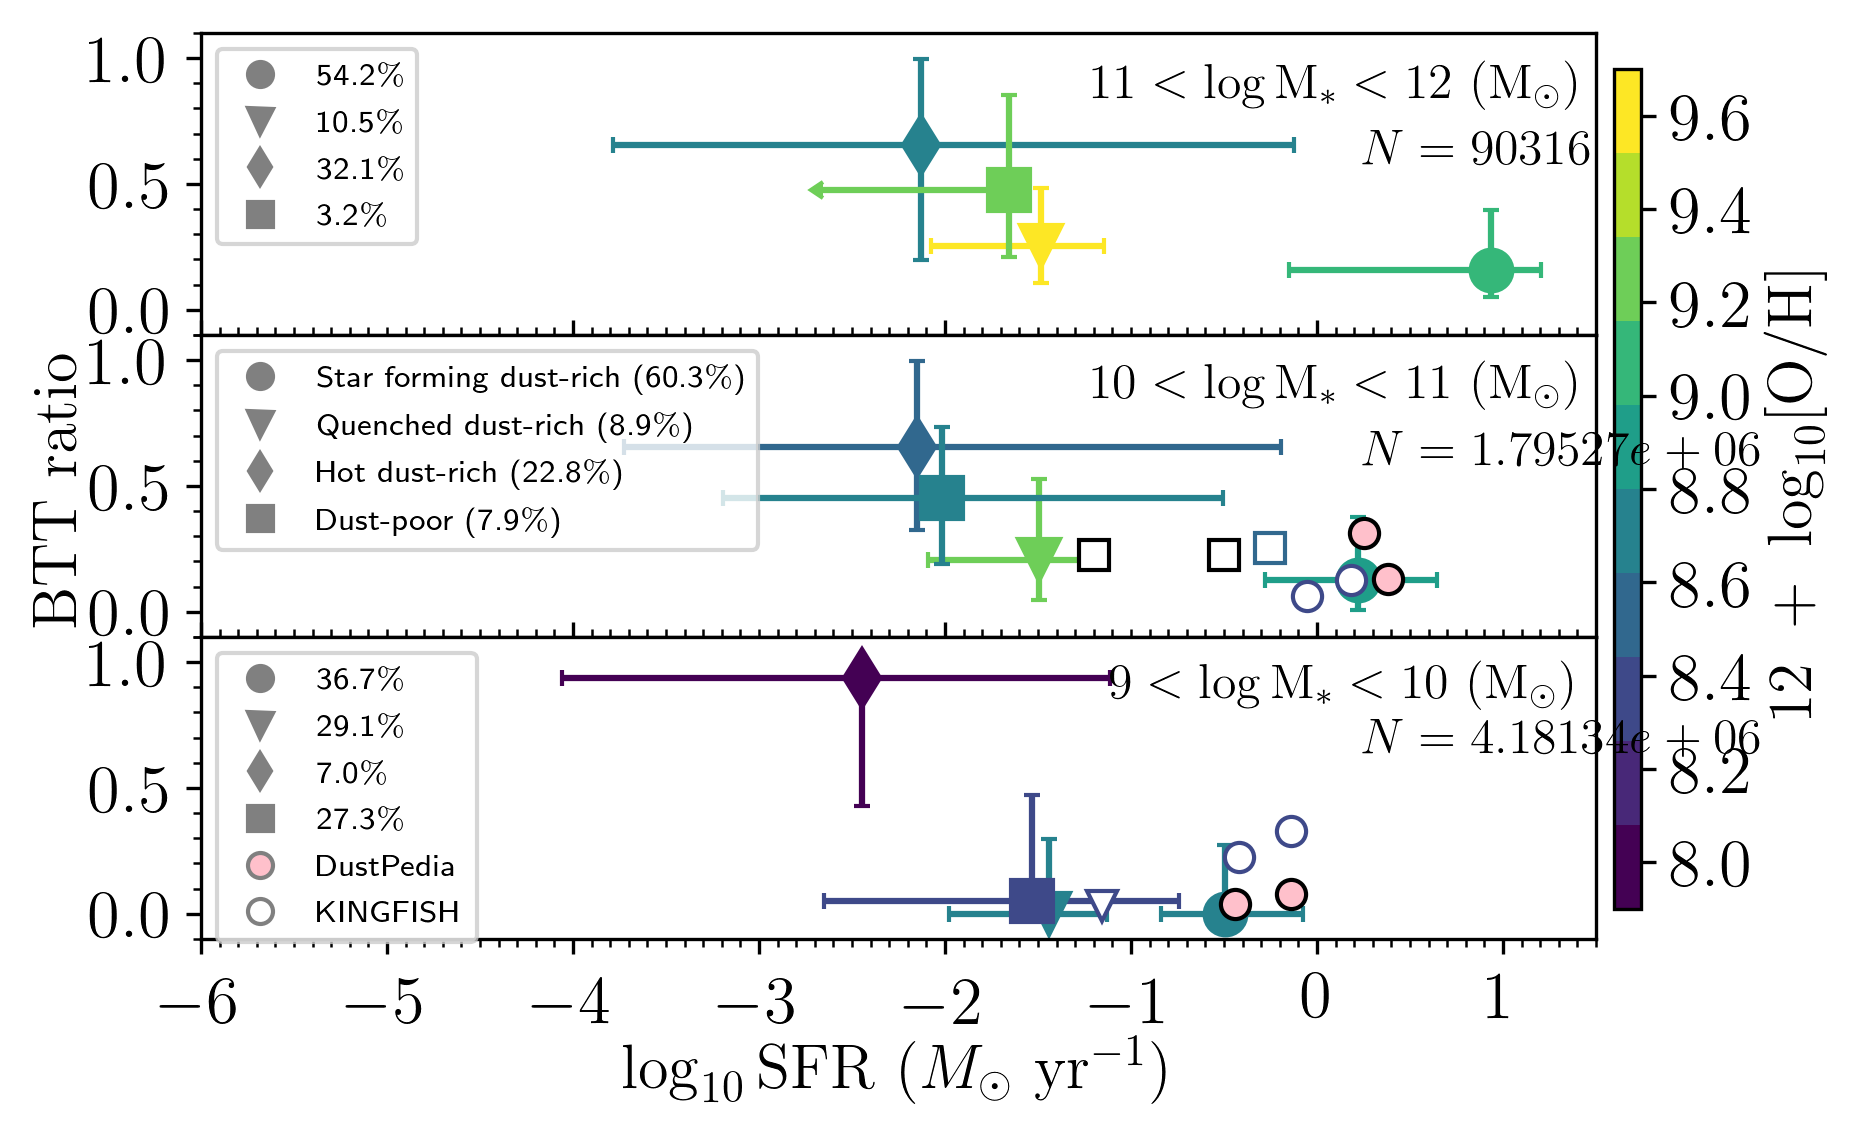

In [15]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

w = np.where((G_history[0].MetalsColdGas > 0) & ( G_history[0].ColdGas / (G_history[0].StellarMass + G_history[0].ColdGas) > 0.0))[0]

stellarmass = G_history[0].StellarMass[w] * 1.e10 / Hubble_h
all_bulge = G_history[0].BulgeMass[w] * 1.e10 / Hubble_h
all_metals = np.log10((G_history[0].MetalsColdGas[w] / G_history[0].ColdGas[w]) / 0.02) + 9.0
all_btt = all_bulge /stellarmass
all_hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
all_cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
all_ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
all_sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])

N=10
cm=plt.get_cmap('viridis', N)
norm=Normalize(vmin = 7.9, vmax=9.7)


#============================================================
#DustPedia Dataset (Nersesian et al. 2019)
SFR_obs = np.array([-1.2, -0.5, 0.25, 0.38, -0.14, -0.44])
Mstar_obs = np.array([10.92, 10.52, 10.58, 10.42, 9.7, 9.14])
Mdust_obs = np.array([6.33, 6.38, 7, 7.28, 6.84, 6.07])
T_obs = [-4.71, -1.57, 1.44, 4.06, 6.68, 9.65]
logBD_obs = np.array([-0.54, -0.54, -0.34, -0.82, -1.06, -1.39])
BD_obs = 10**logBD_obs
BT_obs = BD_obs/(BD_obs+1)
'''
SFR_obs = np.array([-1.27, -1.05, -0.59, -0.61, -0.36, -0.4, 0.03, 0.42, 0.36, 0.47, 0.31, -0.05, -0.14, -0.56, -0.14, -0.77])
Mstar_obs = np.array([10.92, 10.94, 10.35, 10.48, 10.46, 10.74, 10.65, 10.48, 10.55, 10.4, 10.28, 9.83, 9.62, 9.27, 9.24, 9.08])
Mdust_obs = np.array([6.15, 6.6, 5.95, 6.12, 6.46, 6.74, 7, 7.01, 7.23, 7.31, 7.29, 6.94, 6.81, 6.46, 6.25, 5.93])
T_obs = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]
logBD_obs = np.array([-0.54, -0.54, -0.54, -0.54, -0.54, -0.31, -0.34, -0.54, -0.6, -0.82, -1.06, -1.23, -1.06, -1.49, -1.57, -1.39])
BD_obs = 10**logBD_obs
BT_obs = BD_obs/(BD_obs+1)
'''
#============================================================
#Remy-Ruyer et al. 2014

Z_rr, logdust_g_rr, logdust_ac_rr, logstar_rr, sfr_rr, category_rr, logBD_rr  = np.loadtxt('kingfish.txt', usecols=(3, 7, 9, 10, 11, 13, 14), unpack=True)

Mdust_rr = np.zeros(len(np.unique(category_rr)))
Mstar_rr = np.zeros(len(np.unique(category_rr)))
SFR_rr = np.zeros(len(np.unique(category_rr)))
metallicity_rr = np.zeros(len(np.unique(category_rr)))
BT_rr = np.zeros(len(np.unique(category_rr)))
#We are dividing galaxies in Remy-Ruyer 2014 samples based on their morphology:
#a.E b.S0 c.Sa-Sab d.Sb-Sc e.Scd=Sdm f.Sm-Irr

w = np.where(sfr_rr > 0.0)[0]
Z = Z_rr[w]
logdust = logdust_ac_rr[w]
logstar = logstar_rr[w]
logsfr = np.log10(sfr_rr[w])
category = category_rr[w]
logBD = logBD_rr[w]

for i in np.arange(1,7,1):
    w = np.where((category == i) & (logstar > 9))[0]
    #print(i)
    Mdust_rr[i-1] = mean(logdust[w])
    Mstar_rr[i-1] = mean(logstar[w])
    SFR_rr[i-1] = mean(logsfr[w])
    metallicity_rr[i-1] = mean(Z[w])
    BD_a = 10 ** mean(logBD[w])
    BT_rr[i-1] = BD_a/(BD_a+1)
    
#============================================================

fig, axes = plt.subplots(3, 1, sharex=True)

ax = plt.subplot(311)
ax.set_xticklabels([])

w = np.where((stellarmass > 1e11) & (stellarmass < 1e12))[0]
metals = all_metals[w]
btt = all_btt[w]
hot = all_hot[w]
cold = all_cold[w]
ejected = all_ejected[w]
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = all_sfr[w]
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1.0))
btt_a = btt[w]
sfr_a = sfr[w]
metals_a = metals[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
med_metals_a = np.median(metals_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))
btt_b = btt[w]
sfr_b = sfr[w]
metals_b = metals[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
med_metals_b = np.median(metals_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))[0]
btt_c = btt[w]
sfr_c = sfr[w]
metals_c = metals[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
med_metals_c = np.median(metals_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
metals_d = metals[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
med_metals_d = np.median(metals_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)

print(med_sfr_d, low_sfr_d, up_sfr_d)
for i in range(len(xerr)):
    if xerr[i] > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 1.0
        
for i in range(len(yerr)):
    if yerr[i] > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 1.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT_a = NA + NB + NC + ND

A = NA / NT_a * 100
B = NB / NT_a * 100
C = NC / NT_a * 100
D = ND / NT_a * 100

med_sfr = np.array([med_sfr_a, med_sfr_b, med_sfr_c, up_sfr_d])
med_btt = np.array([med_btt_a, med_btt_b, med_btt_c, med_btt_d])
med_metals = np.array([med_metals_a, med_metals_b, med_metals_c, med_metals_d])
yerr_low=np.array([yerr[0], yerr[2], yerr[4], yerr[6]])
yerr_up=np.array([yerr[1], yerr[3], yerr[5], yerr[7]])
xerr_low=np.array([xerr[0], xerr[2], xerr[4], xerr[6]])
xerr_up=np.array([xerr[1], xerr[3], xerr[5], xerr[7]])

print("min med_metals1=", min(med_metals), " max med_metals1=", max(med_metals))
percentage = np.array([A, B, C, D])
colors = np.array(['black', 'blue', 'red', 'green'])
xuplim = [0,0,0,1]

markers=('o', 'v', 'd', 's')

color_a =cm(norm(med_metals_a))
color_b =cm(norm(med_metals_b))
color_c =cm(norm(med_metals_c))
color_d =cm(norm(med_metals_d))
handles=[]

#sc = plt.scatter(med_sfr, med_btt, c=med_metals, s=percentage*5, marker='.', cmap=cm, zorder=10)
#clb = colorbar(ax=ax)

ax.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color=color_a, fmt='o', markersize=10,
            label="%.1f" % A + '$\%$')
ax.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color=color_b, fmt='v', markersize=10,
            label="%.1f" % B + '$\%$')
ax.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]), markersize=10,
         xerr=([xerr[4]], [xerr[5]]), color=color_c, fmt='d',
            label="%.1f" % C + '$\%$')
ax.errorbar(up_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([1], [xerr[7]]), xuplims=1, color=color_d, fmt='s', markersize=10,
            label="%.1f" % D + '$\%$')

# get handles
handles, labels = ax.get_legend_handles_labels()

handles2 = [copy.copy(h[0]) for h in handles]

for h in handles2:
    h.set_color("grey")
    h.set_markersize(6.0)
    
ax.legend(handles2, labels, loc='upper left',prop={'size': 7.5})

plt.xlim(-6, 1.5)
plt.ylim(-0.1, 1.1)

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([0, 0.5, 1])
ax.tick_params(axis='x',which='both',direction='in')



#============================================================

ax = plt.subplot(312)
ax.set_xticklabels([])
w = np.where((stellarmass > 1e10) & (stellarmass < 1e11))[0]
metals = all_metals[w]
btt = all_btt[w]
hot = all_hot[w]
cold = all_cold[w]
ejected = all_ejected[w]
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = all_sfr[w]
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1.0))
btt_a = btt[w]
sfr_a = sfr[w]
metals_a = metals[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
med_metals_a = np.median(metals_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))
btt_b = btt[w]
sfr_b = sfr[w]
metals_b = metals[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
med_metals_b = np.median(metals_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))[0]
btt_c = btt[w]
sfr_c = sfr[w]
metals_c = metals[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
med_metals_c = np.median(metals_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
metals_d = metals[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
med_metals_d = np.median(metals_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)

print(med_sfr_d, low_sfr_d, up_sfr_d)
for i in range(len(xerr)):
    if xerr[i] > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 1.0
        
for i in range(len(yerr)):
    if yerr[i] > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 1.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT_b = NA + NB + NC + ND

A = NA / NT_b * 100
B = NB / NT_b * 100
C = NC / NT_b * 100
D = ND / NT_b * 100

med_sfr = np.array([med_sfr_a, med_sfr_b, med_sfr_c, up_sfr_d])
med_btt = np.array([med_btt_a, med_btt_b, med_btt_c, med_btt_d])
med_metals = np.array([med_metals_a, med_metals_b, med_metals_c, med_metals_d])
yerr_low=np.array([yerr[0], yerr[2], yerr[4], yerr[6]])
yerr_up=np.array([yerr[1], yerr[3], yerr[5], yerr[7]])
xerr_low=np.array([xerr[0], xerr[2], xerr[4], xerr[6]])
xerr_up=np.array([xerr[1], xerr[3], xerr[5], xerr[7]])

print("min med_metals2=", min(med_metals), " max med_metals2=", max(med_metals)) 

percentage = np.array([A, B, C, D])
colors = np.array(['black', 'blue', 'red', 'green'])
xuplim = [0,0,0,1]

markers=('o', 'v', 'd', 's')

color_a =cm(norm(med_metals_a))
color_b =cm(norm(med_metals_b))
color_c =cm(norm(med_metals_c))
color_d =cm(norm(med_metals_d))
handles=[]

#sc = plt.scatter(med_sfr, med_btt, c=med_metals, s=percentage*5, marker='.', cmap=cm, zorder=10)
#clb = colorbar(ax=ax)

ax.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color=color_a, fmt='o', markersize=10,
            label="Star forming dust-rich (%.1f" % A + '$\%$)')
ax.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color=color_b, fmt='v', markersize=10,
            label="Quenched dust-rich (%.1f" % B + '$\%$)')
ax.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]), markersize=10,
         xerr=([xerr[4]], [xerr[5]]), color=color_c, fmt='d',
            label="Hot dust-rich (%.1f" % C + '$\%$)')
ax.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color=color_d, fmt='s', markersize=10,
            label="Dust-poor (%.1f" % D + '$\%$)')

#Plot Dustpedia dataset
w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs > -1))[0]
print(len(w))
SFR_obs_a = SFR_obs[w]
BT_obs_a = BT_obs[w]
plt.errorbar(SFR_obs_a, BT_obs_a, fmt='ko', markersize=7, mfc='pink')

w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs < -1))[0]
SFR_obs_b = SFR_obs[w]
BT_obs_b = BT_obs[w]
plt.errorbar(SFR_obs_b, BT_obs_b, fmt='kv', markersize=7, mfc='pink')

w = np.where((Mstar_obs > 10) & (Mstar_obs - Mdust_obs > 4))[0]
print(len(w))
SFR_obs_d = SFR_obs[w]
BT_obs_d = BT_obs[w]
plt.errorbar(SFR_obs_d, BT_obs_d, fmt='ks', markersize=7, mfc='white')

#Plot Remy-Ruyer dataset
w = np.where((Mstar_rr > 10) & (Mstar_rr - Mdust_rr < 4) & (SFR_rr > -1))[0]
print(w, Mstar_rr[w], Mdust_rr[w], metallicity_rr[w])
SFR_rr_a = SFR_rr[w]
BT_rr_a = BT_rr[w]
metal_color = np.median(metallicity_rr[w])
color_rr_a = cm(norm(metal_color))
plt.errorbar(SFR_rr_a, BT_rr_a, color=color_rr_a, fmt='o', markersize=7, mfc='white')


w = np.where((Mstar_rr > 10) & (Mstar_rr - Mdust_rr > 4))[0]
SFR_rr_d = SFR_rr[w]
BT_rr_d = BT_rr[w]
metal_color = np.median(metallicity_rr[w])
color_rr_d = cm(norm(metal_color))
plt.errorbar(SFR_rr_d, BT_rr_d, color=color_rr_d, fmt='s', markersize=7, mfc='white')


# get handles
handles, labels = ax.get_legend_handles_labels()

handles2 = [copy.copy(h[0]) for h in handles]

for h in handles2:
    h.set_color("grey")
    h.set_markersize(6.0)

leg = ax.legend(handles2, labels, loc='upper left', prop={'size': 7.5})

plt.xlim(-6, 1.5)
plt.ylim(-0.1, 1.1)

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([0, 0.5, 1])
ax.tick_params(axis='x',which='both',direction='in')

#============================================================

ax = plt.subplot(313)

w = np.where((stellarmass > 1e9) & (stellarmass < 1e10))[0]
metals = all_metals[w]
btt = all_btt[w]
hot = all_hot[w]
cold = all_cold[w]
ejected = all_ejected[w]
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = all_sfr[w]
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1.0))
btt_a = btt[w]
sfr_a = sfr[w]
metals_a = metals[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
med_metals_a = np.median(metals_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1.0))
btt_b = btt[w]
sfr_b = sfr[w]
metals_b = metals[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
med_metals_b = np.median(metals_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))[0]
btt_c = btt[w]
sfr_c = sfr[w]
metals_c = metals[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
med_metals_c = np.median(metals_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
metals_d = metals[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
med_metals_d = np.median(metals_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)

print(med_sfr_d, low_sfr_d, up_sfr_d)
for i in range(len(xerr)):
    if xerr[i] > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 1.0
        
for i in range(len(yerr)):
    if yerr[i] > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 1.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT_c = NA + NB + NC + ND

A = NA / NT_c * 100
B = NB / NT_c * 100
C = NC / NT_c * 100
D = ND / NT_c * 100

med_sfr = np.array([med_sfr_a, med_sfr_b, med_sfr_c, up_sfr_d])
med_btt = np.array([med_btt_a, med_btt_b, med_btt_c, med_btt_d])
med_metals = np.array([med_metals_a, med_metals_b, med_metals_c, med_metals_d])
yerr_low=np.array([yerr[0], yerr[2], yerr[4], yerr[6]])
yerr_up=np.array([yerr[1], yerr[3], yerr[5], yerr[7]])
xerr_low=np.array([xerr[0], xerr[2], xerr[4], xerr[6]])
xerr_up=np.array([xerr[1], xerr[3], xerr[5], xerr[7]])

print("min med_metals3=", min(med_metals), " max med_metals3=", max(med_metals))


percentage = np.array([A, B, C, D])
colors = np.array(['black', 'blue', 'red', 'green'])
xuplim = [0,0,0,1]

markers=('o', 'v', 'd', 's')

color_a =cm(norm(med_metals_a))
color_b =cm(norm(med_metals_b))
color_c =cm(norm(med_metals_c))
color_d =cm(norm(med_metals_d))
handles=[]

#sc = plt.scatter(med_sfr, med_btt, c=med_metals, s=percentage*5, marker='.', cmap=cm, zorder=10)
#clb = colorbar(ax=ax)

ax.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color=color_a, fmt='o', markersize=10,
            label="%.1f" % A + '$\%$')
ax.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color=color_b, fmt='v', markersize=10,
            label="%.1f" % B + '$\%$')
ax.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]), markersize=10,
         xerr=([xerr[4]], [xerr[5]]), color=color_c, fmt='d',
            label="%.1f" % C + '$\%$')
ax.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color=color_d, fmt='s', markersize=10,
            label="%.1f" % D + '$\%$')

#Plot DustPedia dataset
w = np.where((Mstar_obs > 9) & (Mstar_obs < 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs > -1))[0]
print(len(w))
SFR_obs_a = SFR_obs[w]
BT_obs_a = BT_obs[w]
plt.errorbar(SFR_obs_a, BT_obs_a, fmt='ko', markersize=7, mfc='pink', label='DustPedia')

w = np.where((Mstar_obs > 9) & (Mstar_obs < 10) & (Mstar_obs - Mdust_obs < 4) & (SFR_obs < -1))[0]
print(len(w))
SFR_obs_b = SFR_obs[w]
BT_obs_b = BT_obs[w]
plt.errorbar(SFR_obs_b, BT_obs_b, fmt='kv', markersize=7, mfc='pink')

w = np.where((Mstar_obs > 9) & (Mstar_obs < 10)& (Mstar_obs - Mdust_obs > 4))[0]
print(len(w))
SFR_obs_c = SFR_obs[w]
BT_obs_c = BT_obs[w]
plt.errorbar(SFR_obs_c, BT_obs_c, fmt='ks', markersize=7, mfc='white')

#Plot Remy-Ruyer dataset
w = np.where((Mstar_rr > 9) & (Mstar_rr < 10) & (Mstar_rr - Mdust_rr < 4) & (SFR_rr > -1))[0]
SFR_rr_a = SFR_rr[w]
BT_rr_a = BT_rr[w]
metal_color = np.median(metallicity_rr[w])
color_rr_a = cm(norm(metal_color))
plt.errorbar(SFR_rr_a, BT_rr_a, color=color_rr_a, fmt='o', markersize=7, mfc='white', label="KINGFISH")

w = np.where((Mstar_rr > 9) & (Mstar_rr < 10) & (Mstar_rr - Mdust_rr < 4) & (SFR_rr < -1))[0]
SFR_rr_b = SFR_rr[w]
BT_rr_b = BT_rr[w]
metal_color = np.median(metallicity_rr[w])
color_rr_b = cm(norm(metal_color))
plt.errorbar(SFR_rr_b, BT_rr_b, color=color_rr_b, fmt='v', markersize=7, mfc='white')


w = np.where((Mstar_rr > 9) & (Mstar_rr < 10) & (Mstar_rr - Mdust_rr > 4))[0]
SFR_rr_d = SFR_rr[w]
BT_rr_d = BT_rr[w]
metal_color = np.median(metallicity_rr[w])
color_rr_d = cm(norm(metal_color))
plt.errorbar(SFR_rr_d, BT_rr_d, color=color_rr_d, fmt='s', markersize=7)


# get handles
handles, labels = ax.get_legend_handles_labels()

handles2 = [copy.copy(h[0]) for h in handles]

for h in handles2:
    h.set_color("grey")
    h.set_markersize(6.0)

leg = ax.legend(handles2, labels, loc='upper left',prop={'size': 7.5})

plt.xlim(-6, 1.5)
plt.ylim(-0.1, 1.1)

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([0, 0.5, 1])
plt.xticks([-6, -5, -4, -3, -2, -1, 0, 1])

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel(r'$\log_{10} \mathrm{SFR}\ (M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=15)
fig.text(0.03, 0.5, r'$\mathrm{BTT}\ \mathrm{ratio}$', fontsize=15, va='center', rotation='vertical')
fig.text(0.63, 0.32, r'$9 <\log \mathrm{M_*}<10\ (\mathrm{M_\odot})$')
fig.text(0.77, 0.28, r'$N = {:g}$'.format(NT_c))
fig.text(0.62, 0.57, r'$10 <\log \mathrm{M_*}<11\ (\mathrm{M_\odot})$')
fig.text(0.77, 0.52, r'$N = {:g}$'.format(NT_b))
fig.text(0.62, 0.82, r'$11 <\log \mathrm{M_*}<12\ (\mathrm{M_\odot})$')
fig.text(0.77, 0.77, r'$N = {:g}$'.format(NT_a))

#added colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)
fig.text(1.0, 0.5, r'$12\ +\ \log_{10}[\mathrm{O/H}]$', fontsize=15, va='center', rotation='vertical')

#plt.savefig('plots/btt-sfr-Z-play2.png', bbox_inches='tight')

## BTT - SFR - Metallicity evolution

/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in true_divide
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in greater
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-

8.760127 9.796988


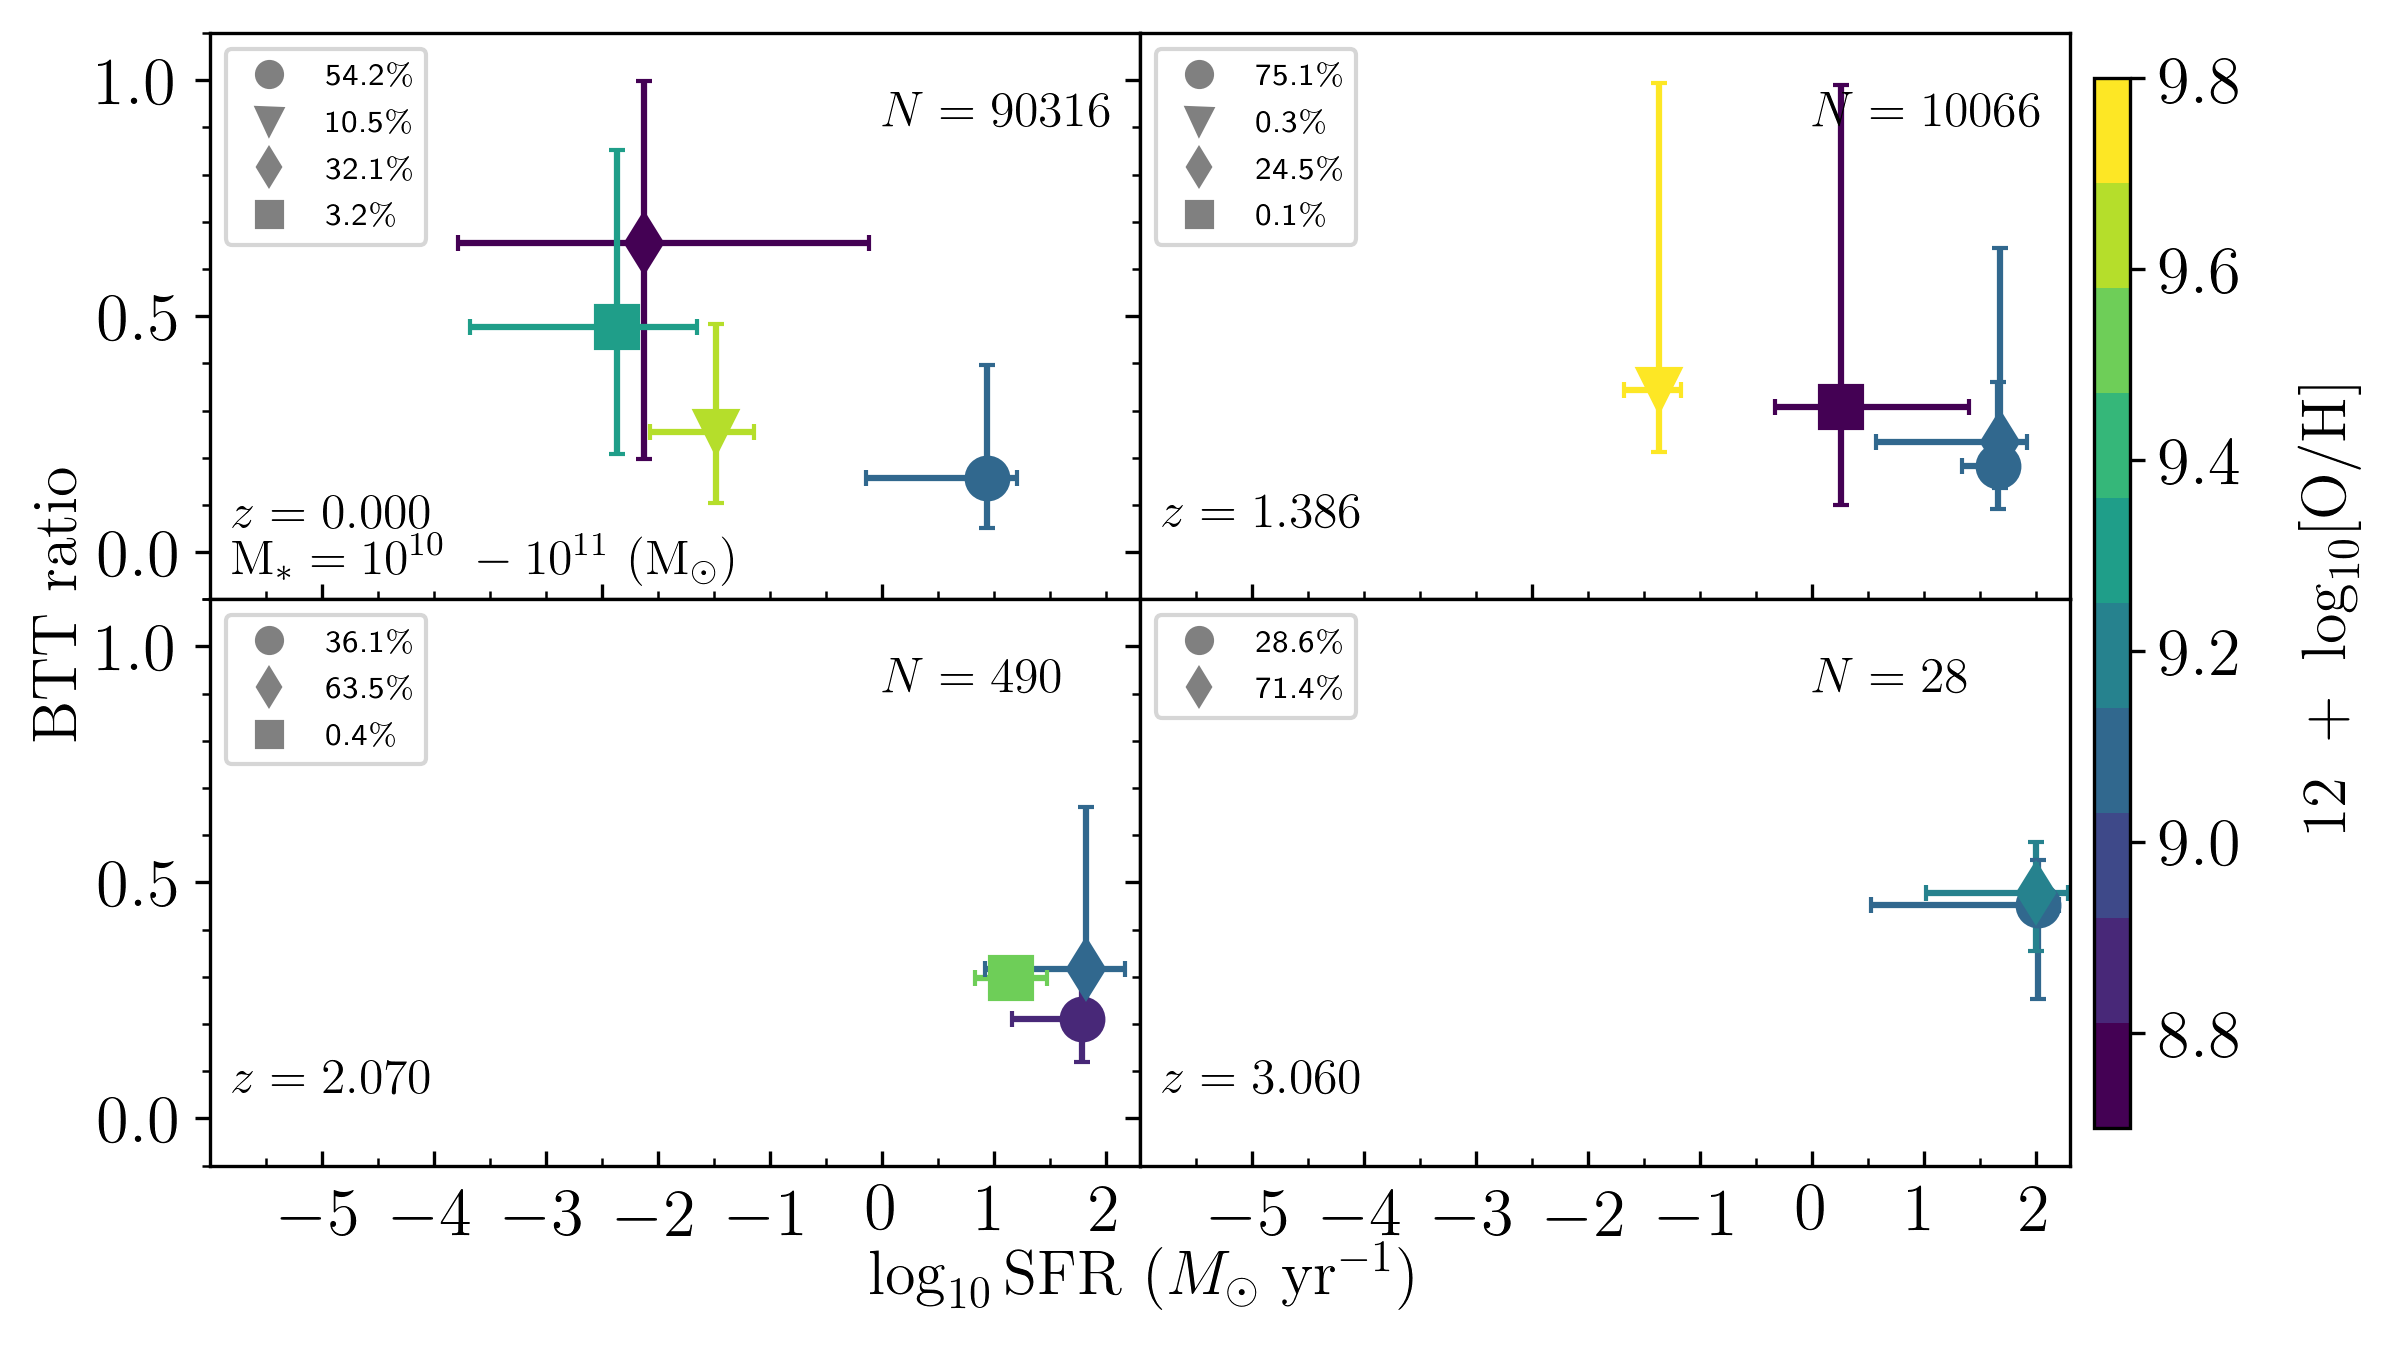

In [14]:
N=10
cm=plt.get_cmap('viridis', N)
norm=Normalize(vmin = 8.7, vmax=9.8)

med_metals = []

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 5))

ax = plt.subplot(221)
ax.set_xticklabels([])

w = np.where((G_history[0].MetalsColdGas > 0) & ( G_history[0].ColdGas / (G_history[0].StellarMass + G_history[0].ColdGas) > 0.0))[0]

stellarmass = G_history[0].StellarMass[w] * 1.e10 / Hubble_h
all_bulge = G_history[0].BulgeMass[w] * 1.e10 / Hubble_h
all_metals = np.log10((G_history[0].MetalsColdGas[w] / G_history[0].ColdGas[w]) / 0.02) + 9.0
all_btt = all_bulge /stellarmass
all_hot = G_history[0].HotDust[w] * 1.e10 / Hubble_h
all_cold = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
all_ejected = G_history[0].EjectedDust[w] * 1.e10 / Hubble_h
all_sfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])


w = np.where((stellarmass>1e11) & (stellarmass<1e12))[0]
metals = all_metals[w]
btt = all_btt[w]
hot = all_hot[w]
cold = all_cold[w]
ejected = all_ejected[w]
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = all_sfr[w]
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1))
btt_a = btt[w]
sfr_a = sfr[w]
metals_a = metals[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
med_metals_a = np.median(metals_a)
med_metals.append(med_metals_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1))
btt_b = btt[w]
sfr_b = sfr[w]
metals_b = metals[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
med_metals_b = np.median(metals_b)
med_metals.append(med_metals_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
metals_c = metals[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
med_metals_c = np.median(metals_c)
med_metals.append(med_metals_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))
btt_d = btt[w]
sfr_d = sfr[w]
metals_d = metals[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
med_metals_d = np.median(metals_d)
med_metals.append(med_metals_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT_a = NA + NB + NC + ND

A = NA / NT_a * 100
B = NB / NT_a * 100
C = NC / NT_a * 100
D = ND / NT_a * 100

color_a =cm(norm(med_metals_a))
color_b =cm(norm(med_metals_b))
color_c =cm(norm(med_metals_c))
color_d =cm(norm(med_metals_d))
handles=[]

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color=color_a, fmt='o',markersize=10,
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color=color_b, fmt='v',markersize=10,
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color=color_c, fmt='d',markersize=10,
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color=color_d, fmt='s',markersize=10,
            label="%.1f" % D + '$\%$')

# get handles
handles, labels = ax.get_legend_handles_labels()

handles2 = [copy.copy(h[0]) for h in handles]

for h in handles2:
    h.set_color("grey")
    h.set_markersize(6.0)
    
ax.legend(handles2, labels, loc='upper left',prop={'size': 7.5})

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([0, 0.5, 1])
ax.tick_params(axis='x',which='both',direction='in')

plt.text(0.0, 0.9, r'$N = {:d}$'.format(NT_a))
plt.text(-5.8, 0.05, r'$z=0.000$')
plt.text(-5.8, -0.06, r'$\mathrm{M_*} = 10^{10}\ - 10^{11}\ (\mathrm{M_\odot})$')

#------------------------------------------------------------------------------
ax = plt.subplot(222)
ax.set_xticklabels([])
ax.set_yticklabels([])

w = np.where((G_history[1].MetalsColdGas > 0) & ( G_history[1].ColdGas / (G_history[1].StellarMass + G_history[1].ColdGas) > 0.0))[0]

stellarmass = G_history[1].StellarMass[w] * 1.e10 / Hubble_h
all_bulge = G_history[1].BulgeMass[w] * 1.e10 / Hubble_h
all_metals = np.log10((G_history[1].MetalsColdGas[w] / G_history[1].ColdGas[w]) / 0.02) + 9.0
all_btt = all_bulge /stellarmass
all_hot = G_history[1].HotDust[w] * 1.e10 / Hubble_h
all_cold = G_history[1].ColdDust[w] * 1.e10 / Hubble_h
all_ejected = G_history[1].EjectedDust[w] * 1.e10 / Hubble_h
all_sfr = np.log10(G_history[1].SfrDisk[w] + G_history[1].SfrBulge[w])

w = np.where((stellarmass>1e11) & (stellarmass<1e12))[0]
metals = all_metals[w]
btt = all_btt[w]
hot = all_hot[w]
cold = all_cold[w]
ejected = all_ejected[w]
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = all_sfr[w]
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1))
btt_a = btt[w]
sfr_a = sfr[w]
metals_a = metals[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
med_metals_a = np.median(metals_a)
med_metals.append(med_metals_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)

#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1))
btt_b = btt[w]
sfr_b = sfr[w]
metals_b = metals[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
med_metals_b = np.median(metals_b)
med_metals.append(med_metals_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)

#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
metals_c = metals[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
med_metals_c = np.median(metals_c)
med_metals.append(med_metals_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))
btt_d = btt[w]
sfr_d = sfr[w]
metals_d = metals[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
med_metals_d = np.median(metals_d)
med_metals.append(med_metals_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
NB = len(btt_b)
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

color_a =cm(norm(med_metals_a))
color_b =cm(norm(med_metals_b))
color_c =cm(norm(med_metals_c))
color_d =cm(norm(med_metals_d))
handles=[]

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color=color_a, fmt='o',markersize=10,
            label="%.1f" % A + '$\%$')
plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color=color_b, fmt='v',markersize=10,
            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), color=color_c, fmt='d',markersize=10,
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color=color_d, fmt='s',markersize=10,
            label="%.1f" % D + '$\%$')

# get handles
handles, labels = ax.get_legend_handles_labels()

handles2 = [copy.copy(h[0]) for h in handles]

for h in handles2:
    h.set_color("grey")
    h.set_markersize(6.0)
    
ax.legend(handles2, labels, loc='upper left',prop={'size': 7.5})

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)


ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([0, 0.5, 1])
ax.tick_params(axis='x',which='both',direction='in')

plt.text(0.0, 0.9, r'$N = {:d}$'.format(NT))
plt.text(-5.8, 0.05, r'$z=1.386$')
#------------------------------------------------------------------------------

ax = plt.subplot(223)

w = np.where((G_history[2].MetalsColdGas > 0) & ( G_history[2].ColdGas / (G_history[2].StellarMass + G_history[2].ColdGas) > 0.0))[0]

stellarmass = G_history[2].StellarMass[w] * 1.e10 / Hubble_h
all_bulge = G_history[2].BulgeMass[w] * 1.e10 / Hubble_h
all_metals = np.log10((G_history[2].MetalsColdGas[w] / G_history[2].ColdGas[w]) / 0.02) + 9.0
all_btt = all_bulge /stellarmass
all_hot = G_history[2].HotDust[w] * 1.e10 / Hubble_h
all_cold = G_history[2].ColdDust[w] * 1.e10 / Hubble_h
all_ejected = G_history[2].EjectedDust[w] * 1.e10 / Hubble_h
all_sfr = np.log10(G_history[2].SfrDisk[w] + G_history[2].SfrBulge[w])

w = np.where((stellarmass>1e11) & (stellarmass<1e12))[0]
metals = all_metals[w]
btt = all_btt[w]
hot = all_hot[w]
cold = all_cold[w]
ejected = all_ejected[w]
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = all_sfr[w]
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1))
btt_a = btt[w]
sfr_a = sfr[w]
metals_a = metals[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
med_metals_a = np.median(metals_a)
med_metals.append(med_metals_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)
'''
#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1))
btt_b = btt[w]
sfr_b = sfr[w]
metals_b = metals[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
med_metals_b = np.median(metals_b)
med_metals.append(med_metals_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)
'''
#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
metals_c = metals[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
med_metals_c = np.median(metals_c)
med_metals.append(med_metals_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)

#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))
btt_d = btt[w]
sfr_d = sfr[w]
metals_d = metals[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
med_metals_d = np.median(metals_d)
med_metals.append(med_metals_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)


for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
#NB = len(btt_b)
NB=0
NC = len(btt_c)
ND = len(btt_d)
NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

color_a =cm(norm(med_metals_a))
color_b =cm(norm(med_metals_b))
color_c =cm(norm(med_metals_c))
color_d =cm(norm(med_metals_d))
handles=[]

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color=color_a, fmt='o',markersize=10,
            label="%.1f" % A + '$\%$')
#plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
#         xerr=([xerr[2]], [xerr[3]]), color=color_b, fmt='v',markersize=10,
#            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color=color_c, fmt='d',markersize=10,
            label="%.1f" % C + '$\%$')
plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[4]], [yerr[5]]),
         xerr=([xerr[4]], [xerr[5]]), xuplims=0, color=color_d, fmt='s',markersize=10,
            label="%.1f" % D + '$\%$')

# get handles
handles, labels = ax.get_legend_handles_labels()

handles2 = [copy.copy(h[0]) for h in handles]

for h in handles2:
    h.set_color("grey")
    h.set_markersize(6.0)
    
ax.legend(handles2, labels, loc='upper left',prop={'size': 7.5})

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([0, 0.5, 1])
ax.tick_params(axis='x',which='both',direction='in')
plt.xticks([-5, -4, -3, -2, -1, 0, 1, 2])

plt.text(0.0, 0.9, r'$N = {:g}$'.format(NT))
plt.text(-5.8, 0.05, r'$z=2.070$')

#------------------------------------------------------------------------------

ax = plt.subplot(224)
plt.subplot(224).set_yticklabels([])

w = np.where((G_history[3].MetalsColdGas > 0) & ( G_history[3].ColdGas / (G_history[3].StellarMass + G_history[3].ColdGas) > 0.0))[0]

stellarmass = G_history[3].StellarMass[w] * 1.e10 / Hubble_h
all_bulge = G_history[3].BulgeMass[w] * 1.e10 / Hubble_h
all_metals = np.log10((G_history[3].MetalsColdGas[w] / G_history[3].ColdGas[w]) / 0.02) + 9.0
all_btt = all_bulge /stellarmass
all_hot = G_history[3].HotDust[w] * 1.e10 / Hubble_h
all_cold = G_history[3].ColdDust[w] * 1.e10 / Hubble_h
all_ejected = G_history[3].EjectedDust[w] * 1.e10 / Hubble_h
all_sfr = np.log10(G_history[3].SfrDisk[w] + G_history[3].SfrBulge[w])

w = np.where((stellarmass>1e11) & (stellarmass<1e12))[0]
metals = all_metals[w]
btt = all_btt[w]
hot = all_hot[w]
cold = all_cold[w]
ejected = all_ejected[w]
total_dust = hot + cold + ejected
dustfrac = cold / stellarmass[w]
hotfrac = hot /stellarmass[w]

sfr = all_sfr[w]
xerr = []
yerr = []

#Class A:
w = np.where((dustfrac > 1e-4) & (sfr > -1))
btt_a = btt[w]
sfr_a = sfr[w]
metals_a = metals[w]
med_sfr_a = np.median(sfr_a)
med_btt_a = np.median(btt_a)
med_metals_a = np.median(metals_a)
med_metals.append(med_metals_a)
low_sfr_a = np.percentile(sfr_a, 16)
low_btt_a = np.percentile(btt_a, 16)
up_sfr_a = np.percentile(sfr_a, 84)
up_btt_a = np.percentile(btt_a, 84)
yerr_low_a = abs(low_btt_a - med_btt_a)
yerr_up_a = abs(up_btt_a - med_btt_a)
yerr.append(yerr_low_a)
yerr.append(yerr_up_a)
xerr_low_a = abs(low_sfr_a - med_sfr_a)
xerr_up_a = abs(up_sfr_a - med_sfr_a)
xerr.append(xerr_low_a)
xerr.append(xerr_up_a)
'''
#Class B:
w = np.where((dustfrac > 1e-4) & (sfr < -1))
btt_b = btt[w]
sfr_b = sfr[w]
metals_b = metals[w]
med_sfr_b = np.median(sfr_b)
med_btt_b = np.median(btt_b)
med_metals_b = np.median(metals_b)
med_metals.append(med_metals_b)
low_sfr_b = np.percentile(sfr_b, 16)
low_btt_b = np.percentile(btt_b, 16)
up_sfr_b = np.percentile(sfr_b, 84)
up_btt_b = np.percentile(btt_b, 84)
yerr_low_b = abs(low_btt_b - med_btt_b)
yerr_up_b = abs(up_btt_b - med_btt_b)
yerr.append(yerr_low_b)
yerr.append(yerr_up_b)
xerr_low_b = abs(low_sfr_b - med_sfr_b)
xerr_up_b = abs(up_sfr_b - med_sfr_b)
xerr.append(xerr_low_b)
xerr.append(xerr_up_b)
'''
#Class C:
w = np.where((dustfrac < 1e-4) & (hotfrac > 1e-4))
btt_c = btt[w]
sfr_c = sfr[w]
metals_c = metals[w]
med_sfr_c = np.median(sfr_c)
med_btt_c = np.median(btt_c)
med_metals_c = np.median(metals_c)
med_metals.append(med_metals_c)
low_sfr_c = np.percentile(sfr_c, 16)
low_btt_c = np.percentile(btt_c, 16)
up_sfr_c = np.percentile(sfr_c, 84)
up_btt_c = np.percentile(btt_c, 84)
yerr_low_c = abs(low_btt_c - med_btt_c)
yerr_up_c = abs(up_btt_c - med_btt_c)
yerr.append(yerr_low_c)
yerr.append(yerr_up_c)
xerr_low_c = abs(low_sfr_c - med_sfr_c)
xerr_up_c = abs(up_sfr_c - med_sfr_c)
xerr.append(xerr_low_c)
xerr.append(xerr_up_c)
'''
#Class D:
w = np.where((dustfrac < 1e-4) & (hotfrac < 1e-4))[0]
btt_d = btt[w]
sfr_d = sfr[w]
metals_d = metals[w]
med_sfr_d = np.median(sfr_d)
med_btt_d = np.median(btt_d)
med_metals_d = np.median(metals_d)
low_sfr_d = np.percentile(sfr_d, 16)
low_btt_d = np.percentile(btt_d, 16)
up_sfr_d = np.percentile(sfr_d, 84)
up_btt_d = np.percentile(btt_d, 84)
yerr_low_d = abs(low_btt_d - med_btt_d)
yerr_up_d = abs(up_btt_d - med_btt_d)
yerr.append(yerr_low_d)
yerr.append(yerr_up_d)
xerr_low_d = abs(low_sfr_d - med_sfr_d)
xerr_up_d = abs(up_sfr_d - med_sfr_d)
xerr.append(xerr_low_d)
xerr.append(xerr_up_d)
'''

for i in range(len(xerr)):
    if abs(np.log10(xerr[i])) > 10:
        print("xerr index=", i, "value=", xerr[i])
        xerr[i] = 5.0
        
for i in range(len(yerr)):
    if abs(np.log10(yerr[i])) > 10:
        print("yerr index=", i, "value=", yerr[i])
        yerr[i] = 5.0
        
NA = len(btt_a)
#NB = len(btt_b)
NB=0
NC = len(btt_c)
#ND = len(btt_d)
ND=0

NT = NA + NB + NC + ND

A = NA / NT * 100
B = NB / NT * 100
C = NC / NT * 100
D = ND / NT * 100

color_a =cm(norm(med_metals_a))
#color_b =cm(norm(med_metals_b))
color_c =cm(norm(med_metals_c))
color_d =cm(norm(med_metals_d))
handles=[]

plt.errorbar(med_sfr_a, med_btt_a, yerr=([yerr[0]], [yerr[1]]),
         xerr=([xerr[0]], [xerr[1]]), color=color_a, fmt='o',markersize=10,
            label="%.1f" % A + '$\%$')
#plt.errorbar(med_sfr_b, med_btt_b, yerr=([yerr[2]], [yerr[3]]),
#         xerr=([xerr[2]], [xerr[3]]), color=color_b, fmt='v',markersize=10,
#            label="%.1f" % B + '$\%$')
plt.errorbar(med_sfr_c, med_btt_c, yerr=([yerr[2]], [yerr[3]]),
         xerr=([xerr[2]], [xerr[3]]), color=color_c, fmt='d',markersize=10,
            label="%.1f" % C + '$\%$')
#plt.errorbar(med_sfr_d, med_btt_d, yerr=([yerr[6]], [yerr[7]]),
#         xerr=([xerr[6]], [xerr[7]]), xuplims=0, color=color_d, fmt='s',markersize=10,
#            label="%.1f" % D + '$\%$')

# get handles
handles, labels = ax.get_legend_handles_labels()

handles2 = [copy.copy(h[0]) for h in handles]

for h in handles2:
    h.set_color("grey")
    h.set_markersize(6.0)
    
ax.legend(handles2, labels, loc='upper left',prop={'size': 7.5})

plt.xlim(-6, 2.3)
plt.ylim(-0.1, 1.1)

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.yticks([0, 0.5, 1])
plt.xticks([-5, -4, -3, -2, -1, 0, 1, 2])
ax.tick_params(axis='x',which='both',direction='in')

plt.text(0.0, 0.9, r'$N = {:d}$'.format(NT))
plt.text(-5.8, 0.05, r'$z=3.060$')

plt.subplots_adjust(wspace=0, hspace=0)

fig.text(0.05, 0.5, r'$\mathrm{BTT}\ \mathrm{ratio}$', fontsize=15, va='center', rotation='vertical')
fig.text(0.4, 0.03, r'$\log_{10} \mathrm{SFR}\ (M_{\odot}\ \mathrm{yr}^{-1})$', fontsize=15)

print(min(med_metals), max(med_metals))

#added colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)
fig.text(1.0, 0.5, r'$12\ +\ \log_{10}[\mathrm{O/H}]$', fontsize=15, va='center', rotation='vertical')

plt.savefig('plots/btt-sfr-evol-massive-testbulge3.png', bbox_inches='tight')

## Violin plot for time since major merger

/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


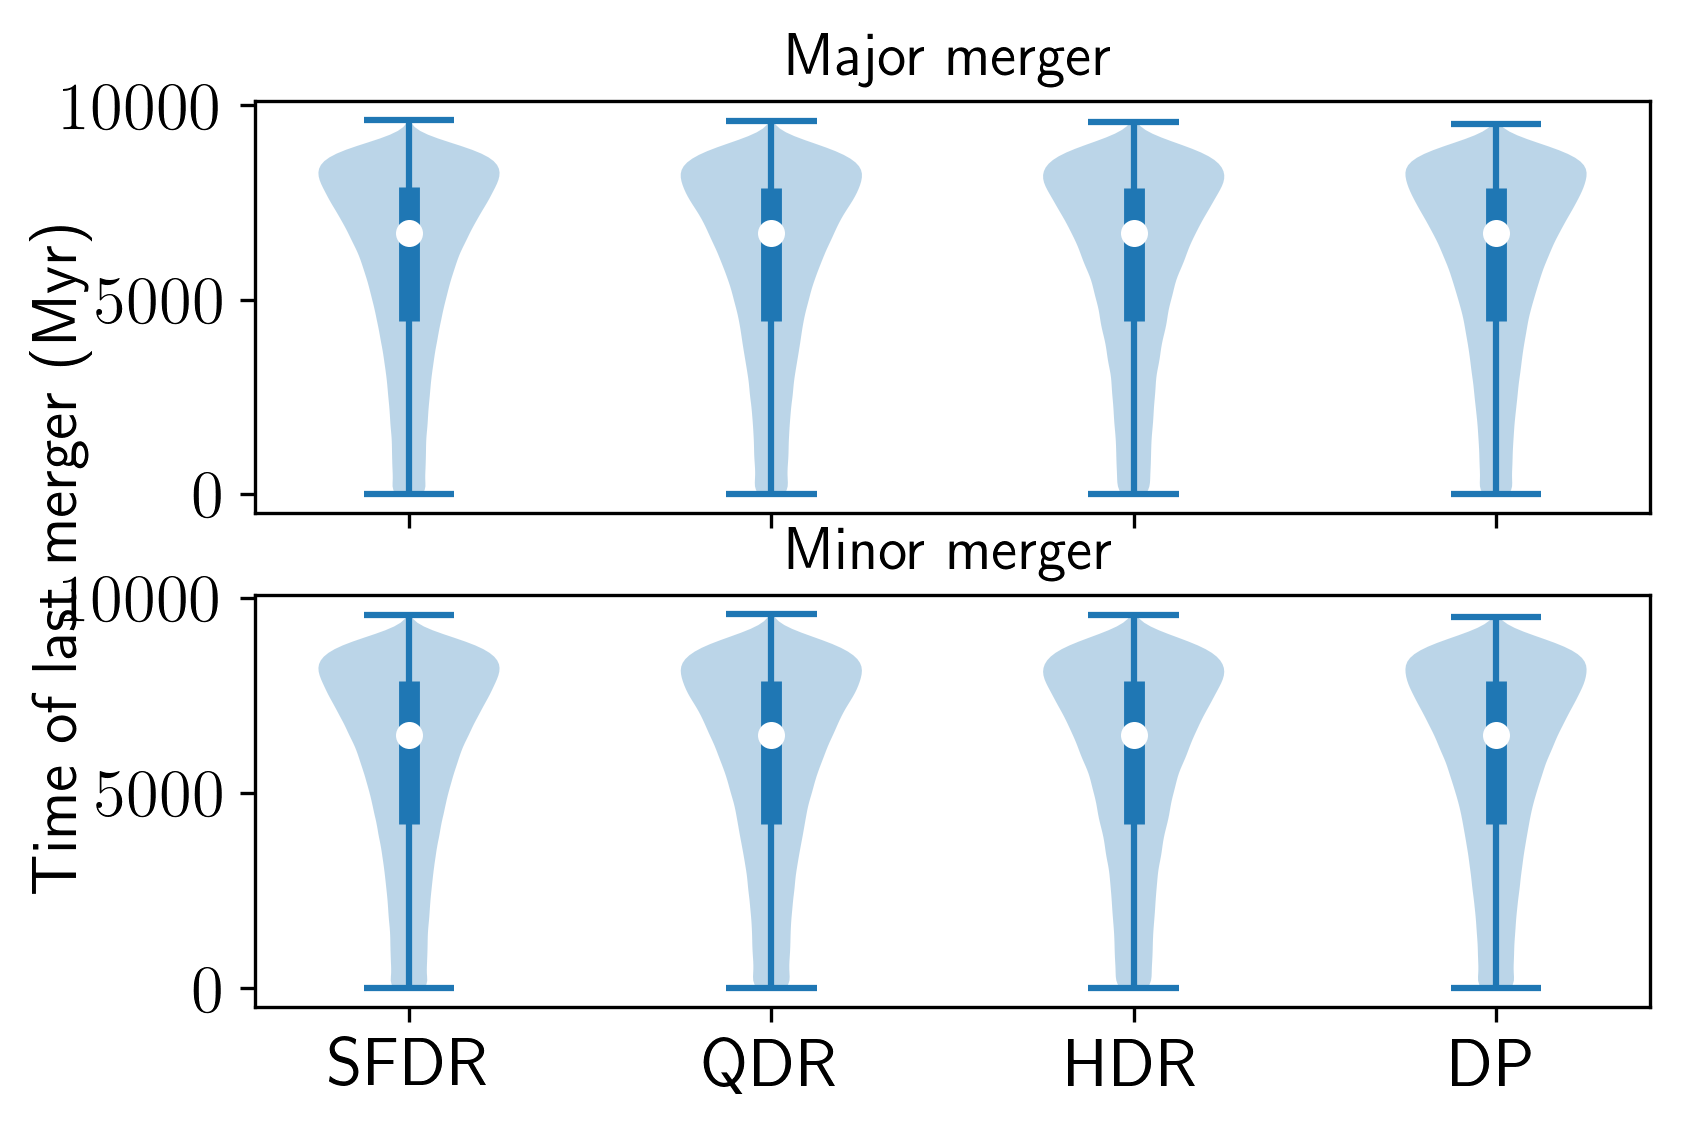

In [16]:
#fig, ax = plt.subplots(111)
w = np.where(G_history[0].StellarMass > 0)[0]
stellarmass = G_history[0].StellarMass[w] * 1.e10 / Hubble_h
allcolddust = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
allhotdust = G_history[0].HotDust[w] * 1.e10 / Hubble_h
allsfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
all_lastmajor = G_history[0].TimeOfLastMajorMerger
all_lastminor = G_history[0].TimeOfLastMinorMerger

w = np.where((stellarmass > 1e9) & (stellarmass < 1e12))[0]
colddust = allcolddust[w]/stellarmass[w]
hotdust = allhotdust[w]/stellarmass[w]
sfr = allsfr[w]
lastmajor = all_lastmajor[w]
lastminor = all_lastminor[w]


#SFDR
w = np.where((colddust > 1e-4) & (sfr > -1) & (lastmajor>0))[0]
major_a = lastmajor[w]

w = np.where((colddust > 1e-4) & (sfr > -1) & (lastminor>0))[0]
minor_a = lastminor[w]

#QDR
w = np.where((colddust > 1e-4) & (sfr < -1) & (lastmajor>0))[0]
major_b = lastmajor[w]

w = np.where((colddust > 1e-4) & (sfr < -1) & (lastminor>0))[0]
minor_b = lastminor[w]

#HDR
w = np.where((colddust < 1e-4) & (hotdust > 1e-4) & (lastmajor>0))[0]
major_c = lastmajor[w]

w = np.where((colddust < 1e-4) & (hotdust > 1e-4) & (lastminor>0))[0]
minor_c = lastminor[w]

#DP
w = np.where((colddust< 1e-4) & (hotdust< 1e-4)& (lastmajor>0))[0]
major_d = lastmajor[w]
w = np.where((colddust< 1e-4) & (hotdust< 1e-4)& (lastminor>0))[0]
minor_d = lastminor[w]

fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1 = axes.flatten()

ax0.set_xticklabels([])
major = [major_a, major_b, major_c, major_d]
x = [1, 2, 3, 4]
medians = [np.median(major_a), np.median(major_b), np.median(major_c), np.median(major_d)]
q1 = [np.percentile(major_a, 25), np.percentile(major_b, 25), np.percentile(major_c, 25), np.percentile(major_d, 25)]
q3 = [np.percentile(major_a, 75), np.percentile(major_b, 75), np.percentile(major_c, 75), np.percentile(major_d, 75)]

ax0.violinplot(major, showmeans=False, showmedians=False)
ax0.scatter(x, medians, marker='o', color='white', s=30, zorder=3)
ax0.vlines(x, q1, q3, color=u'#1f77b4', lw=5)
ax0.set_title('Major merger')

minor = [minor_a, minor_b, minor_c, minor_d]
medians = [np.median(minor_a), np.median(minor_b), np.median(minor_c), np.median(minor_d)]
q1 = [np.percentile(minor_a, 25), np.percentile(minor_b, 25), np.percentile(minor_c, 25), np.percentile(minor_d, 25)]
q3 = [np.percentile(minor_a, 75), np.percentile(minor_b, 75), np.percentile(minor_c, 75), np.percentile(minor_d, 75)]

ax1.violinplot(minor, showmeans=False, showmedians=False)
ax1.scatter(x, medians, marker='o', color='white', s=30, zorder=3)
ax1.vlines(x, q1, q3, color=u'#1f77b4', lw=5)
ax1.set_title('Minor merger')
xticks([1, 2, 3, 4], ('SFDR', 'QDR', 'HDR', 'DP'))

fig.text(0, 0.5, 'Time of last merger (Myr)', fontsize=15, va='center', rotation='vertical')
savefig('plots/TimeOfLastMajorMerger-testbulge3.png', bbox_inches='tight')

/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


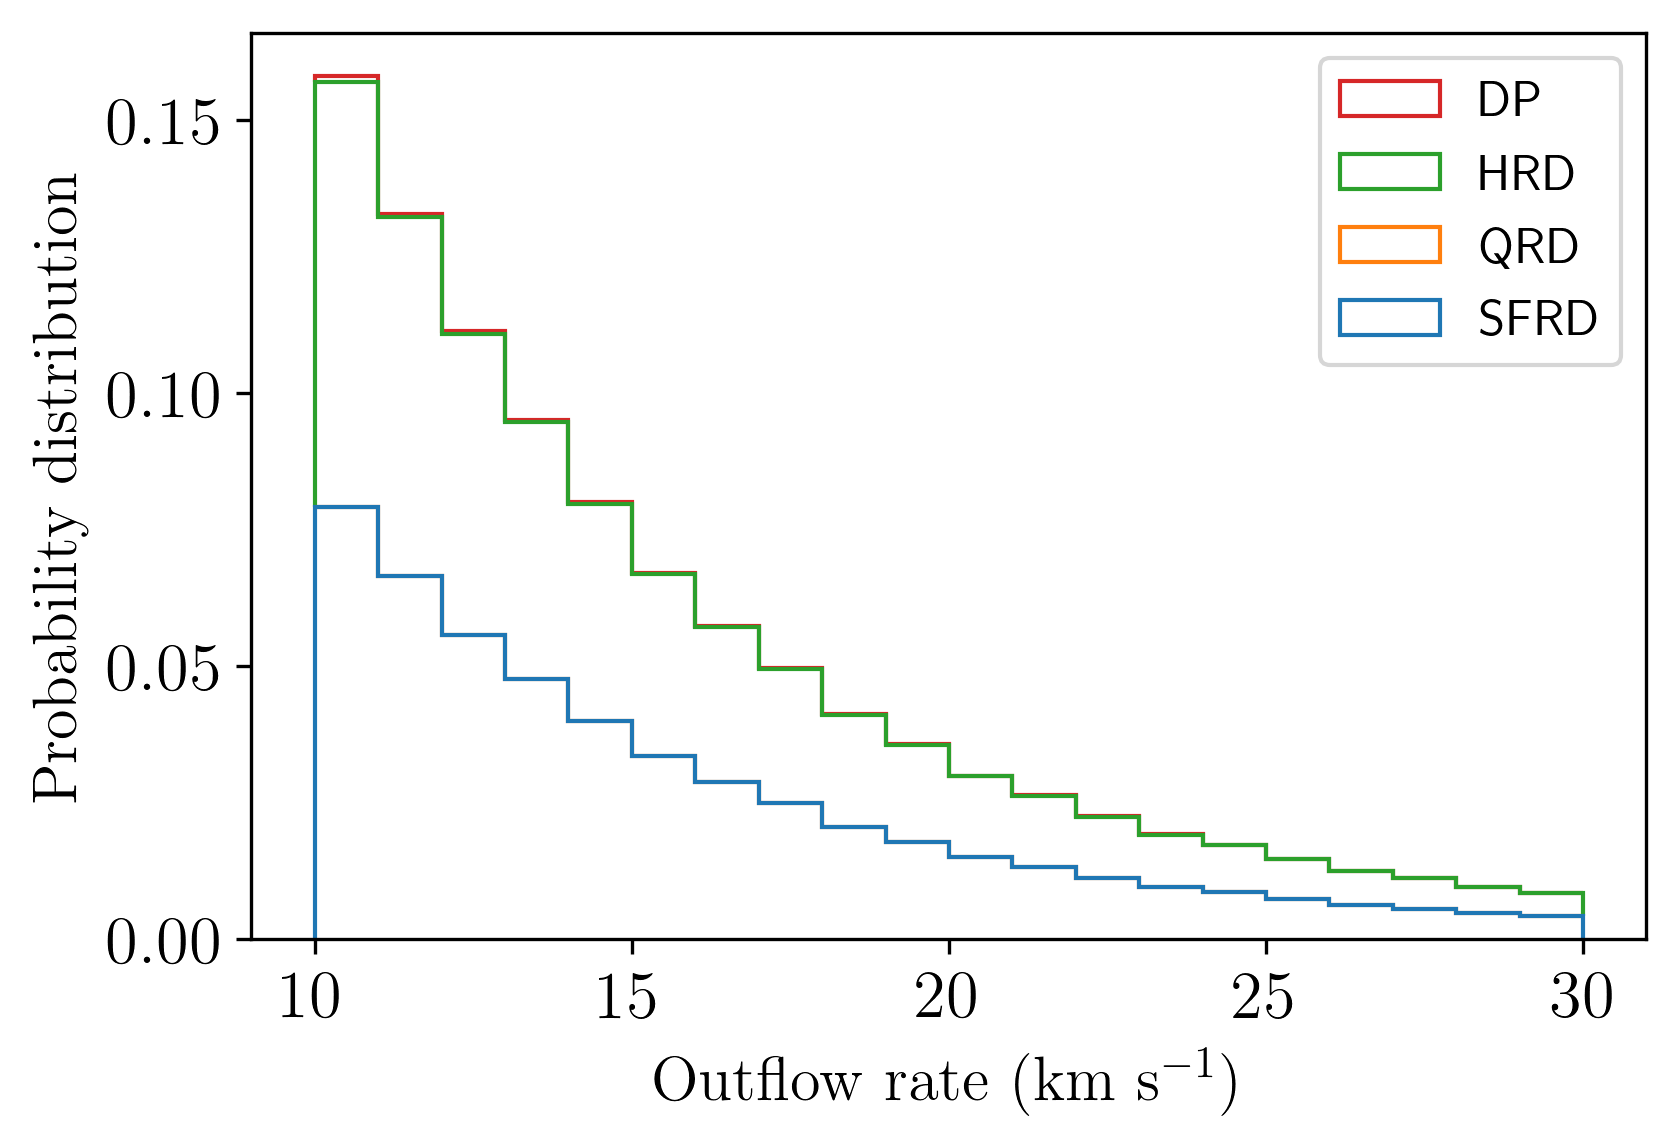

In [15]:
#fig, ax = plt.subplots(111)
w = np.where(G_history[0].StellarMass > 0)[0]
stellarmass = G_history[0].StellarMass[w] * 1.e10 / Hubble_h
allcolddust = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
allhotdust = G_history[0].HotDust[w] * 1.e10 / Hubble_h
allsfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
allrate = G_history[0].OutflowRate[w]

#massive galaxies
w = np.where((stellarmass > 1e9) & (stellarmass < 1e12))[0]
colddust = allcolddust[w]/stellarmass[w]
hotdust = allhotdust[w]/stellarmass[w]
sfr = allsfr[w]
rate = allrate[w]

#SFDR
w = np.where((colddust > 1e-4) & (sfr > -1))[0]
rate_a = rate[w]

#QDR
w = np.where((colddust > 1e-4) & (sfr < -1))[0]
rate_b = rate[w]

#HDR
w = np.where((colddust > 1e-4) & (hotdust > 1e-4))[0]
rate_c = rate[w]

#DP
w = np.where((colddust > 1e-4) & (hotdust < 1e-4))[0]
rate_d = rate[w]

nbins = 20
outflowrate = [rate_a, rate_b, rate_c, rate_d]
labels = ['SFRD', 'QRD', 'HRD', 'DP']
plt.hist(outflowrate, nbins, range=(10,30), density=True, histtype='step', stacked=True, label=labels)
plt.legend(loc=0)

plt.ylabel(r'$\mathrm{Probability}\ \mathrm{distribution}$', fontsize=15)
plt.xlabel(r'$\mathrm{Outflow}\ \mathrm{rate}\ \mathrm{(km}\ \mathrm{s}^{-1})$', fontsize=15)

plt.savefig('plots/outflowrate-testbulge3.png', bbox_inches='tight')

/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


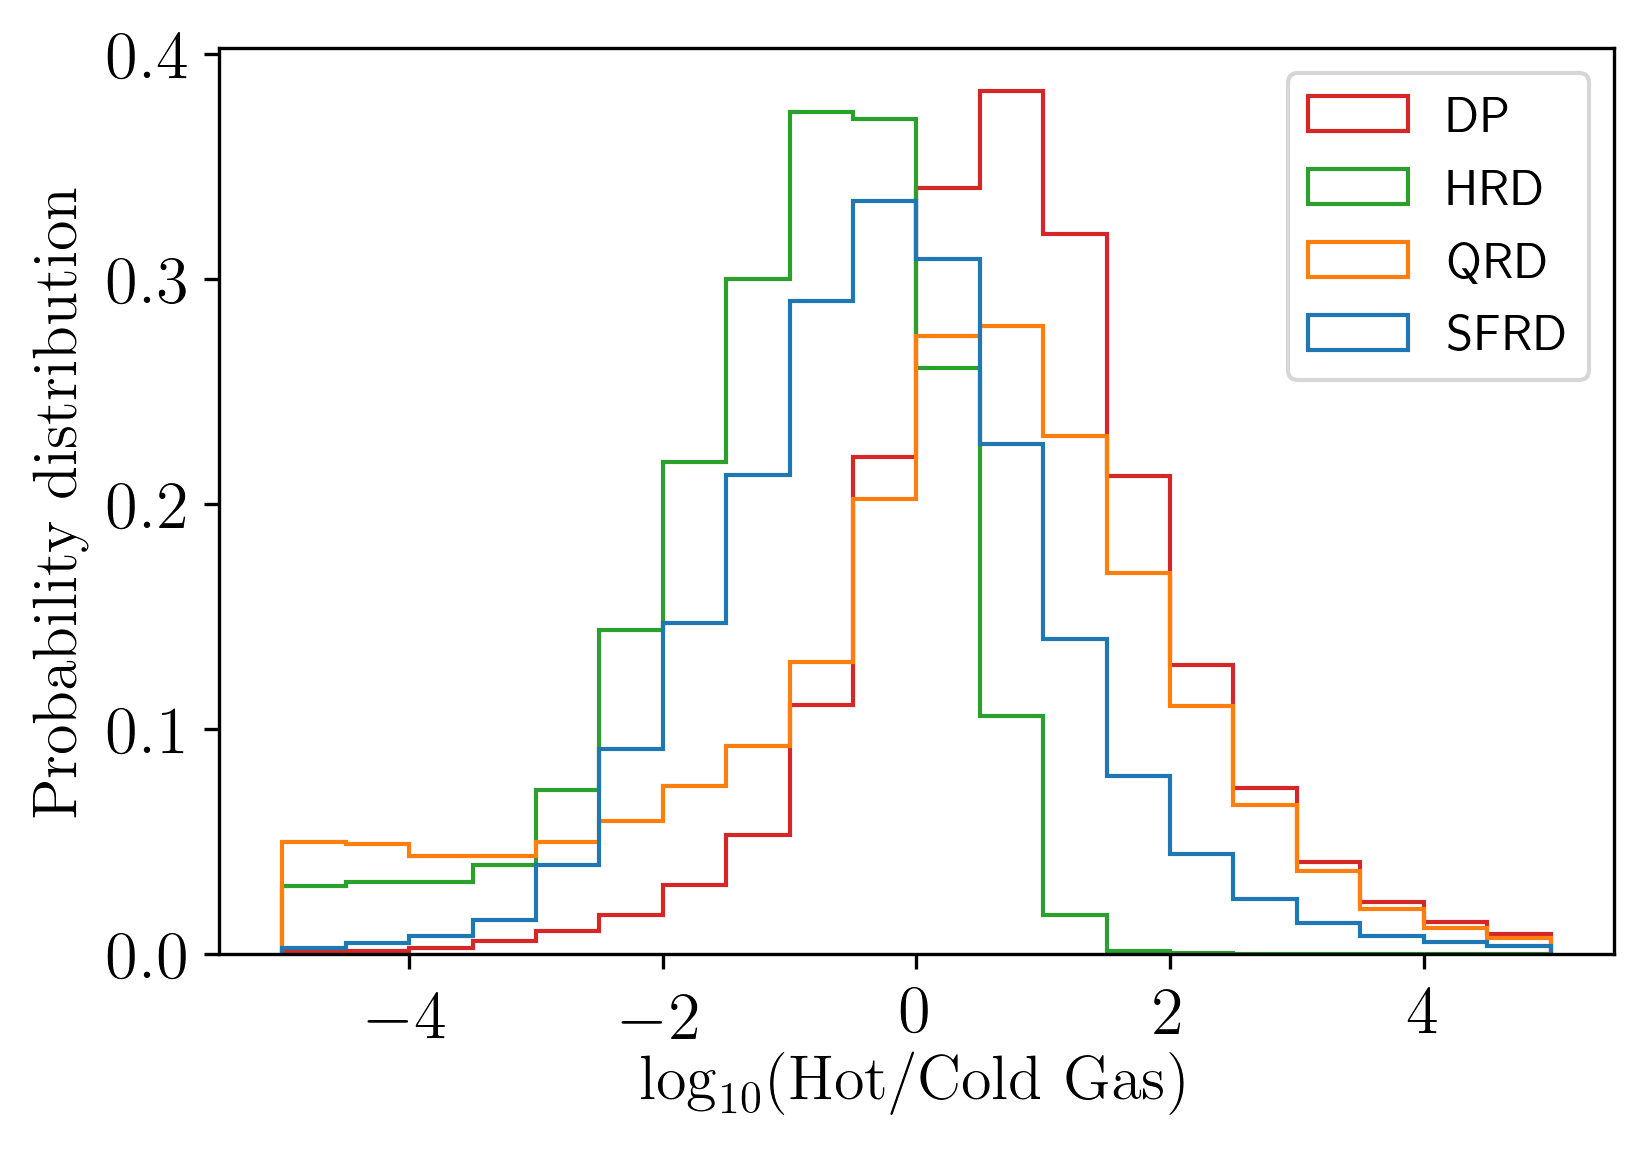

In [12]:
#fig, ax = plt.subplots(111)
w = np.where((G_history[0].HotGas > 0) & (G_history[0].ColdGas > 0))[0]
stellarmass = G_history[0].StellarMass[w] * 1.e10 / Hubble_h
allcolddust = G_history[0].ColdDust[w] * 1.e10 / Hubble_h
allhotdust = G_history[0].HotDust[w] * 1.e10 / Hubble_h
allsfr = np.log10(G_history[0].SfrDisk[w] + G_history[0].SfrBulge[w])
allcold = G_history[0].ColdGas[w] * 1.e10 / Hubble_h
allhot = G_history[0].HotGas[w] * 1.e10 / Hubble_h

#massive galaxies
w = np.where((stellarmass > 1e9) & (stellarmass < 1e12))[0]
colddust = allcolddust[w]/stellarmass[w]
hotdust = allhotdust[w]/stellarmass[w]
sfr = allsfr[w]
cold = allcold[w]
hot = allhot[w]
frac = np.log(cold/hot)

#SFDR
w = np.where((colddust > 1e-4) & (sfr > -1))[0]
frac_a = frac[w]

#QDR
w = np.where((colddust > 1e-4) & (sfr < -1))[0]
frac_b = frac[w]

#HDR
w = np.where((colddust > 1e-4) & (hotdust > 1e-4))[0]
frac_c = frac[w]

#DP
w = np.where((colddust > 1e-4) & (hotdust < 1e-4))[0]
frac_d = frac[w]

nbins = 20
fraction = [frac_a, frac_b, frac_c, frac_d]
labels = ['SFRD', 'QRD', 'HRD', 'DP']
plt.hist(fraction, nbins, range=(-5,5), density=True, histtype='step', label=labels)
plt.legend(loc=0)

plt.ylabel(r'$\mathrm{Probability}\ \mathrm{distribution}$', fontsize=15)
plt.xlabel(r'$\log_{10} (\mathrm{Hot} / \mathrm{Cold}\ \mathrm{Gas})$', fontsize=15)

plt.savefig('plots/hot-cold-gas-testbulge3.png', bbox_inches='tight')